<h1>Техническая справка</h1>

Наш алгоритм использует WTTE-RNN для предсказаний оттока клиентов. Этот подход позволяет нам не агрегировать данные по времени или пользователям, а сохранять исходную структуру данных, тем самым мы не теряем информативность данных.

![](https://sun9-77.userapi.com/impg/9Ha6tBIS8n8MY7tqJvDIPDfX9x9oyrvanyPyaQ/vKMz1YIHp8k.jpg?size=1919x1079&quality=96&sign=24dd835461eb3d86b01f653d1ebe189d&type=album)


Объяснение работы WTTE-RNN:
- На вход модель получает историю пользователя (информация о предидущих кварталах)
- Задача модели предсказать альфа и бета параметры распределения Вейбулла (из анализа выживаемости).
Это распределение показывает с какой вероятностью произойдет событие (в нашем случае отток) на определенном интервале времени.

![](https://sun9-78.userapi.com/impg/2yLe-i50tj3x3yQiXggZMu256EZcMZHM60b6AA/otQyd7MtcUs.jpg?size=1919x1079&quality=96&sign=9ad63587a0d4ff730a44c545782d59dc&type=album)

--------------------------

<h1>Структура блокнота</h1>

- Импорт данных. В этом пункте производится загрузка датасета, удаление не нужных признаков, нормализация данных.


- Подготовка датасета. Здесь датасет преобразуется в формат для обучения и валидации, также происходит аугментация данных.


- Обучение. На данном этапе создается модель и проходит обучение.


- Визуализация распределений. Визуализируются распределения, полученные для различных пользователей.


- Расчет вероятностей. Здесь расчитывается вероятность попасть в заданный временной интервал, имея параметры распределения (в данном случае нас интересует порог в 1 квартал). Затем расчитываем ROC-AUC для поиска оптимального порога бинарной классификации (1 - клиент уйдет в отток в следующем месяце, 0 - клиент не уйдет в отток в следующем месяце), благодаря этому шагу переводим вероятность оттока во временном интервале в бинарную метку. Затем считаем F1


- Преобразование предсказаний. Все полученные предскзания преобразуются к виду sample_submission.csv



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Импорт данных

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras import backend as k
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib.pyplot as plt

#np.set_printoptions(suppress=True, threshold=10000)

#загрузка данных
train = pd.read_csv('/content/drive/MyDrive/хаки/prepare_data.csv')
train=train.drop('quarter', axis=1)

In [ ]:
from tqdm import tqdm

Удаляем из таблицы ненужные столбцы

In [ ]:
drop_list=['slctn_nmbr', 'pmnts_type', 'incm_per_year', 'mgd_accum_period',
           'mgd_payment_period', 'phone_number', 'email', 'lk',
           'assignee_ops', 'postal_code', 'fact_addrss', 'churn', 'sum_leave', 'time_diff']

In [ ]:
train=train.drop(drop_list, axis=1)

Нормализуем данные для стабильного обучения

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Инициализация стандартизатора
#scaler = StandardScaler()

ids=train['client_id']
train=train.drop('client_id', axis=1)

# Вычисление средних значений и стандартных отклонений для каждого столбца и применение к данным
#normalized_data = scaler.fit_transform(train)
train=train.fillna(0)
normalized_data = normalize(train.values, axis=0)
normalized_data
# Создание нового DataFrame с нормализованными данными
df_normalized = pd.DataFrame(normalized_data, columns=train.columns)



In [ ]:
df_normalized['User_ID']=ids


Преобразуем строковой id (к примеру 0x6F165383BAEA764C931429EF6AB0491E) в id порядкового типа (1,2,3 и т.п), с возможностью конвертации обратно

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к столбцу 'id'
df_normalized['User_ID'] = label_encoder.fit_transform(df_normalized['User_ID'])

# Печать соответствия между исходными значениями и их числовыми кодами
#label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
#print("Mapping of original values to encoded values:")
#print(label_mapping)

# Обратное преобразование числовых значений в исходные
#df_normalized['id_decoded'] = label_encoder.inverse_transform(df_normalized['id_encoded'])




In [ ]:
df_normalized

npo_accnts_nmbr    gender       age  clnt_cprtn_time_d  actv_prd_d  \
0              0.000793  0.001207  0.000919           0.000055    0.000022   
1              0.000793  0.001207  0.000919           0.000105    0.000095   
2              0.000793  0.001207  0.000919           0.000156    0.000165   
3              0.000793  0.001207  0.000946           0.000205    0.000235   
4              0.000793  0.001207  0.000946           0.000255    0.000306   
...                 ...       ...       ...                ...         ...   
685848         0.001586  0.001207  0.001433           0.001133    0.001556   
685849         0.001586 -0.001207  0.001081           0.000049    0.000047   
685850         0.001586 -0.001207  0.001081           0.000099    0.000121   
685851         0.001586 -0.001207  0.001081           0.000149    0.000188   
685852         0.001586 -0.001207  0.001081           0.000200    0.000258   

        lst_pmnt_rcnc_d   balance  oprtn_sum_per_qrtr  oprtn_sum_per_year  \
0              0.000000  0.000029            0.000152            0.000500   
1              0.000069  0.000133            0.000533            0.000500   
2              0.000127  0.000177            0.000228            0.000500   
3              0.000067  0.000219            0.000216            0.000848   
4              0.000067  0.000311            0.000475            0.000848   
...                 ...       ...                 ...                 ...   
685848         0.000064  0.000504            0.000110            0.000256   
685849         0.000000  0.000003            0.000017            0.000037   
685850         0.000064  0.000006            0.000017            0.000037   
685851         0.000064  0.000010            0.000017            0.000037   
685852         0.000075  0.000013            0.000017            0.000037   

        frst_pmnt  ...  pmnts_sum_per_year  pmnts_nmbr_per_qrtr  \
0        0.000043  ...            0.001100             0.000849   
1        0.000043  ...            0.001100             0.001698   
2        0.000043  ...            0.001100             0.000849   
3        0.000043  ...            0.001786             0.001273   
4        0.000043  ...            0.001786             0.001273   
...           ...  ...                 ...                  ...   
685848   0.000004  ...            0.000571             0.001273   
685849   0.000003  ...            0.000081             0.001273   
685850   0.000003  ...            0.000081             0.001273   
685851   0.000003  ...            0.000081             0.001273   
685852   0.000003  ...            0.000081             0.001273   

        pmnts_nmbr_per_year      incm_sum  incm_per_qrtr  assignee_npo  \
0                  0.000895  0.000000e+00       0.000000     -0.001207   
1                  0.000895  0.000000e+00       0.000000     -0.001207   
2                  0.000895  4.022864e-06       0.000042     -0.001207   
3                  0.001454  4.022864e-06       0.000000     -0.001207   
4                  0.001454  4.022864e-06       0.000000     -0.001207   
...                     ...           ...            ...           ...   
685848             0.001454  7.530810e-05       0.000000     -0.001207   
685849             0.001342  0.000000e+00       0.000000     -0.001207   
685850             0.001342  0.000000e+00       0.000000     -0.001207   
685851             0.001342  0.000000e+00       0.000000     -0.001207   
685852             0.001342  2.888784e-07       0.000003     -0.001207   

         citizen  appl_mrkr  evry_qrtr_pmnt  User_ID  
0       0.001207        0.0        0.001453        0  
1       0.001207        0.0        0.001453        0  
2       0.001207        0.0        0.001453        0  
3       0.001207        0.0        0.001453        0  
4       0.001207        0.0        0.001453        0  
...          ...        ...             ...      ...  
685848 -0.001207        0.0        0.001453    47131  
685849  0.00

Добавляем временные метки к строкам, в результате получиться столбец (Time_Step), содержащий порядковые числа строк по хронологии для каждого user_id.

Благодаря этому мы сообщим модели хронологию последовательни отчетов по кварталам.

Каждая единица в новом столбце означает 1 квартал (из этого следует каждые 4 единицы - один год)


In [ ]:
df_normalized['Time_Step'] = df_normalized.groupby('User_ID').cumcount() + 1

In [ ]:
df_normalized

npo_accnts_nmbr    gender       age  clnt_cprtn_time_d  actv_prd_d  \
0              0.000793  0.001207  0.000919           0.000055    0.000022   
1              0.000793  0.001207  0.000919           0.000105    0.000095   
2              0.000793  0.001207  0.000919           0.000156    0.000165   
3              0.000793  0.001207  0.000946           0.000205    0.000235   
4              0.000793  0.001207  0.000946           0.000255    0.000306   
...                 ...       ...       ...                ...         ...   
685848         0.001586  0.001207  0.001433           0.001133    0.001556   
685849         0.001586 -0.001207  0.001081           0.000049    0.000047   
685850         0.001586 -0.001207  0.001081           0.000099    0.000121   
685851         0.001586 -0.001207  0.001081           0.000149    0.000188   
685852         0.001586 -0.001207  0.001081           0.000200    0.000258   

        lst_pmnt_rcnc_d   balance  oprtn_sum_per_qrtr  oprtn_sum_per_year  \
0              0.000000  0.000029            0.000152            0.000500   
1              0.000069  0.000133            0.000533            0.000500   
2              0.000127  0.000177            0.000228            0.000500   
3              0.000067  0.000219            0.000216            0.000848   
4              0.000067  0.000311            0.000475            0.000848   
...                 ...       ...                 ...                 ...   
685848         0.000064  0.000504            0.000110            0.000256   
685849         0.000000  0.000003            0.000017            0.000037   
685850         0.000064  0.000006            0.000017            0.000037   
685851         0.000064  0.000010            0.000017            0.000037   
685852         0.000075  0.000013            0.000017            0.000037   

        frst_pmnt  ...  pmnts_nmbr_per_qrtr  pmnts_nmbr_per_year  \
0        0.000043  ...             0.000849             0.000895   
1        0.000043  ...             0.001698             0.000895   
2        0.000043  ...             0.000849             0.000895   
3        0.000043  ...             0.001273             0.001454   
4        0.000043  ...             0.001273             0.001454   
...           ...  ...                  ...                  ...   
685848   0.000004  ...             0.001273             0.001454   
685849   0.000003  ...             0.001273             0.001342   
685850   0.000003  ...             0.001273             0.001342   
685851   0.000003  ...             0.001273             0.001342   
685852   0.000003  ...             0.001273             0.001342   

            incm_sum  incm_per_qrtr  assignee_npo   citizen  appl_mrkr  \
0       0.000000e+00       0.000000     -0.001207  0.001207        0.0   
1       0.000000e+00       0.000000     -0.001207  0.001207        0.0   
2       4.022864e-06       0.000042     -0.001207  0.001207        0.0   
3       4.022864e-06       0.000000     -0.001207  0.001207        0.0   
4       4.022864e-06       0.000000     -0.001207  0.001207        0.0   
...              ...            ...           ...       ...        ...   
685848  7.530810e-05       0.000000     -0.001207 -0.001207        0.0   
685849  0.000000e+00       0.000000     -0.001207  0.001207        0.0   
685850  0.000000e+00       0.000000     -0.001207  0.001207        0.0   
685851  0.000000e+00       0.000000     -0.001207  0.001207        0.0   
685852  2.888784e-07       0.000003     -0.001207  0.001207        0.0   

        evry_qrtr_pmnt  User_ID  Time_Step  
0             0.001453        0          1  
1             0.001453        0          2  
2             0.001453        0          3  
3             0.001453        0          4  
4             0.001453        0          5  
...                ...      ...        ...  
685848        0.001453    47131         46  
685849        0.001453    47132          1  
685850        0.001453    47132    

In [ ]:
#чаще всего (у 2352 клиентов) отток происходит через 11 кварталов
ff=df_normalized.groupby('User_ID')['Time_Step'].max()
ff.value_counts()

Time_Step
11    2352
4     2349
5     2338
10    2279
2     2259
      ... 
67       4
91       1
68       1
78       1
77       1
Name: count, Length: 71, dtype: int64

<Axes: >

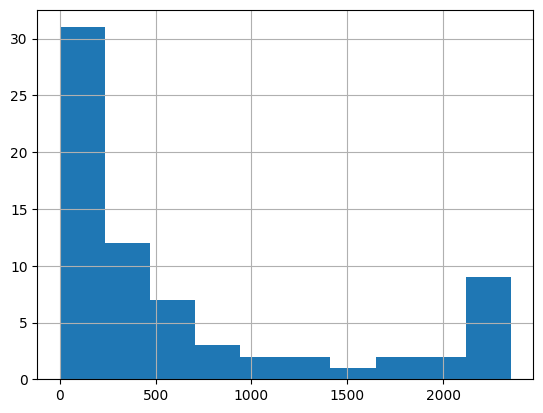

In [ ]:
ff.value_counts().hist()

Выводим кол-во встреч для каждого варианта "сколько дней осталось до оттока?"

- ключ - сколько дней до оттока

- значение - кол-во пользователей с таким кол-вом дней до оттока

In [ ]:
from collections import Counter
b = Counter(ff)

In [ ]:
b

Counter({7: 2062,
         58: 43,
         11: 2352,
         14: 1576,
         34: 375,
         17: 1172,
         1: 1697,
         3: 2245,
         10: 2279,
         2: 2259,
         4: 2349,
         6: 2162,
         5: 2338,
         9: 2158,
         16: 1206,
         20: 859,
         35: 320,
         15: 1358,
         8: 2131,
         55: 49,
         22: 700,
         21: 785,
         24: 599,
         13: 1856,
         12: 2114,
         51: 78,
         19: 923,
         49: 81,
         41: 215,
         37: 303,
         27: 513,
         42: 205,
         26: 538,
         33: 395,
         23: 631,
         46: 136,
         48: 96,
         63: 22,
         40: 241,
         44: 158,
         28: 492,
         45: 121,
         18: 1010,
         31: 437,
         32: 400,
         36: 340,
         30: 422,
         43: 133,
         50: 73,
         57: 40,
         25: 559,
         29: 440,
         47: 115,
         39: 275,
         62: 29,
         3

Считаем кол-во временных шагов до наступления события оттока (нужно для обучения)

In [ ]:
# Сгруппировать данные по user_id и вычислить максимальное значение временной метки в каждой группе
max_timestamps = df_normalized.groupby('User_ID')['Time_Step'].max()

# Объединить максимальные значения с исходным DataFrame
df_normalized = df_normalized.merge(max_timestamps.rename('max_timestamp'), on='User_ID')

# Вычесть максимальное значение временной метки из каждой временной метки в группе
df_normalized['time_diff'] = df_normalized['max_timestamp'] - df_normalized['Time_Step']
# Удаляем вспомогательный столбец
df_normalized=df_normalized.drop(['max_timestamp'], axis=1)


In [ ]:
df_normalized

npo_accnts_nmbr    gender       age  clnt_cprtn_time_d  actv_prd_d  \
0              0.000793  0.001207  0.000919           0.000055    0.000022   
1              0.000793  0.001207  0.000919           0.000105    0.000095   
2              0.000793  0.001207  0.000919           0.000156    0.000165   
3              0.000793  0.001207  0.000946           0.000205    0.000235   
4              0.000793  0.001207  0.000946           0.000255    0.000306   
...                 ...       ...       ...                ...         ...   
685848         0.001586  0.001207  0.001433           0.001133    0.001556   
685849         0.001586 -0.001207  0.001081           0.000049    0.000047   
685850         0.001586 -0.001207  0.001081           0.000099    0.000121   
685851         0.001586 -0.001207  0.001081           0.000149    0.000188   
685852         0.001586 -0.001207  0.001081           0.000200    0.000258   

        lst_pmnt_rcnc_d   balance  oprtn_sum_per_qrtr  oprtn_sum_per_year  \
0              0.000000  0.000029            0.000152            0.000500   
1              0.000069  0.000133            0.000533            0.000500   
2              0.000127  0.000177            0.000228            0.000500   
3              0.000067  0.000219            0.000216            0.000848   
4              0.000067  0.000311            0.000475            0.000848   
...                 ...       ...                 ...                 ...   
685848         0.000064  0.000504            0.000110            0.000256   
685849         0.000000  0.000003            0.000017            0.000037   
685850         0.000064  0.000006            0.000017            0.000037   
685851         0.000064  0.000010            0.000017            0.000037   
685852         0.000075  0.000013            0.000017            0.000037   

        frst_pmnt  ...  pmnts_nmbr_per_year      incm_sum  incm_per_qrtr  \
0        0.000043  ...             0.000895  0.000000e+00       0.000000   
1        0.000043  ...             0.000895  0.000000e+00       0.000000   
2        0.000043  ...             0.000895  4.022864e-06       0.000042   
3        0.000043  ...             0.001454  4.022864e-06       0.000000   
4        0.000043  ...             0.001454  4.022864e-06       0.000000   
...           ...  ...                  ...           ...            ...   
685848   0.000004  ...             0.001454  7.530810e-05       0.000000   
685849   0.000003  ...             0.001342  0.000000e+00       0.000000   
685850   0.000003  ...             0.001342  0.000000e+00       0.000000   
685851   0.000003  ...             0.001342  0.000000e+00       0.000000   
685852   0.000003  ...             0.001342  2.888784e-07       0.000003   

        assignee_npo   citizen  appl_mrkr  evry_qrtr_pmnt  User_ID  Time_Step  \
0          -0.001207  0.001207        0.0        0.001453        0          1   
1          -0.001207  0.001207        0.0        0.001453        0          2   
2          -0.001207  0.001207        0.0        0.001453        0          3   
3          -0.001207  0.001207        0.0        0.001453        0          4   
4          -0.001207  0.001207        0.0        0.001453        0          5   
...              ...       ...        ...             ...      ...        ...   
685848     -0.001207 -0.001207        0.0        0.001453    47131         46   
685849     -0.001207  0.001207        0.0        0.001453    47132          1   
685850     -0.001207  0.001207        0.0        0.001453    47132          2   
685851     -0.001207  0.001207        0.0        0.001453    47132          3   
685852     -0.001207  0.001207        0.0        0.001453    47132          4   

        time_diff  
0               6  
1               5  
2               4  
3               3  
4               2  
...           ...  
685848          0  
685849          3  
685850          2  
685851          1  
685852          0  

[685853 rows x 26 c

##Подготовка датасета

Создание мини датасета (для ускорения обучения)

In [ ]:
ids=df_normalized['User_ID'].unique()

In [ ]:
train_df=df_normalized.drop(['time_diff'], axis=1)
test_df=df_normalized
test_df['Time_Step']=df_normalized['time_diff']
test_df=df_normalized.drop(['time_diff'], axis=1)





mini_df=  train_df[train_df['User_ID'].isin(ids[:10000])]
mini_test_df = test_df[test_df['User_ID'].isin(ids[10000:13000])]

Создание целевых меток для x_test

In [ ]:
df_normalized.groupby('User_ID')['Time_Step'].max()

User_ID
0         7
1        58
2        11
3        14
4        34
         ..
47128    11
47129    14
47130    12
47131    46
47132     4
Name: Time_Step, Length: 47133, dtype: int64

In [ ]:
test_y=mini_test_df.groupby('User_ID')['Time_Step'].max()+1

###Преобразование данных

Для создания датасета для обучения мы задаем буффер определенной длинны (max_time), в котором будут храниться некоторые кварталы (часть истории) пользователя.

В качестве целевой переменной берем кол-во осташихся кварталов для события (оттока)

Каждый из буфферов считаеться отельной выборкой и подаеться в модель для предсказания Y train

На картинке изображен пример буфферов с длинной = 3

(К примеру в 4 буффере будет содержаться информация за 2,3 и 4 кварталах -> в кажом квартале 23 признака, а у нас их 3, поэтому итоговой размер этого семпла = [3, 23])

![](https://sun9-6.userapi.com/impg/8jzm1n36MFOl_sbljyZ5BIpXueBpW1cesFzQ6g/21rGCViWImA.jpg?size=1919x1079&quality=96&sign=6a78f8abf45a0d4358dd860b2ccea870&type=album)

Для обучения мы составляем последовательности длинной max_time. Мы учимся предсказывать время до события оттока.

In [ ]:
#функция для преобраазования необработанных train и test датафреймов к train_x, train_y, test_x, test_y для обучения
def build_data(df, max_time, is_test, mask_value=-99):

  ids = df['User_ID'].unique()
  time = df['Time_Step']
  features = df.drop(['User_ID','Time_Step'], axis = 1)

  num_features = features.shape[1]
  out_y = np.empty((0, 2), dtype=np.float32)

  out_x = np.empty((0, max_time, num_features), dtype=np.float32)


  max_engine_times = df.groupby('User_ID')['Time_Step'].max()
  for id in ids:
      id = int(id)
      if id%100==0:
        print("Engine: " + str(id))
      max_engine_time = max_engine_times[id]

      if is_test:
          start = max_engine_time - 1
      else:
          start = 0

      this_x = np.empty((0, max_time, num_features), dtype=np.float32)


      for j in range(int(start), int(max_engine_time)):

        #выбор фичей для текущего пользователя
        engine_x = df[df['User_ID']==id]
        engine_x = engine_x.drop(['User_ID','Time_Step'], axis = 1).values

        out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

        xtemp = np.zeros((1, max_time, num_features))
        xtemp+=mask_value

        xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]

        this_x = np.concatenate((this_x, xtemp))

      out_x = np.concatenate((out_x, this_x))

  return out_x, out_y

#ускоренная версия функции build_data
def build_data_v2(df, max_time, is_test, mask_value=-99):

    engine=df['User_ID'].values

    ids = df['User_ID'].unique()
    time = df['Time_Step']
    features = df.drop(['User_ID','Time_Step'], axis = 1)

    num_features = features.shape[1]
    features=features.values
    out_y = np.empty((0, 2), dtype=np.float32)

    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in ids:
        if i%100==0:
          print("Engine: " + str(i))

        max_engine_time = int(np.max(time[engine == i]))

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = np.empty((0, max_time, num_features), dtype=np.float32)

        for j in range(int(start), int(max_engine_time)):

            engine_x = features[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, num_features))
            xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

#ускоренная версия функции build_data_v2
def build_data_v3(df, max_time, is_test, mask_value=-99):

    grouped = df.groupby('User_ID')

    out_y = []
    out_x = []

    for user_id, group in tqdm(grouped):
        max_engine_time = group['Time_Step'].max()

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            engine_x = group.iloc[:j+1].drop(['User_ID', 'Time_Step'], axis=1).to_numpy()

            out_y.append([max_engine_time - j, 1])

            xtemp = np.zeros((max_time, engine_x.shape[1]))
            xtemp[max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)

        out_x.extend(this_x)

    return np.array(out_x), np.array(out_y)

In [ ]:
max_time = 5 #проходимся окном, длинной max_time для каждого пользователя. (Работает как буффер)
mask_value = -99 #значение, которым будут заполняться неполные подпоследовательности (буффера)

In [ ]:
#преобразует датафреймы в формат для обучения
def get_dfs(mini_df, mini_test_df, test_y, max_time, mask_value, save=False, load=False):
  if load==False:
    train_x, train_y = build_data_v3(mini_df, max_time, False, mask_value)
    test_x = build_data_v3(mini_test_df, max_time, True, mask_value)[0]

    if save:
      np.save('train_x.npy',train_x)
      np.save('train_y.npy',train_y)
      np.save('test_x.npy',test_x)

  else:
    train_x=np.load('/content/drive/MyDrive/хаки/3_2/train_x.npy')
    train_y=np.load('/content/drive/MyDrive/хаки/3_2/train_y.npy')
    test_x=np.load('/content/drive/MyDrive/хаки/3_2/test_x.npy')

  train_u = np.zeros((test_y.shape[0], 1), dtype=np.float32)
  train_u += 1
  test_y = np.append(np.reshape(test_y, (test_y.shape[0], 1)), train_u, axis=1)

  return (train_x, train_y, test_x, test_y)

создает из датафреймов выборки для обучения и валидации

In [ ]:
%%time
train_x, train_y, test_x, test_y =get_dfs(mini_df, mini_test_df, test_y,  max_time, mask_value, save=True, load=False)

Engine: 0
Engine: 100
Engine: 200
Engine: 300
Engine: 400
Engine: 500
Engine: 600
Engine: 700
Engine: 800
Engine: 900
Engine: 1000
Engine: 1100
Engine: 1200
Engine: 1300
Engine: 1400
Engine: 1500
Engine: 1600
Engine: 1700
Engine: 1800
Engine: 1900
Engine: 2000
Engine: 2100
Engine: 2200
Engine: 2300
Engine: 2400
Engine: 2500
Engine: 2600
Engine: 2700
Engine: 2800
Engine: 2900
Engine: 3000
Engine: 3100
Engine: 3200
Engine: 3300
Engine: 3400
Engine: 3500
Engine: 3600
Engine: 3700
Engine: 3800
Engine: 3900
Engine: 4000
Engine: 4100
Engine: 4200
Engine: 4300
Engine: 4400
Engine: 4500
Engine: 4600
Engine: 4700
Engine: 4800
Engine: 4900
Engine: 5000
Engine: 5100
Engine: 5200
Engine: 5300
Engine: 5400
Engine: 5500
Engine: 5600
Engine: 5700
Engine: 5800
Engine: 5900
Engine: 6000
Engine: 6100
Engine: 6200
Engine: 6300
Engine: 6400
Engine: 6500
Engine: 6600
Engine: 6700
Engine: 6800
Engine: 6900
Engine: 7000
Engine: 7100
Engine: 7200
Engine: 7300
Engine: 7400
Engine: 7500
Engine: 7600
Engine: 770

In [ ]:
print(f"Размер train_x = {train_x.shape}, где \n{train_x.shape[0]} - кол-во подпоследовательностей, \n{train_x.shape[1]} - длина подпоследовательностей, \n{train_x.shape[2]} - кол-во признаков")

Размер train_x = (149322, 5, 23), где 
149322 - кол-во подпоследовательностей, 
5 - длина подпоследовательностей, 
23 - кол-во признаков


In [ ]:
test_x.shape

(3000, 5, 23)

In [ ]:
test_y.shape

(3000, 2)

In [ ]:
train_x.shape

(149322, 5, 23)

In [ ]:
train_y.shape

(149322, 2)

(array([7.4591e+04, 3.8881e+04, 1.9687e+04, 1.0120e+04, 4.1630e+03,
        1.4490e+03, 3.8900e+02, 2.3000e+01, 9.0000e+00, 1.0000e+01]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

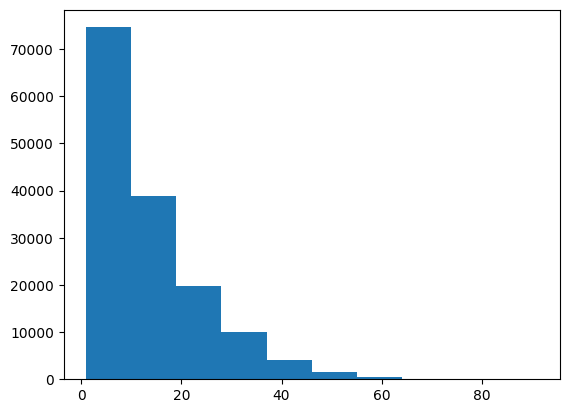

In [ ]:
plt.hist(train_y[:,0])

In [ ]:
from collections import Counter
b = Counter(train_y[:,0])

###Аугментация данных

In [ ]:
import numpy as np


def stable(train_x, train_y, grade = 10000):
    # Check
    group_counts = {
        (1, 10): 0,
        (10, 20): 0,
        (20, 30): 0,
        (30, 40): 0,
        (40, 50): 0,
        (50, 60): 0,
        (60, 70): 0,
        (70, 80): 0,
        (80, 91): 0,
    }
    group_vals = {
        (1, 10): [],
        (10, 20): [],
        (20, 30): [],
        (30, 40): [],
        (40, 50): [],
        (50, 60): [],
        (60, 70): [],
        (70, 80): [],
        (80, 91): [],
    }

    i = 0
    for x, y in zip(train_x, train_y):
        for group in group_counts.keys():
            if (group[0] > y[0]) and (y[0] <= group[1]):
                group_counts[group] += 1
                group_vals[group].append(i)
                break

        i += 1

    # Find values for append and delete
    new_vals = []
    delete_indices = []
    for group in group_counts.keys():
        if not group_counts[group]:
            continue
        j = 0

        dif = group_counts[group] - grade
        if dif > 0:
            j = 0
            while j < dif:
                delete_indices.append(group_vals[group][j])
                group_counts[group] -= 1
                j += 1
        if dif < 0:
            j = 0
            while j < abs(dif):
                for val in group_vals[group]:
                    if j >= abs(dif):
                        break
                    new_vals.append(val)
                    group_counts[group] += 1
                    j += 1

    # Add
    new_train_x = []
    new_train_y = []

    for val in new_vals:
        new_array_x = train_x[val].copy()
        new_array_y = train_y[val].copy()

        new_train_x.append(new_array_x)
        new_train_y.append(new_array_y)

    train_x = np.vstack([train_x, np.array(new_train_x)])
    train_y = np.vstack([train_y, np.array(new_train_y)])

    # Delete
    train_x = np.delete(train_x, delete_indices, axis=0)
    train_y = np.delete(train_y, delete_indices, axis=0)

    return train_x, train_y



In [ ]:
train_x, train_y = stable(train_x, train_y)

(array([1.00000e+05, 9.32250e+04, 9.20290e+04, 9.39090e+04, 9.39710e+04,
        9.38980e+04, 1.14098e+05, 4.88700e+04, 7.00020e+04, 1.00000e+01]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <BarContainer object of 10 artists>)

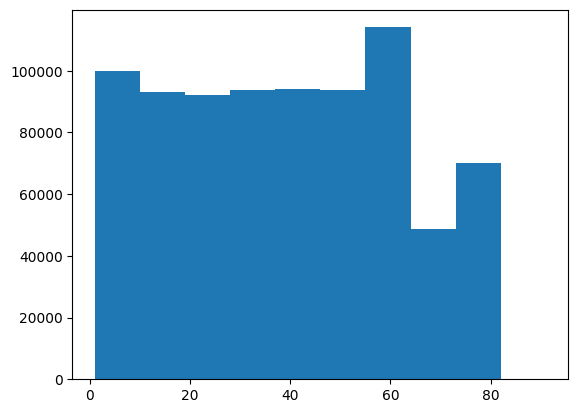

In [ ]:
plt.hist(train_y[:,0])

In [ ]:
#Фунция для перемешивания значений
def data_mixer(train_x, train_y):
    random_indices = np.arange(train_x.shape[0])
    np.random.shuffle(random_indices)

    train_x_shuffle = train_x[random_indices]
    train_y_shuffle = train_y[random_indices]

    return train_x_shuffle, train_y_shuffle




In [ ]:
train_x, train_y = data_mixer(train_x, train_y)

##Обучение

Объявление кастомных функций ошибки и активации

In [ ]:
"""
     Дискретное логарифмическое правдоподобие для функции риска Вейбулла на цензурированных данных о выживании
     y_true — тензор (выборки, 2), содержащий время до события (y) и индикатор события (u).
     ab_pred — тензор (выборки, 2), содержащий предсказанные параметры Вейбулла альфа (а) и бета (б)
     Математические сведения см. https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (стр. 35).
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    #penalty = 0.01 * k.square(a_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1) #+ penalty

"""
     Не используется для этой модели, но включен в комплект на случай, если кому-то понадобится.
     Математические сведения см. https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (стр. 35).
"""
def weibull_loglik_continuous(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    ya = (y_ + 1e-35) / a_
    return -1 * k.mean(u_ * (k.log(b_) + b_ * k.log(ya)) - k.pow(ya, b_))


"""
    Пользовательская функция активации Keras, выводит альфа-нейрон с использованием возведения в степень и бета-версию с помощью softplus
"""
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)




Создание модели

In [ ]:
from keras import regularizers

In [ ]:
from keras.optimizers import Adam

In [ ]:
import keras.backend as K
#K.set_epsilon(1e-10)

model = Sequential()

# Удаляем, добавленные на прошлом этапе, заполнительи, чтобы исключить шум из модели
model.add(Masking(mask_value=mask_value, input_shape=(max_time, test_x.shape[-1])))

# Мы используем LSTM, но также можно GRU
model.add(LSTM(30 , return_sequences=True, input_dim=test_x.shape[-1],recurrent_dropout=0.25))
model.add(LSTM(30 ,recurrent_dropout=0.25))
#model.add(GRU(30, activation='tanh',  input_dim=test_x.shape[-1], recurrent_dropout=0.25))
#model.add(GRU(10, activation='tanh', input_dim=test_x.shape[-1], recurrent_dropout=0.5))
#model.add(LSTM(100))return_sequences=True
model.add(Dense(20))
# Нам нужны 2 нейрона для вывода параметров альфа и бета для нашего распределения Вейбулла.
model.add(Dense(2))

# Примените пользовательскую функцию активации, упомянутую выше.
model.add(Activation(activate))

# Используем дискретное логарифмическое правдоподобие для данных о выживании Вейбулла в качестве нашей функции потерь.
model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(learning_rate=0.00005))#, clipvalue=0.5)) #RMSprop



In [ ]:
train_y.shape

(800012, 2)

In [ ]:
train_y=train_y.astype(float)

In [ ]:
# Fit!
history = model.fit(train_x, train_y, epochs=200, batch_size=50000, verbose=2, validation_data=(test_x, test_y))



Epoch 1/200
17/17 - 13s - loss: 13.3362 - val_loss: 7.1576 - 13s/epoch - 739ms/step
Epoch 2/200
17/17 - 1s - loss: 13.0245 - val_loss: 7.0581 - 1s/epoch - 80ms/step
Epoch 3/200
17/17 - 1s - loss: 12.7470 - val_loss: 6.9557 - 1s/epoch - 79ms/step
Epoch 4/200
17/17 - 1s - loss: 12.4626 - val_loss: 6.8543 - 1s/epoch - 79ms/step
Epoch 5/200
17/17 - 1s - loss: 12.1776 - val_loss: 6.7513 - 1s/epoch - 80ms/step
Epoch 6/200
17/17 - 2s - loss: 11.8892 - val_loss: 6.6459 - 2s/epoch - 90ms/step
Epoch 7/200
17/17 - 2s - loss: 11.5963 - val_loss: 6.5417 - 2s/epoch - 114ms/step
Epoch 8/200
17/17 - 2s - loss: 11.3047 - val_loss: 6.4335 - 2s/epoch - 91ms/step
Epoch 9/200
17/17 - 1s - loss: 11.0073 - val_loss: 6.3254 - 1s/epoch - 78ms/step
Epoch 10/200
17/17 - 1s - loss: 10.7106 - val_loss: 6.2184 - 1s/epoch - 77ms/step
Epoch 11/200
17/17 - 1s - loss: 10.4165 - val_loss: 6.1137 - 1s/epoch - 78ms/step
Epoch 12/200
17/17 - 1s - loss: 10.1263 - val_loss: 6.0095 - 1s/epoch - 79ms/step
Epoch 13/200
17/17 - 

In [ ]:
#model.save('/content/drive/MyDrive/хаки/5/model.keras')

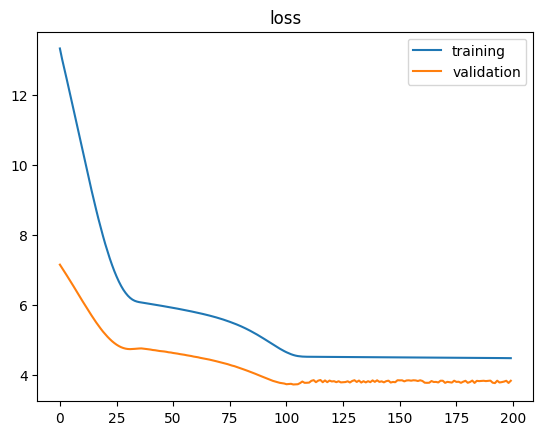

In [ ]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

In [ ]:
#Вывод модели преобразуется в удобную таблицу
def post_prediction_reconstruct(x_pred, y, y_cenzor=0):
  y[:,0] = y[:,0]+y_cenzor
  x_pred = np.resize(x_pred, (y.shape[0], 2))
  result = np.concatenate((y, x_pred), axis=1)

  # TTE, Event Indicator, Alpha, Beta
  results_df = pd.DataFrame(result, columns=['T', 'E', 'alpha', 'beta'])
  results_df['unit_number'] = np.arange(1, results_df.shape[0]+1)
  return results_df

In [ ]:
#Находит альфа и бета параметры распределения
def get_alpha_beta(x, y, y_cenzor=0):
  predict = model.predict(x)
  results_df = post_prediction_reconstruct(predict, y, y_cenzor)
  results_df.loc[results_df['beta'] <= 1, 'beta'] = 1.1
  return results_df

In [ ]:
test_results_df = get_alpha_beta(test_x, test_y)

94/94 [==============================] - 1s 6ms/step


In [ ]:
test_results_df

T    E      alpha      beta  unit_number
0      7.0  1.0  43.664921  1.727425            1
1      2.0  1.0   1.899633  1.100000            2
2     11.0  1.0  45.703465  1.739680            3
3     11.0  1.0  43.900257  1.728647            4
4      4.0  1.0   6.040463  1.030879            5
...    ...  ...        ...       ...          ...
2995   7.0  1.0  43.914001  1.728283         2996
2996  18.0  1.0  43.582741  1.726810         2997
2997  32.0  1.0  43.587730  1.726832         2998
2998   3.0  1.0   3.001704  1.100000         2999
2999   5.0  1.0  15.555761  1.294045         3000

[3000 rows x 5 columns]

##Визуализация распределений

In [ ]:
import math

In [ ]:
"""
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)
"""
from scipy.stats import weibull_min

def weibull_pdf(alpha, beta, t):
    return weibull_min.pdf(t, beta, scale=alpha)

def weibull_median(alpha, beta):
    return weibull_min.median(beta, scale=alpha)

def weibull_mean(alpha, beta):
    return weibull_min.mean(beta, scale=alpha)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

In [ ]:
import seaborn as sns

In [ ]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,75)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')

    ax=axarr[1]

    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']

#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')


    ax.legend()

    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()

#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()

#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()


Визуализация распределений вероятностей всех пользователей

<ipython-input-61-30faf6d406db>:45: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results_df['T'] - mode_predictions, ax=ax)


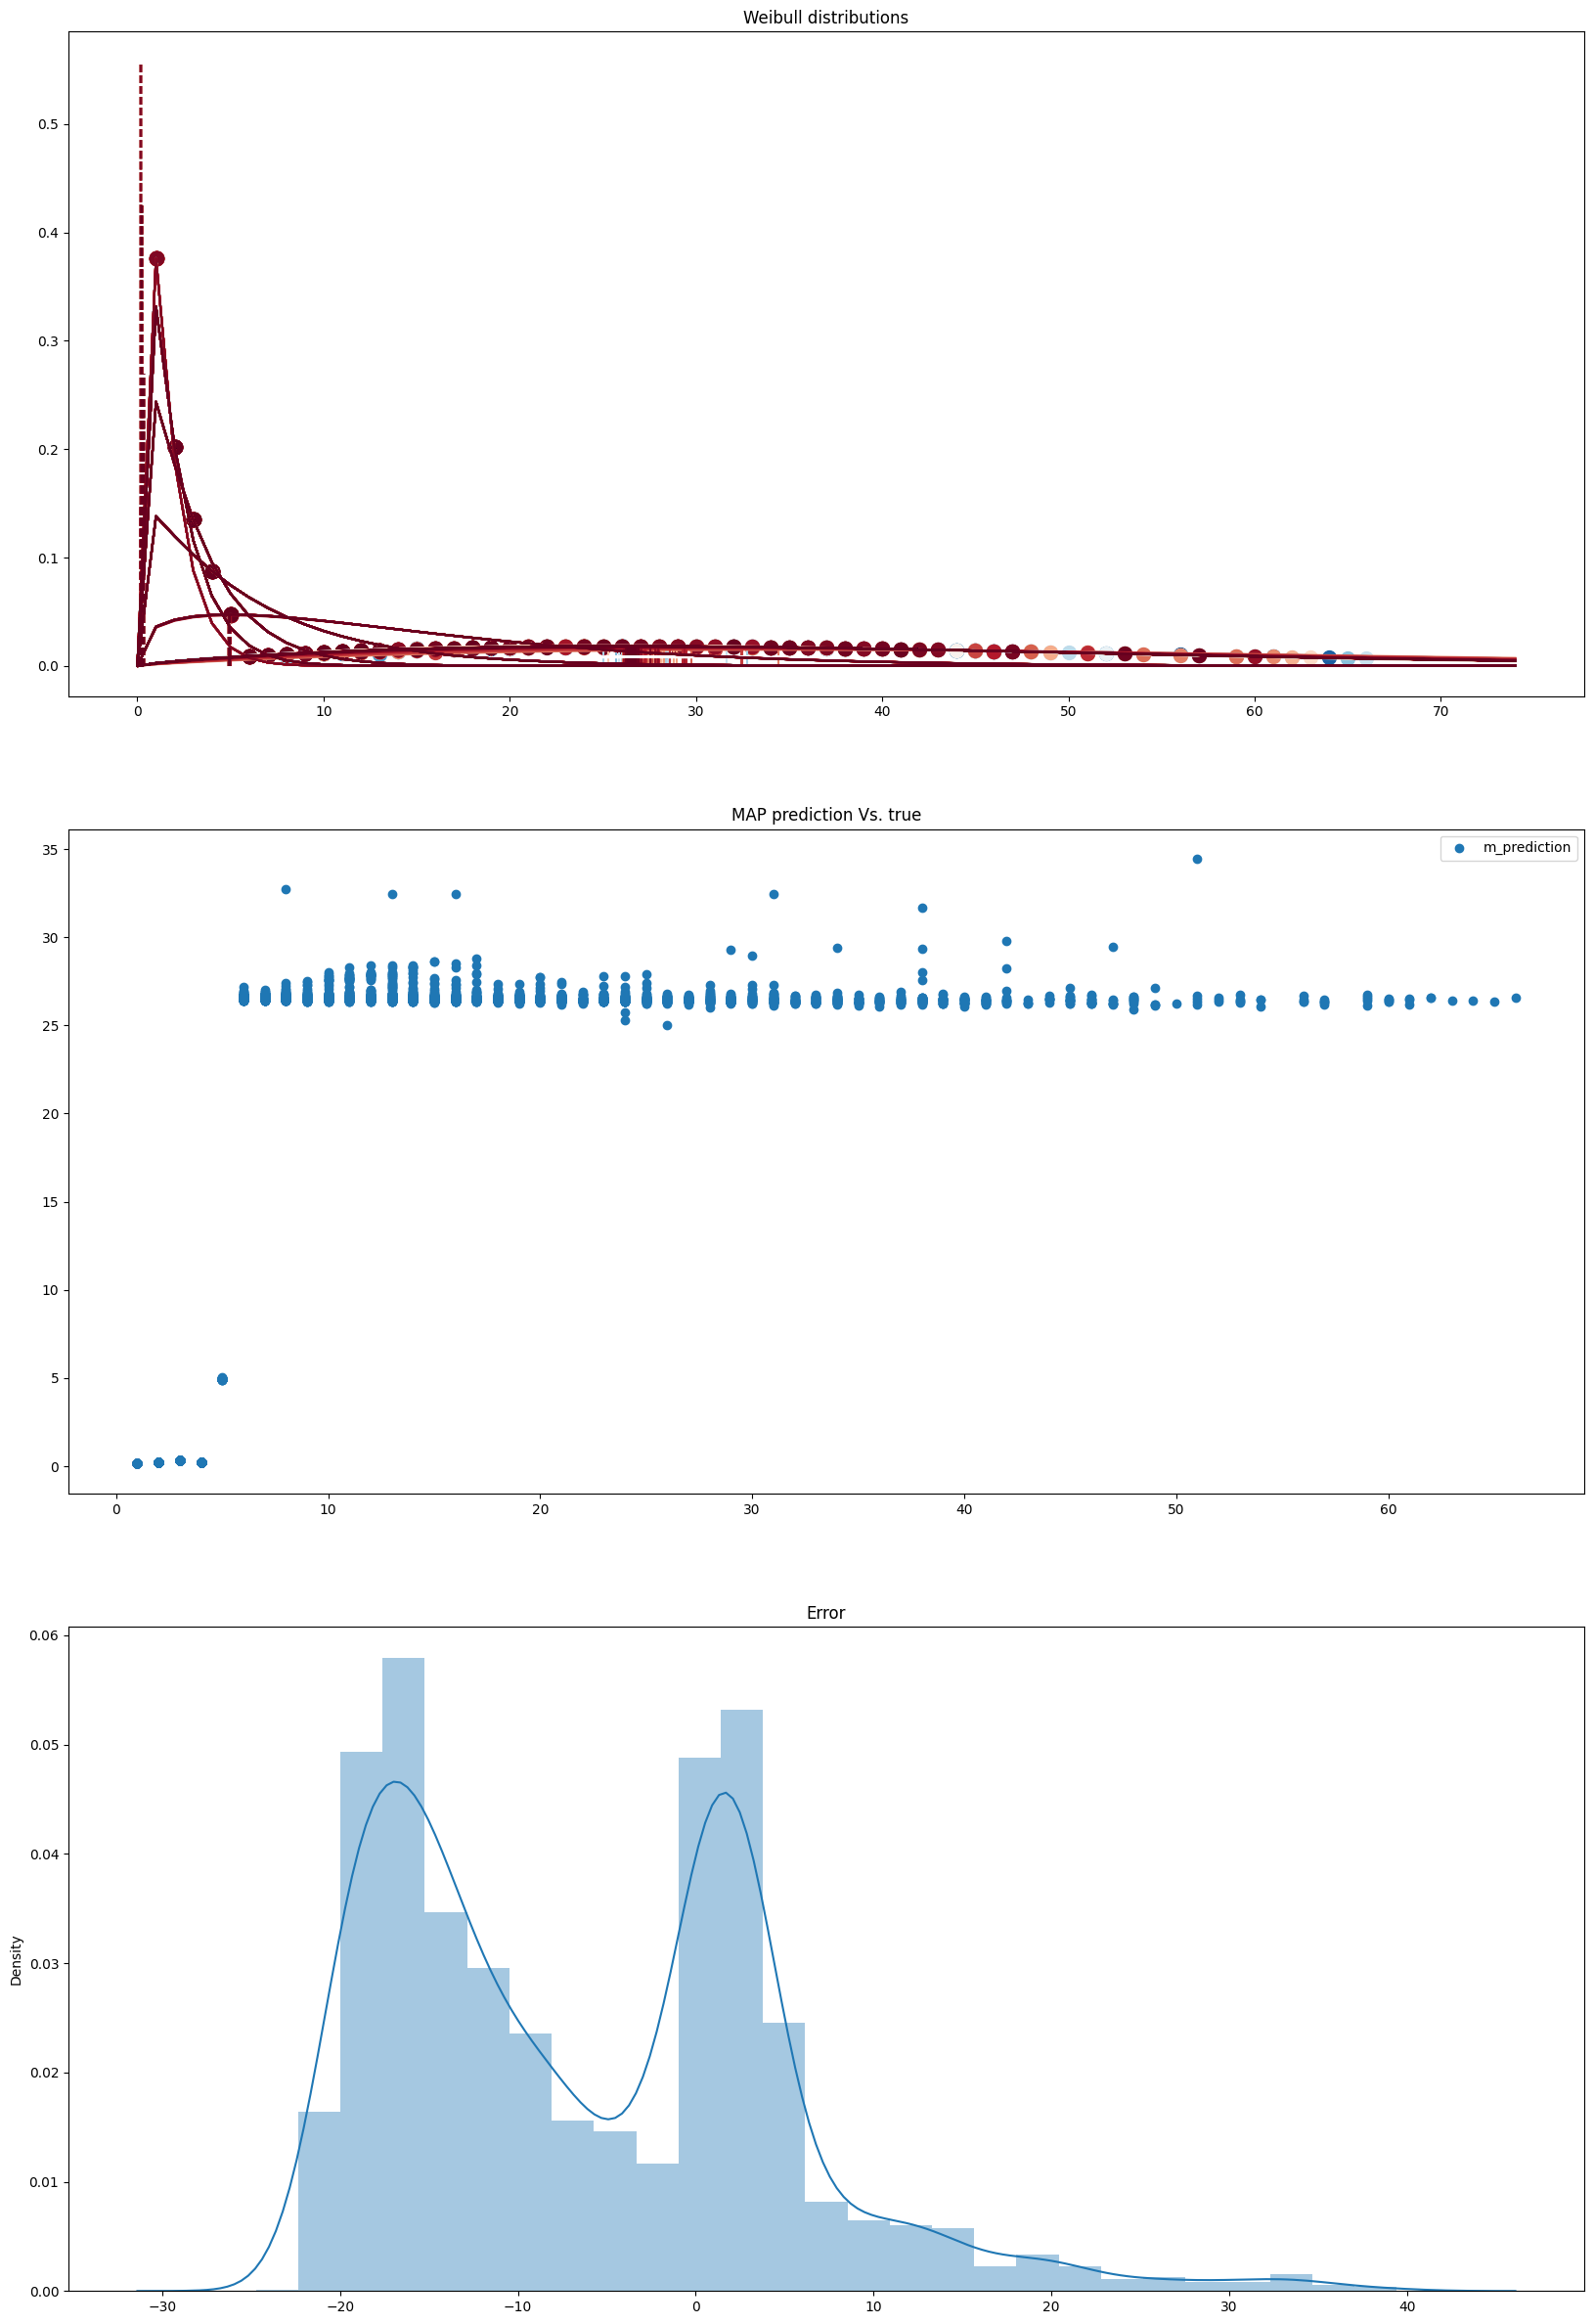

In [ ]:
plot_weibull_predictions(results_df=test_results_df)

Выводим графики распределения вероятности для среза пользователей

In [ ]:
def plot_weibull_prediction(id, results_df):

    t=np.arange(0,75)

    row=results_df[results_df['unit_number']==id]
    print(row)

    #for i, row in enumerate(results_df.iterrows()):
    alpha=row['alpha'].values[0]
    beta = row['beta'].values[0]
    T = row['T'].values[0]
    #label = 'a={} b={}'.format(alpha, beta)

    color = 'red'


    mode = weibull_mode(alpha, beta)

    y_max = weibull_pdf(alpha, beta, mode)

    plt.plot(t, weibull_pdf(alpha, beta, t), color=color)
    plt.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
    plt.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min


       T    E      alpha     beta  unit_number
11  13.0  1.0  44.850067  1.73466           12


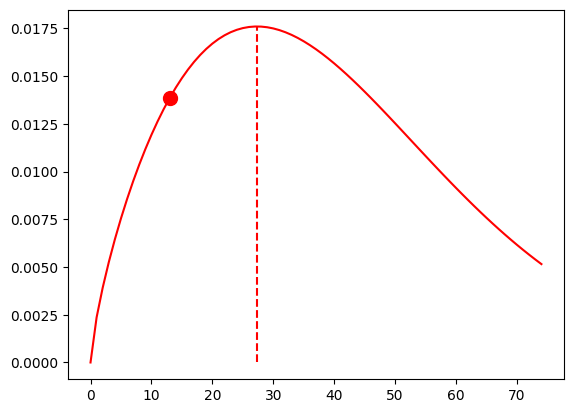

In [ ]:
#Вывод для 12го пользователя
plot_weibull_prediction(12,test_results_df)

       T    E      alpha      beta  unit_number
99  27.0  1.0  43.624878  1.726772          100


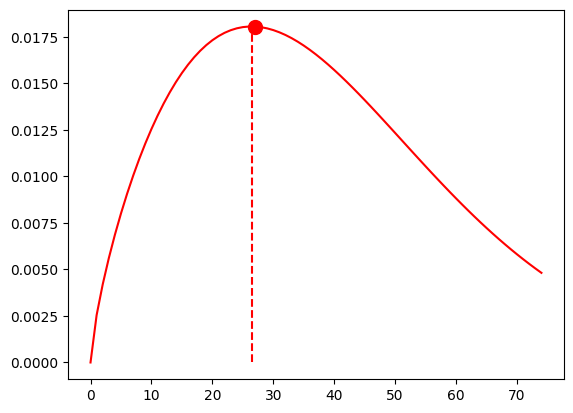

       T    E   alpha  beta  unit_number
100  2.0  1.0  1.9001   1.1          101


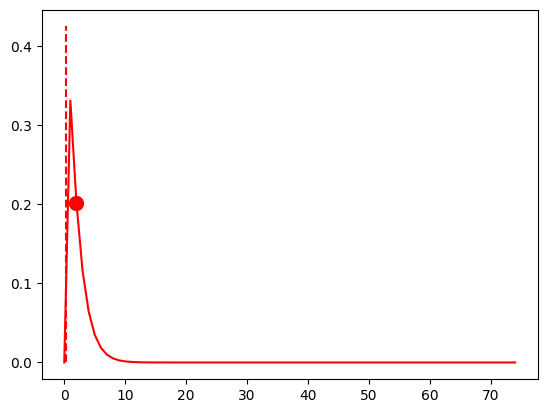

        T    E      alpha      beta  unit_number
101  19.0  1.0  43.940868  1.729125          102


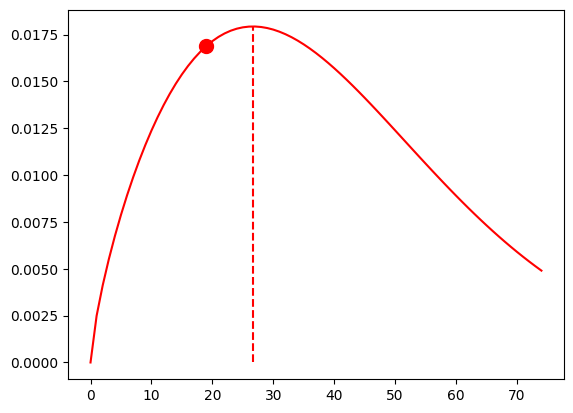

       T    E      alpha      beta  unit_number
102  8.0  1.0  43.902588  1.728659          103


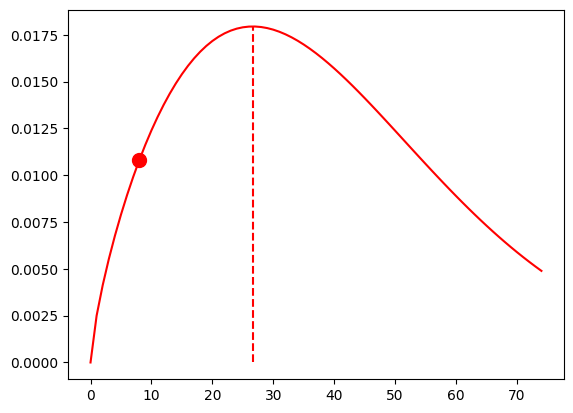

       T    E     alpha  beta  unit_number
103  3.0  1.0  2.998541   1.1          104


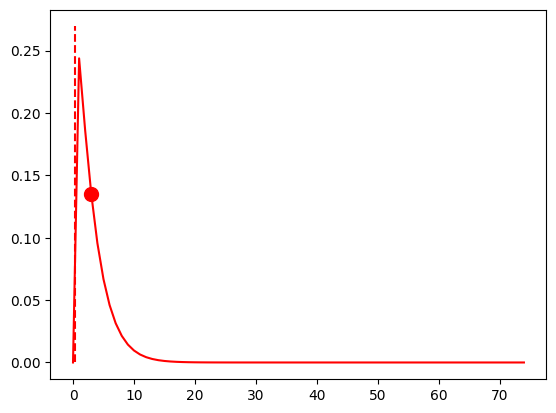

       T    E     alpha  beta  unit_number
104  2.0  1.0  1.900135   1.1          105


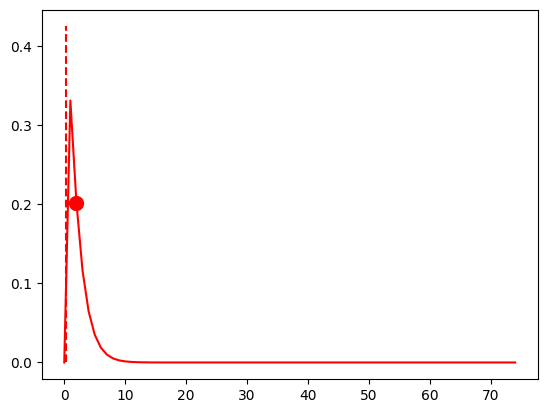

        T    E      alpha      beta  unit_number
105  27.0  1.0  43.572956  1.726543          106


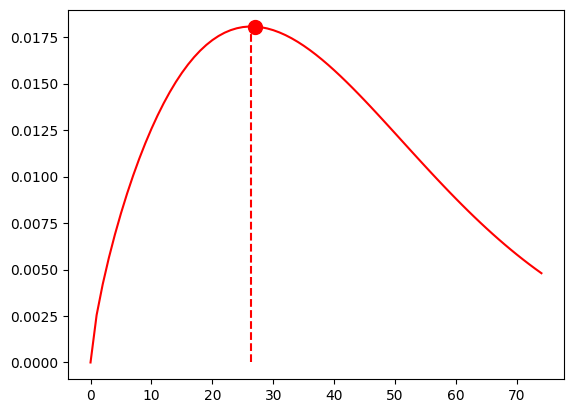

        T    E      alpha     beta  unit_number
106  14.0  1.0  43.698059  1.72732          107


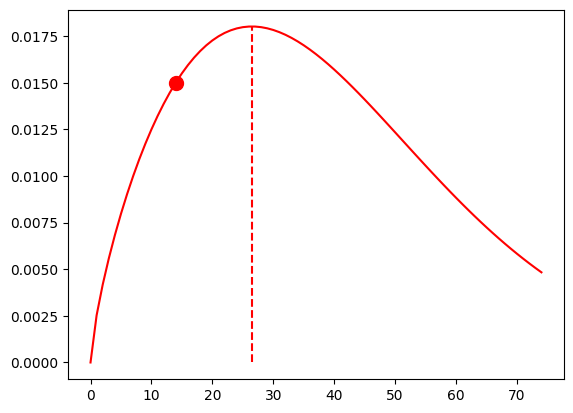

       T    E     alpha  beta  unit_number
107  2.0  1.0  1.899745   1.1          108


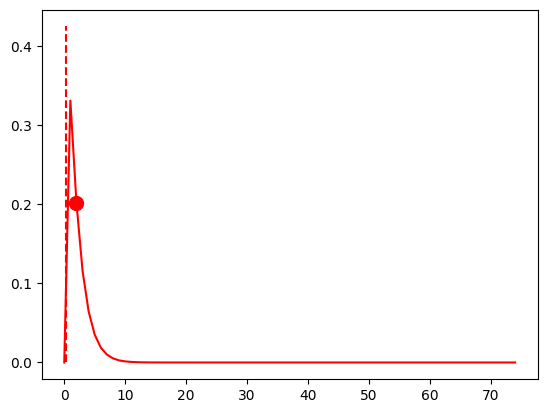

       T    E      alpha      beta  unit_number
108  6.0  1.0  43.950275  1.729254          109


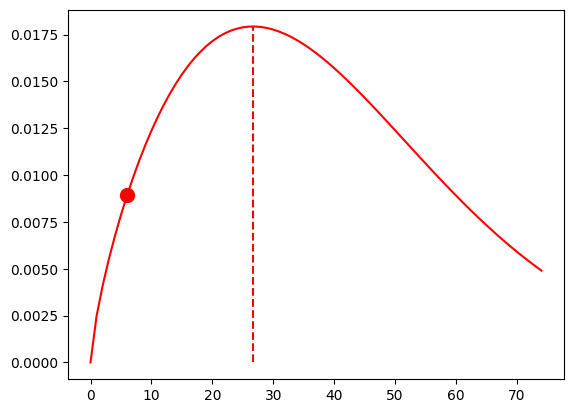

       T    E     alpha  beta  unit_number
109  3.0  1.0  3.001641   1.1          110


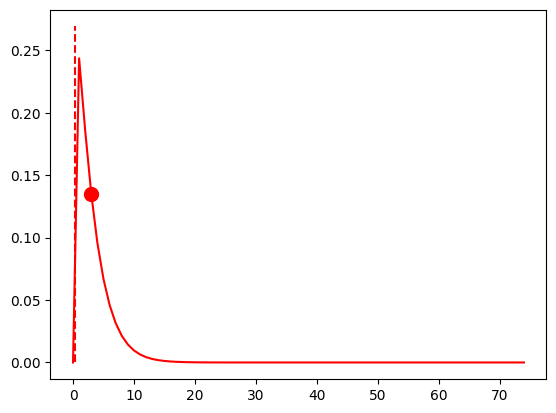

       T    E     alpha      beta  unit_number
110  5.0  1.0  15.51901  1.293603          111


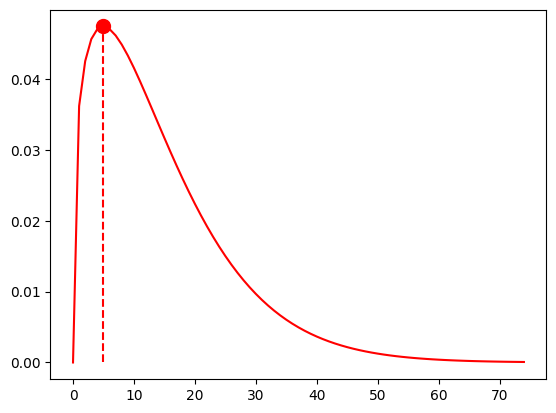

        T    E      alpha      beta  unit_number
111  25.0  1.0  44.048096  1.729385          112


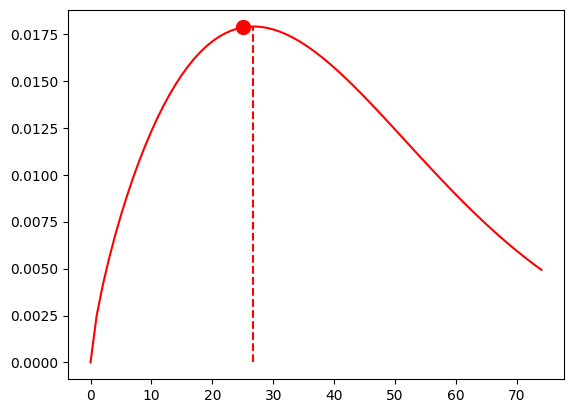

        T    E      alpha      beta  unit_number
112  18.0  1.0  44.855099  1.736054          113


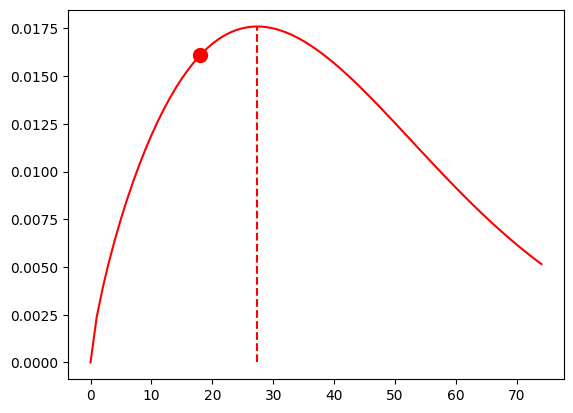

       T    E      alpha      beta  unit_number
113  8.0  1.0  43.617466  1.727104          114


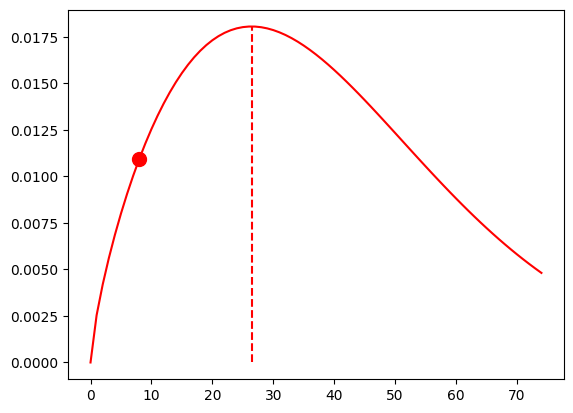

       T    E     alpha      beta  unit_number
114  4.0  1.0  6.036578  1.030849          115


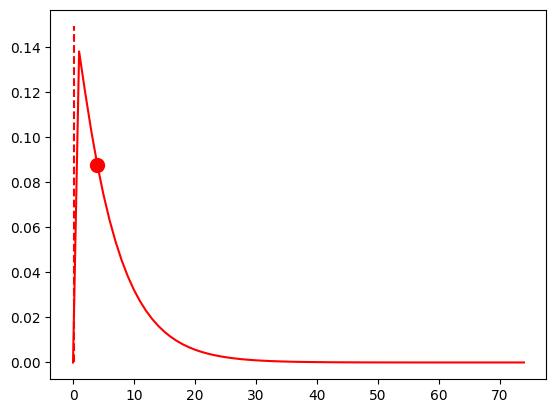

        T    E      alpha      beta  unit_number
115  14.0  1.0  44.617268  1.732776          116


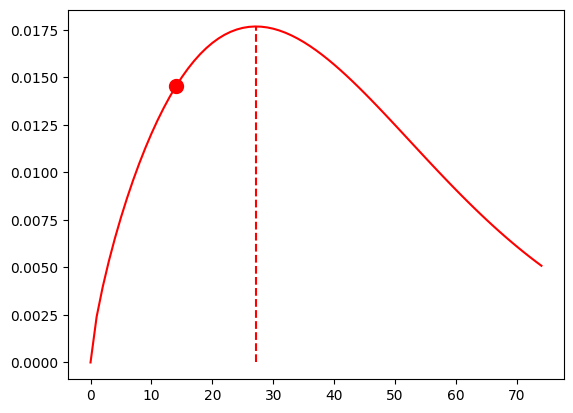

        T    E      alpha      beta  unit_number
116  46.0  1.0  43.413513  1.725645          117


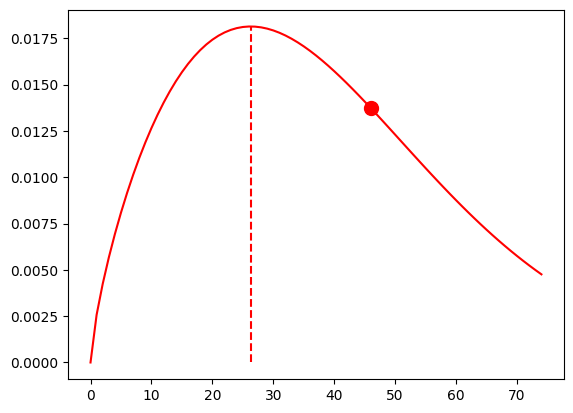

        T    E      alpha      beta  unit_number
117  23.0  1.0  43.534111  1.726524          118


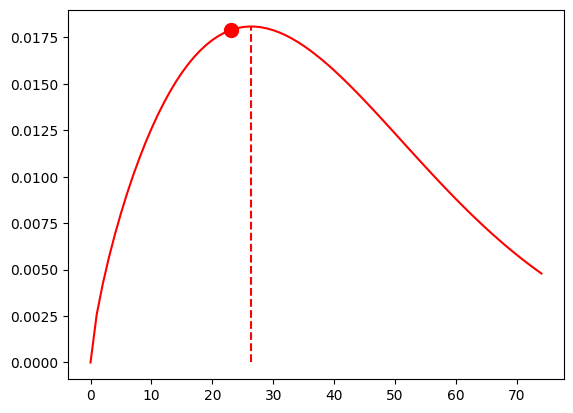

        T    E      alpha      beta  unit_number
118  12.0  1.0  43.826801  1.728395          119


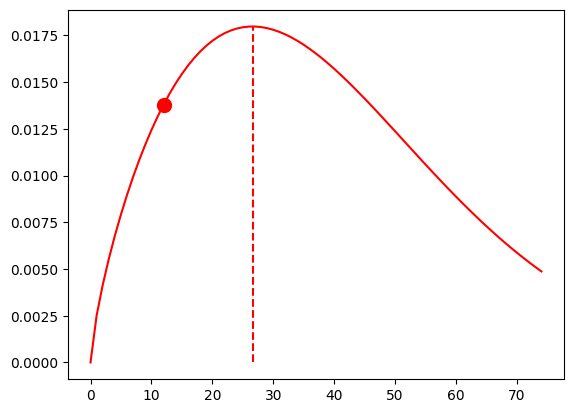

       T    E     alpha  beta  unit_number
119  1.0  1.0  1.448839   1.1          120


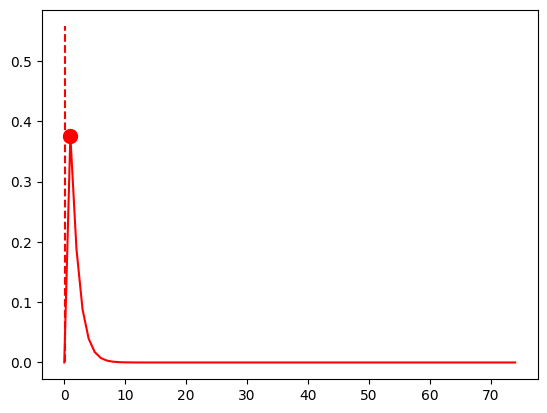

        T    E      alpha      beta  unit_number
120  11.0  1.0  43.608768  1.727125          121


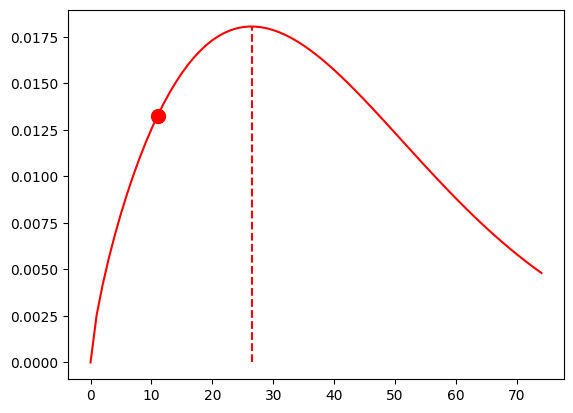

        T    E      alpha      beta  unit_number
121  15.0  1.0  43.997242  1.729254          122


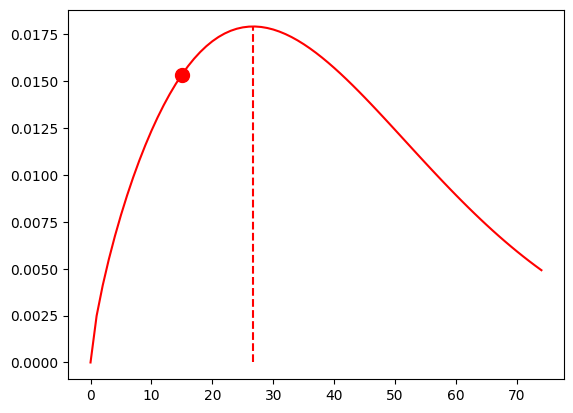

        T    E      alpha      beta  unit_number
122  15.0  1.0  43.984783  1.729079          123


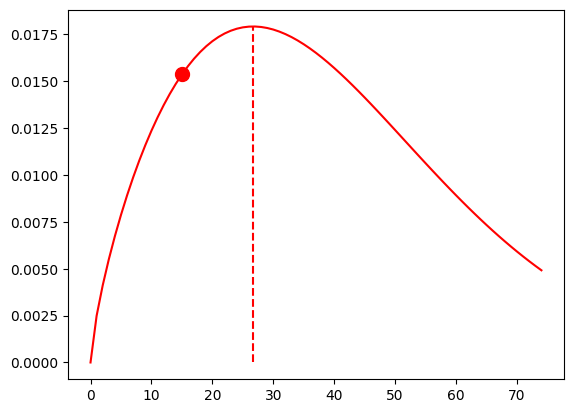

        T    E      alpha      beta  unit_number
123  45.0  1.0  43.593925  1.727209          124


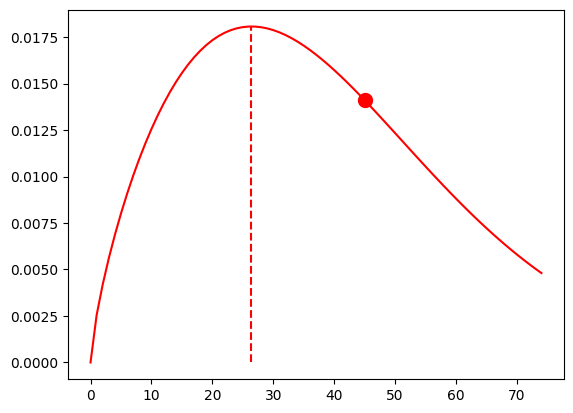

       T    E     alpha  beta  unit_number
124  1.0  1.0  1.448839   1.1          125


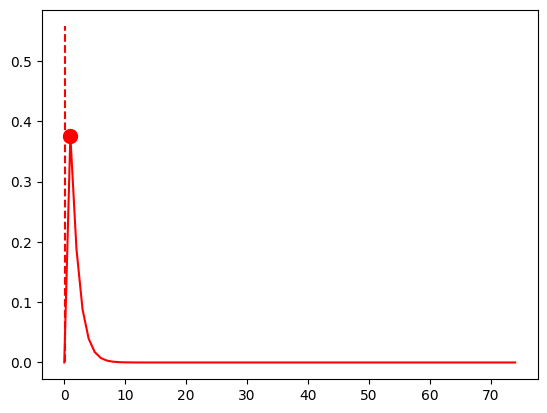

       T    E     alpha  beta  unit_number
125  3.0  1.0  3.003948   1.1          126


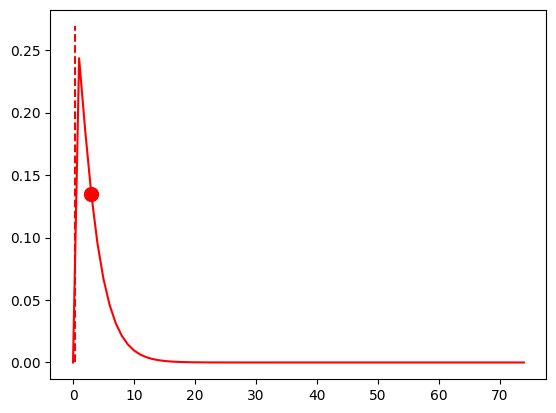

       T    E     alpha      beta  unit_number
126  8.0  1.0  43.90662  1.728867          127


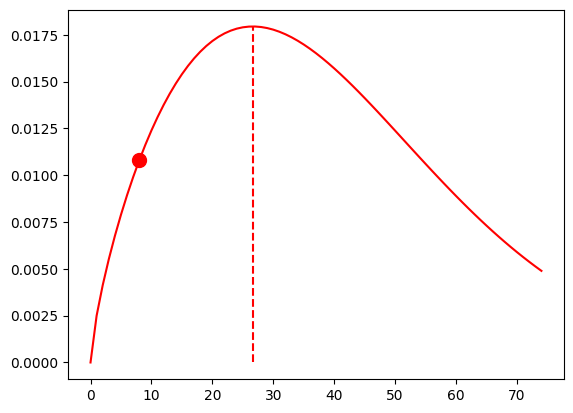

       T    E     alpha  beta  unit_number
127  1.0  1.0  1.448839   1.1          128


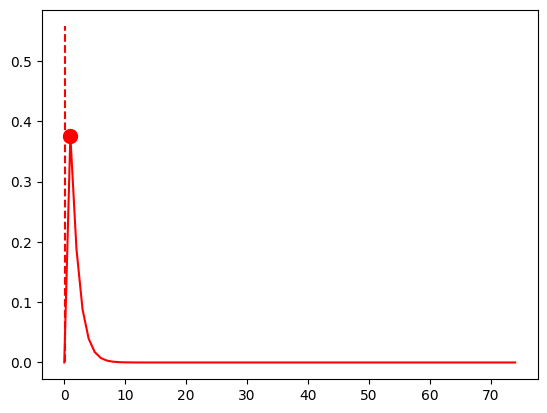

        T    E      alpha      beta  unit_number
128  61.0  1.0  43.779053  1.727776          129


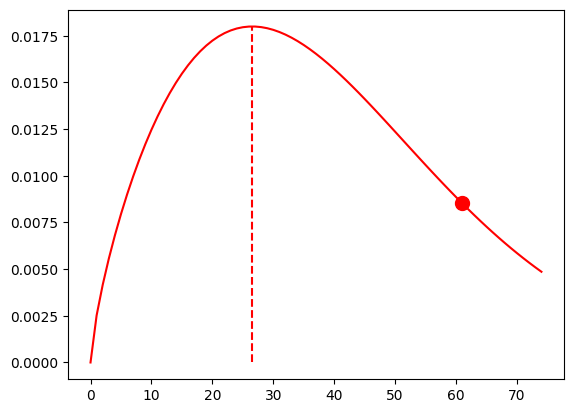

        T    E      alpha      beta  unit_number
129  20.0  1.0  43.994743  1.729213          130


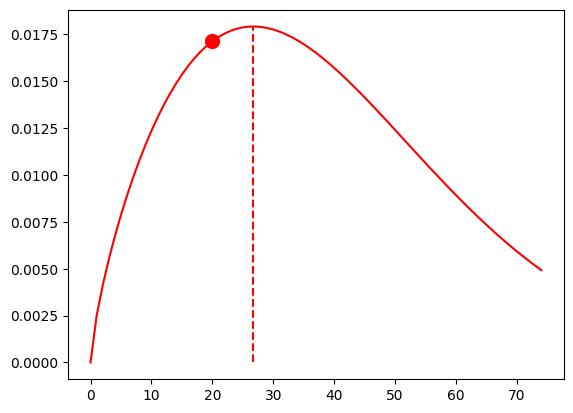

       T    E     alpha  beta  unit_number
130  2.0  1.0  1.899591   1.1          131


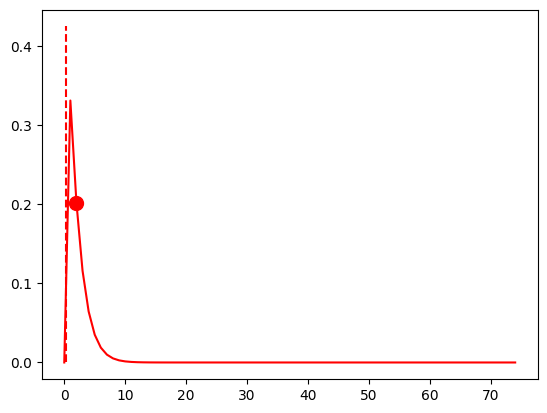

       T    E      alpha     beta  unit_number
131  5.0  1.0  15.515827  1.29343          132


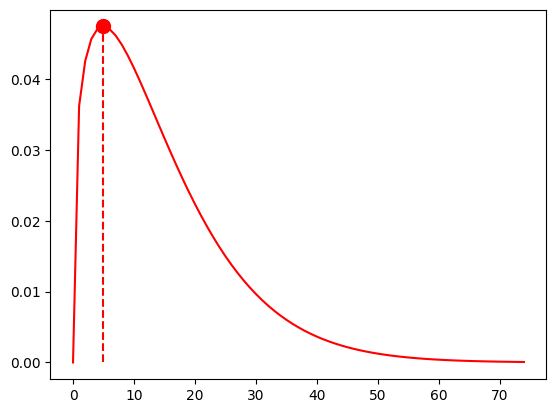

       T    E     alpha  beta  unit_number
132  3.0  1.0  2.999494   1.1          133


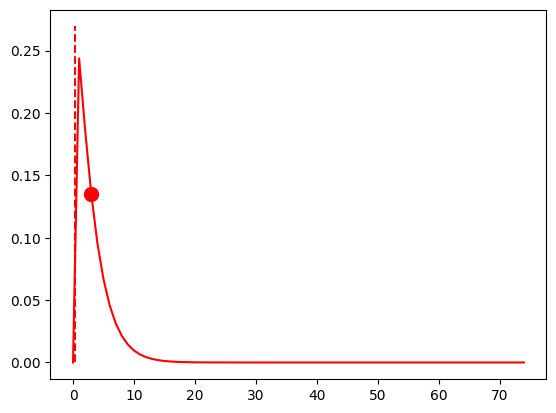

       T    E      alpha      beta  unit_number
133  8.0  1.0  43.665325  1.727289          134


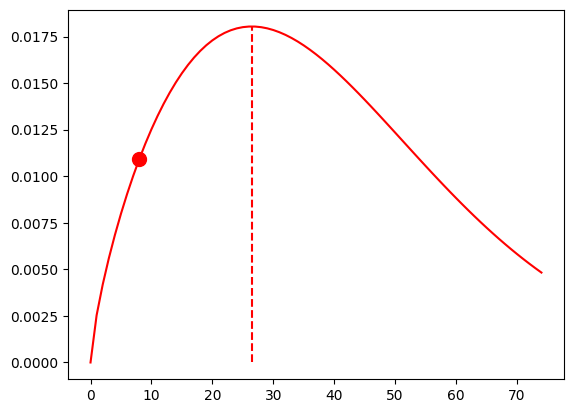

        T    E      alpha      beta  unit_number
134  11.0  1.0  43.632931  1.727213          135


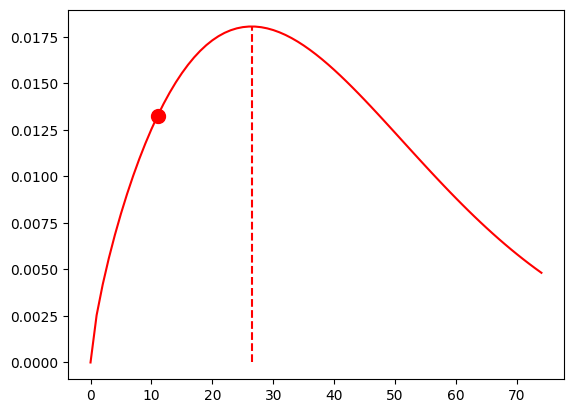

        T    E      alpha      beta  unit_number
135  32.0  1.0  43.572697  1.726865          136


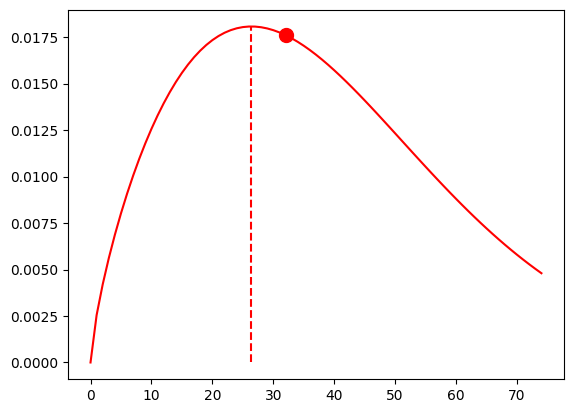

        T    E      alpha      beta  unit_number
136  20.0  1.0  45.379787  1.738041          137


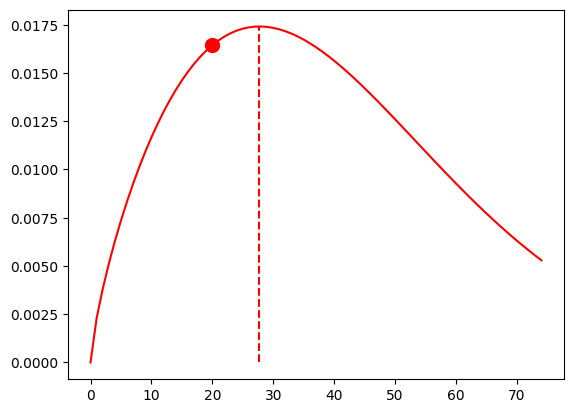

        T    E     alpha      beta  unit_number
137  38.0  1.0  43.41048  1.725634          138


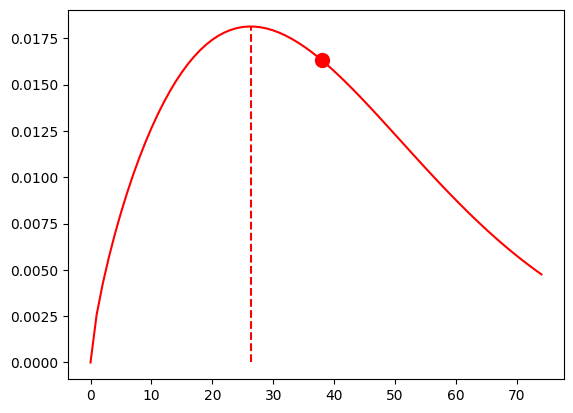

        T    E      alpha      beta  unit_number
138  15.0  1.0  43.586277  1.726756          139


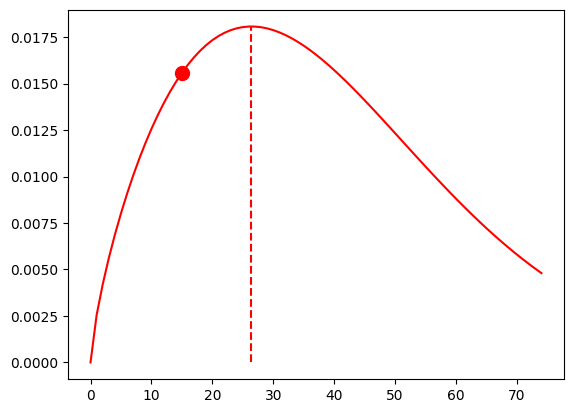

       T    E     alpha  beta  unit_number
139  1.0  1.0  1.448839   1.1          140


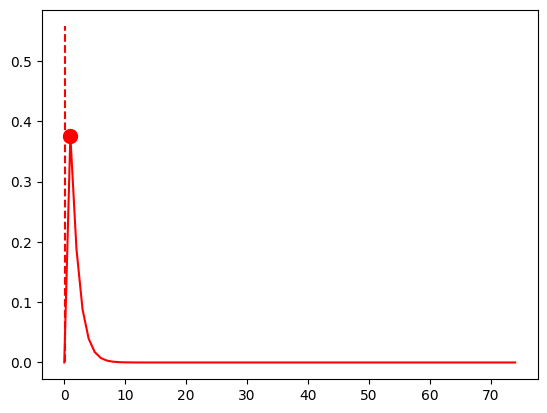

       T    E     alpha  beta  unit_number
140  3.0  1.0  2.998239   1.1          141


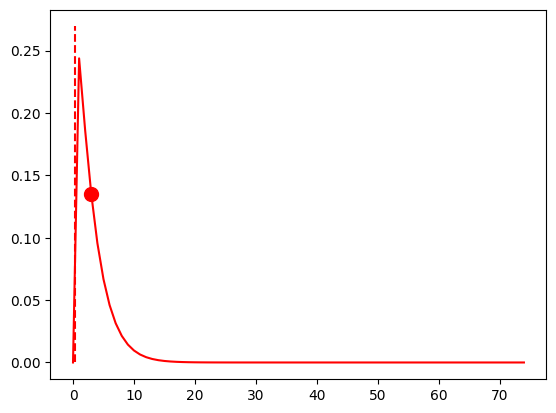

        T    E      alpha      beta  unit_number
141  14.0  1.0  43.505505  1.726526          142


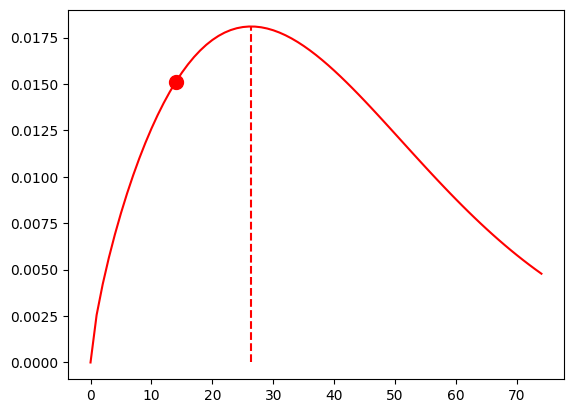

        T    E      alpha      beta  unit_number
142  28.0  1.0  43.354267  1.725593          143


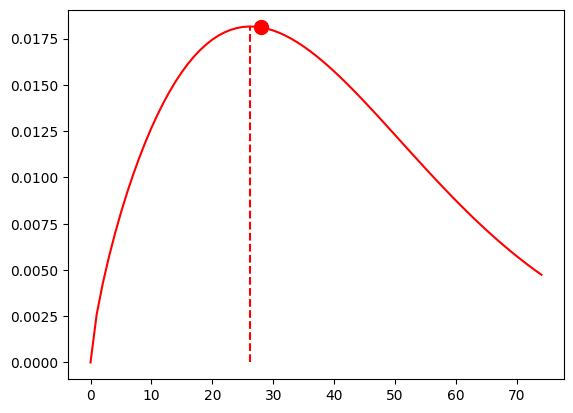

        T    E      alpha      beta  unit_number
143  23.0  1.0  43.532501  1.726564          144


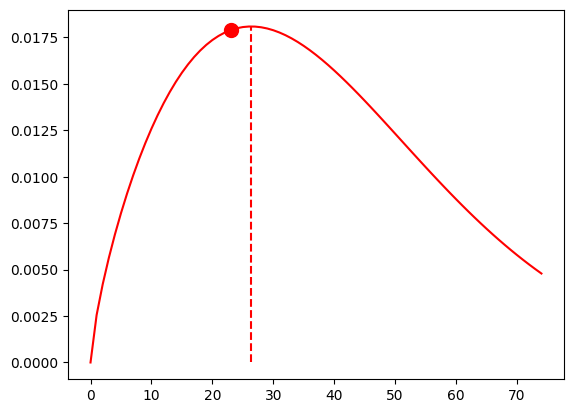

       T    E      alpha      beta  unit_number
144  7.0  1.0  43.925606  1.728745          145


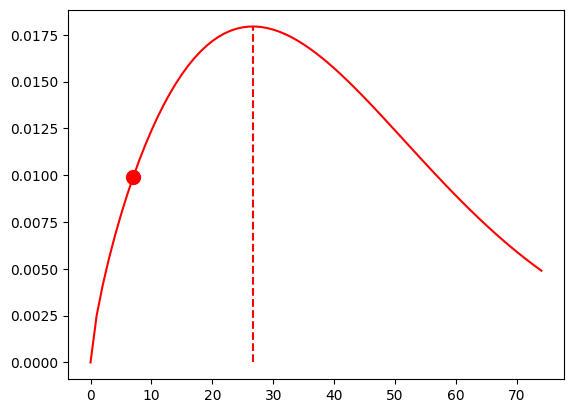

        T    E      alpha      beta  unit_number
145  26.0  1.0  43.646248  1.727319          146


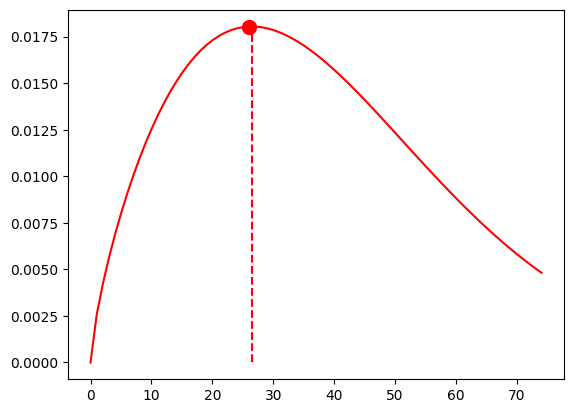

        T    E      alpha      beta  unit_number
146  15.0  1.0  44.155659  1.729653          147


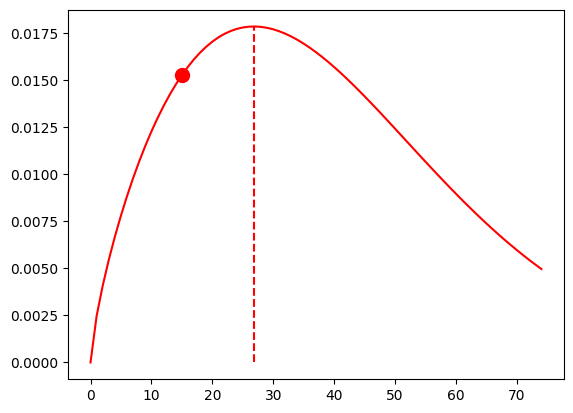

        T    E      alpha      beta  unit_number
147  11.0  1.0  43.802601  1.728196          148


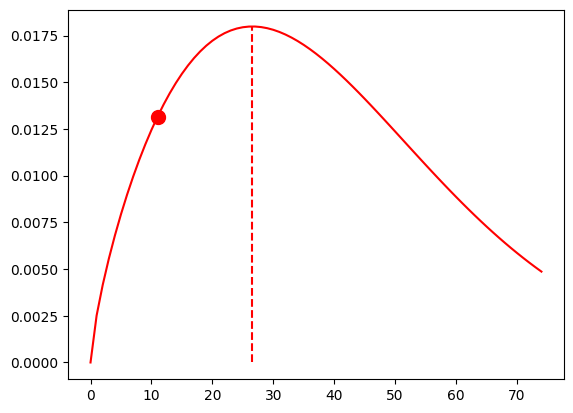

        T    E      alpha      beta  unit_number
148  27.0  1.0  43.816654  1.727877          149


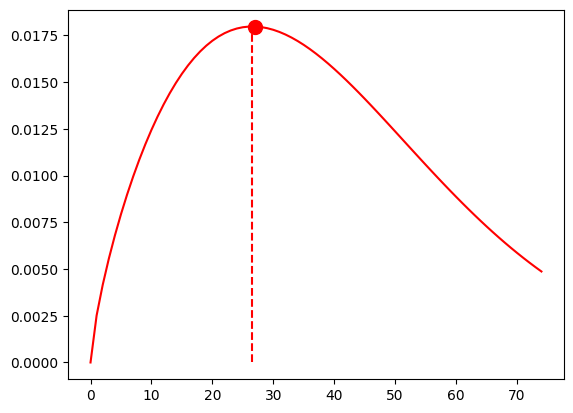

        T    E      alpha      beta  unit_number
149  56.0  1.0  43.969433  1.729038          150


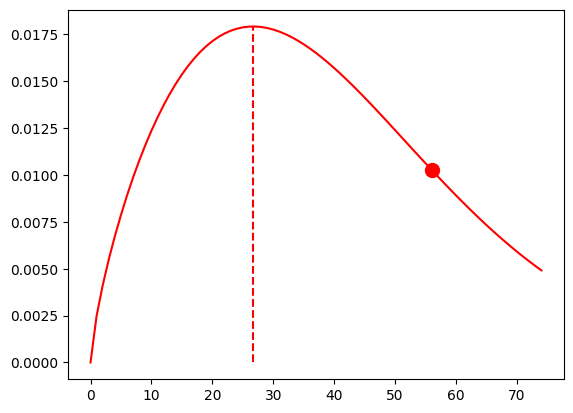

        T    E      alpha      beta  unit_number
150  16.0  1.0  43.590214  1.726816          151


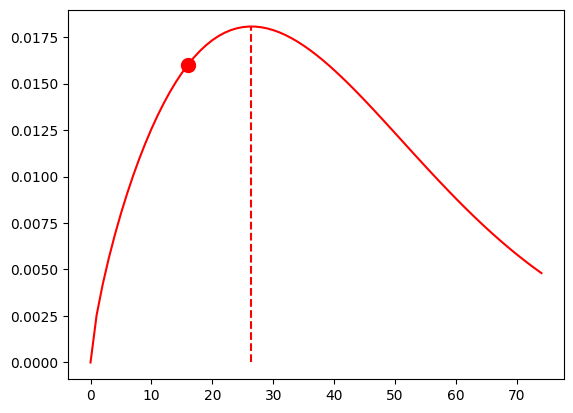

        T    E      alpha      beta  unit_number
151  13.0  1.0  43.869766  1.727965          152


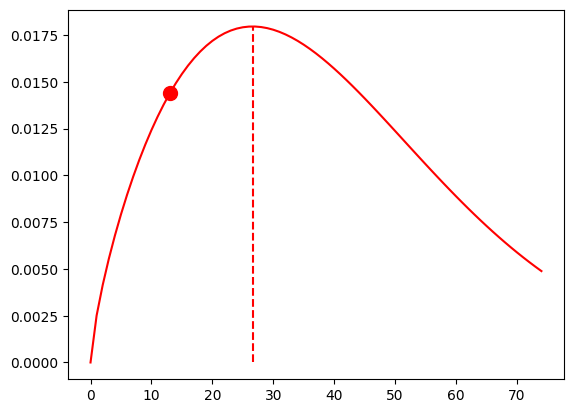

        T    E      alpha      beta  unit_number
152  10.0  1.0  43.777092  1.727804          153


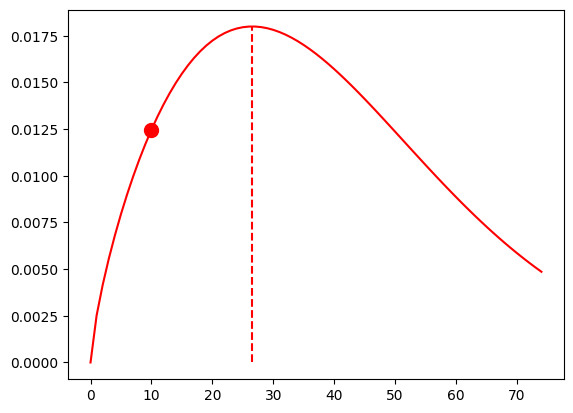

       T    E      alpha      beta  unit_number
153  6.0  1.0  43.826519  1.728012          154


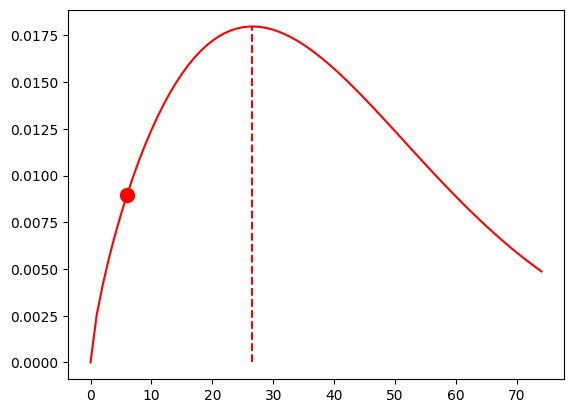

        T    E      alpha     beta  unit_number
154  10.0  1.0  43.664711  1.72727          155


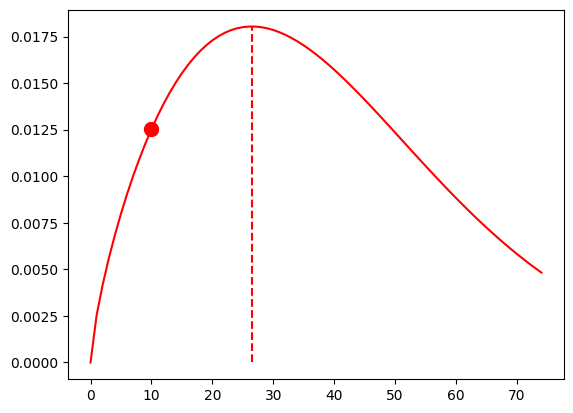

        T    E      alpha      beta  unit_number
155  24.0  1.0  43.818012  1.728119          156


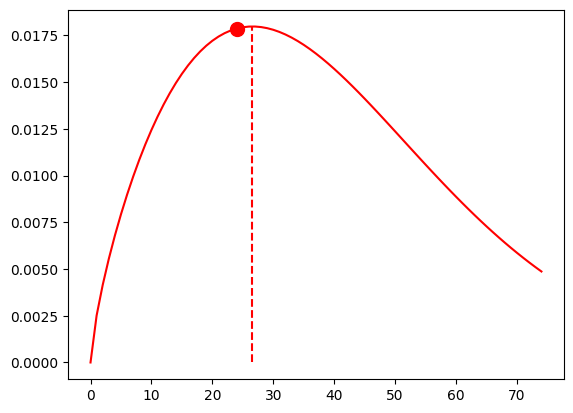

        T    E      alpha      beta  unit_number
156  31.0  1.0  43.512764  1.726456          157


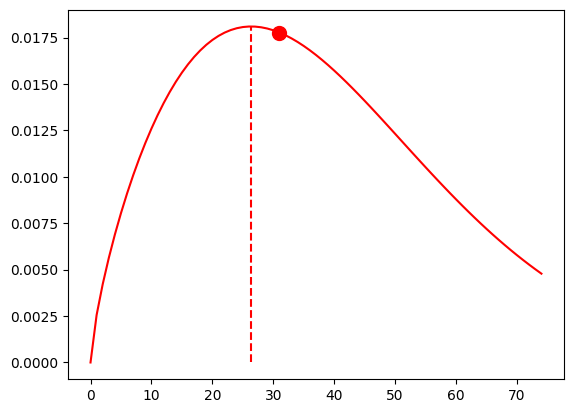

       T    E      alpha      beta  unit_number
157  8.0  1.0  43.660736  1.727686          158


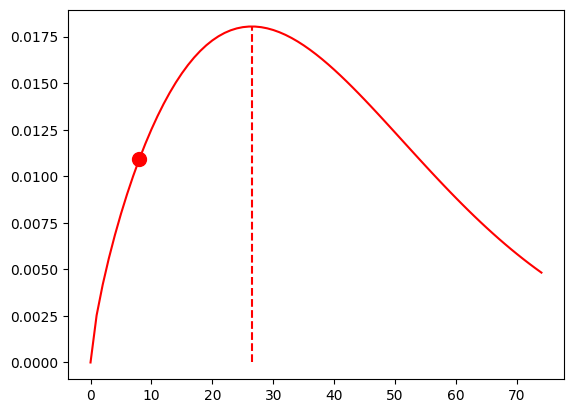

       T    E      alpha      beta  unit_number
158  9.0  1.0  43.606865  1.726877          159


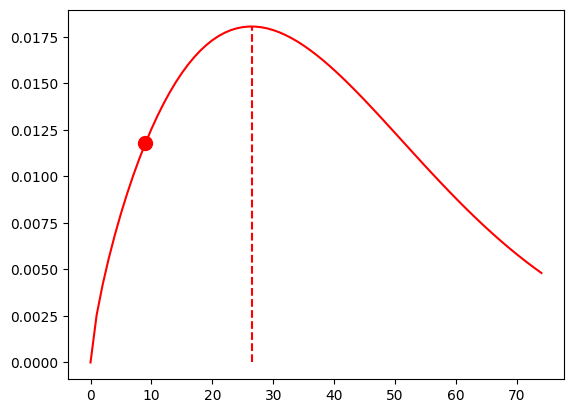

        T    E      alpha      beta  unit_number
159  12.0  1.0  43.751781  1.727403          160


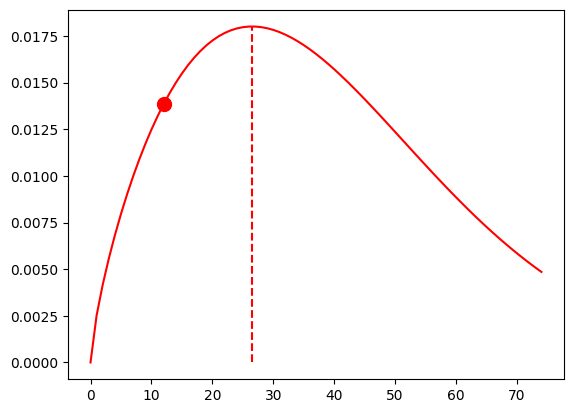

        T    E      alpha      beta  unit_number
160  13.0  1.0  44.065083  1.729296          161


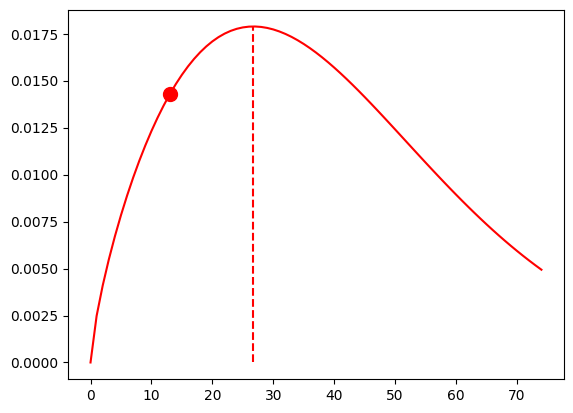

        T    E      alpha      beta  unit_number
161  38.0  1.0  43.831146  1.728298          162


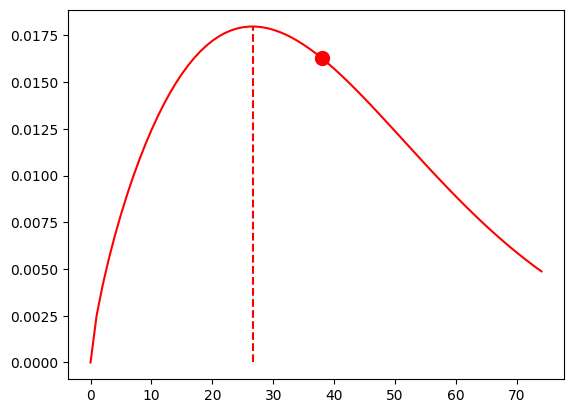

        T    E      alpha      beta  unit_number
162  13.0  1.0  44.093636  1.729412          163


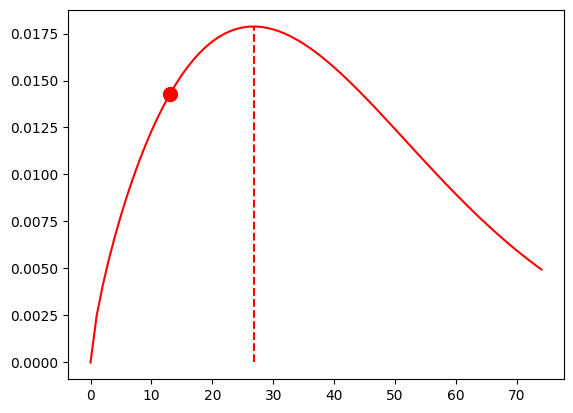

        T    E      alpha     beta  unit_number
163  11.0  1.0  43.598728  1.72676          164


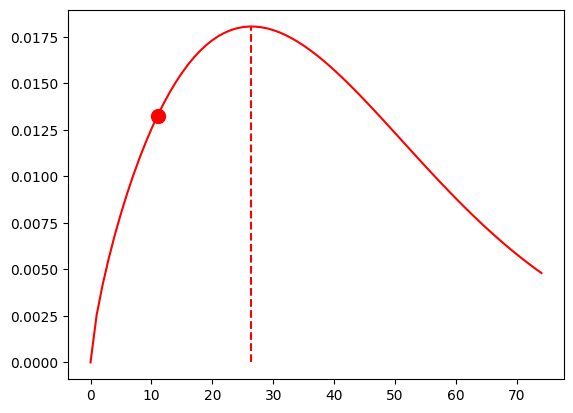

       T    E      alpha      beta  unit_number
164  5.0  1.0  15.602521  1.294265          165


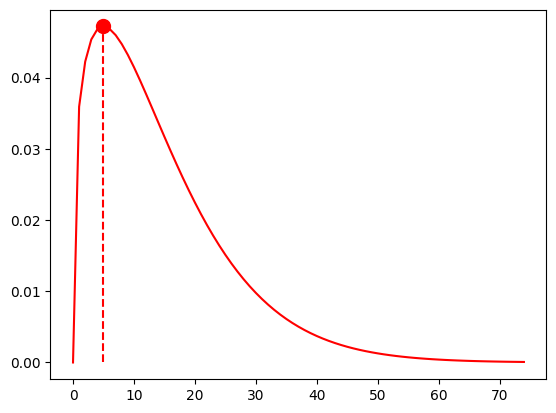

        T    E      alpha      beta  unit_number
165  11.0  1.0  43.839508  1.728451          166


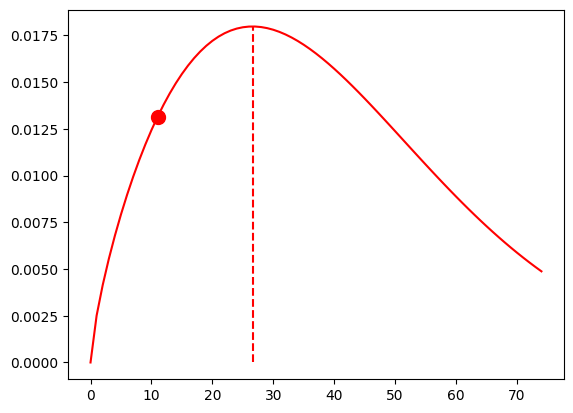

        T    E      alpha      beta  unit_number
166  37.0  1.0  44.297424  1.730733          167


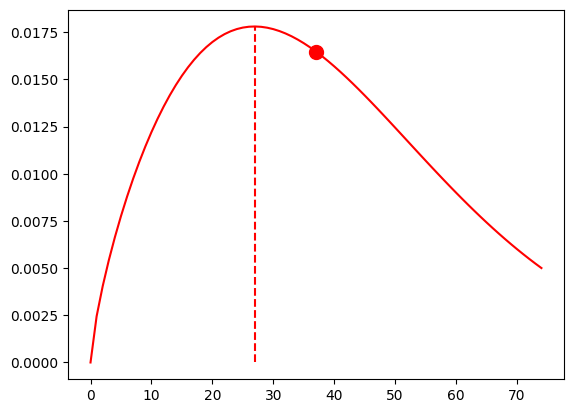

       T    E     alpha  beta  unit_number
167  2.0  1.0  1.899839   1.1          168


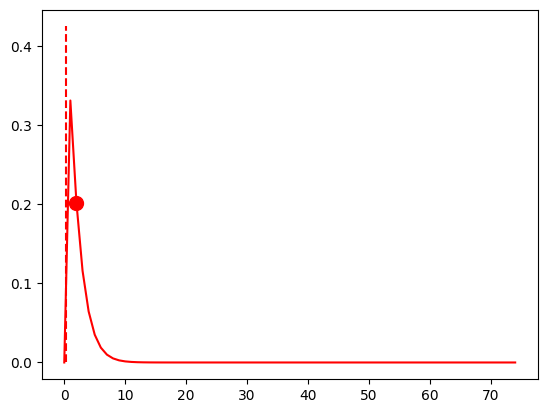

        T    E      alpha      beta  unit_number
168  39.0  1.0  44.013977  1.729239          169


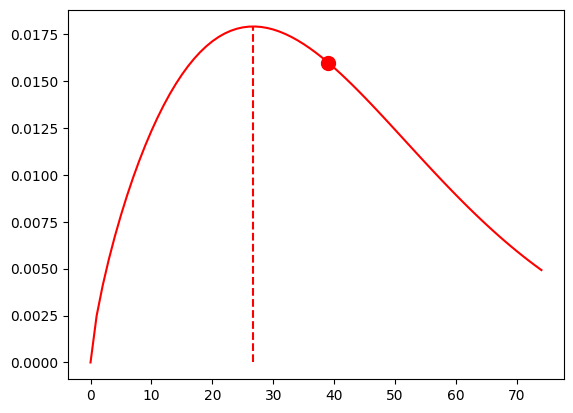

       T    E     alpha      beta  unit_number
169  4.0  1.0  6.039261  1.030768          170


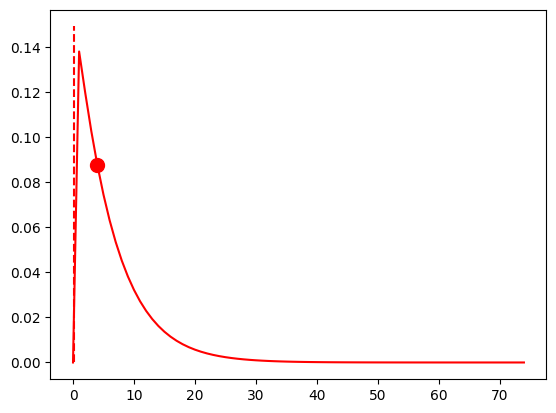

        T    E      alpha      beta  unit_number
170  25.0  1.0  43.670555  1.727101          171


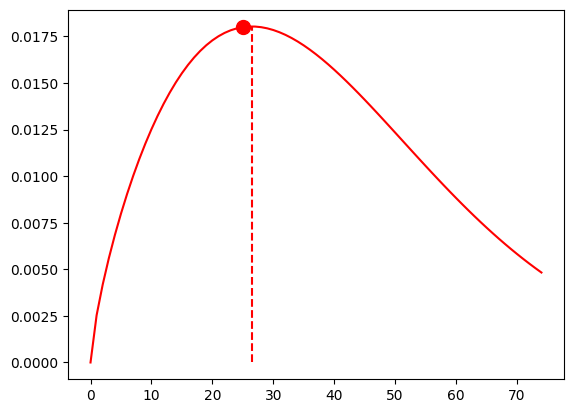

        T    E      alpha      beta  unit_number
171  19.0  1.0  44.868244  1.734485          172


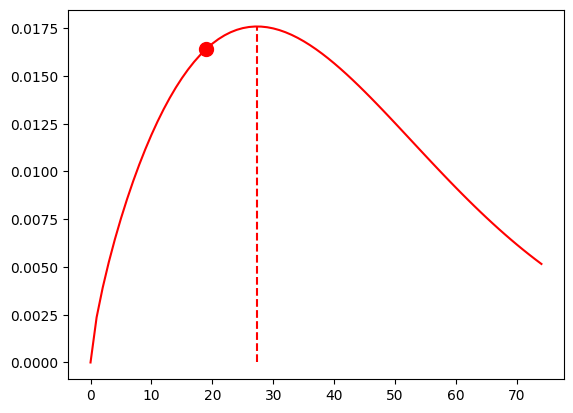

        T    E      alpha     beta  unit_number
172  16.0  1.0  43.688965  1.72714          173


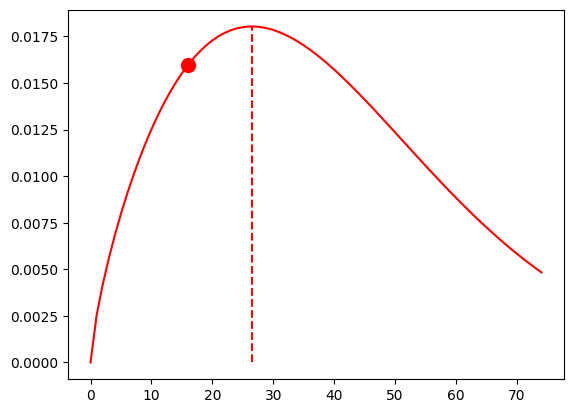

        T    E     alpha      beta  unit_number
173  24.0  1.0  43.55809  1.726688          174


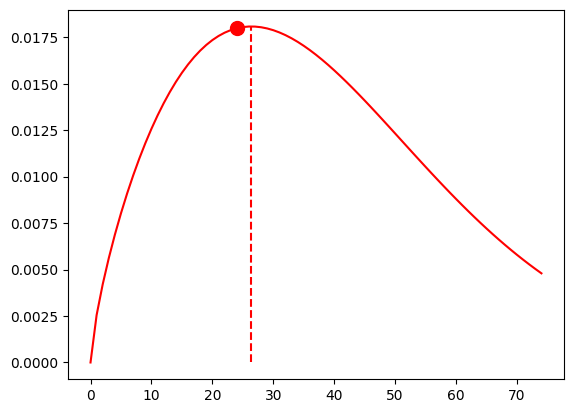

       T    E      alpha      beta  unit_number
174  7.0  1.0  43.869423  1.728615          175


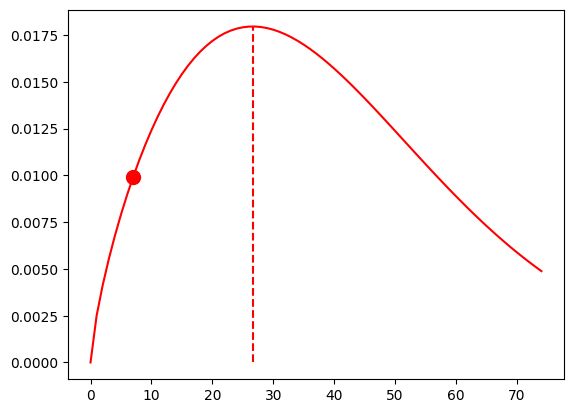

        T    E      alpha     beta  unit_number
175  27.0  1.0  43.483437  1.72623          176


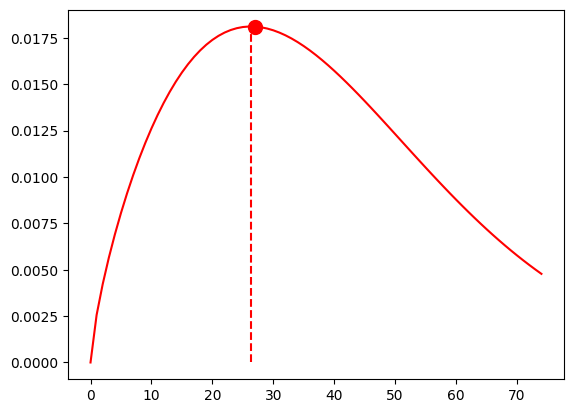

       T    E      alpha      beta  unit_number
176  5.0  1.0  15.505234  1.293621          177


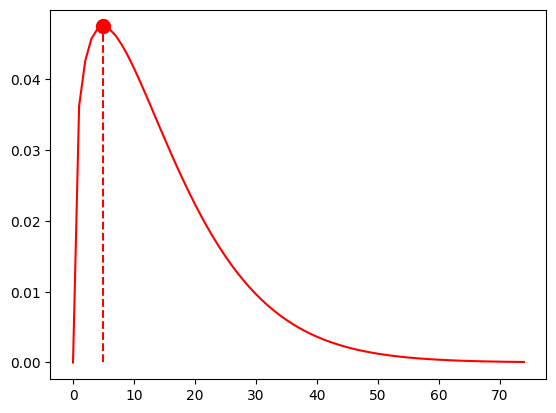

       T    E      alpha      beta  unit_number
177  9.0  1.0  43.525444  1.726576          178


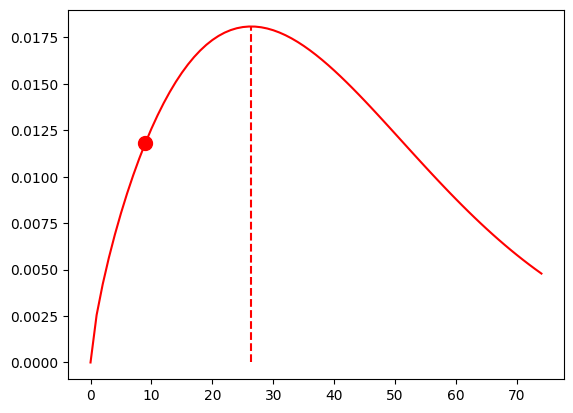

       T    E     alpha  beta  unit_number
178  1.0  1.0  1.448839   1.1          179


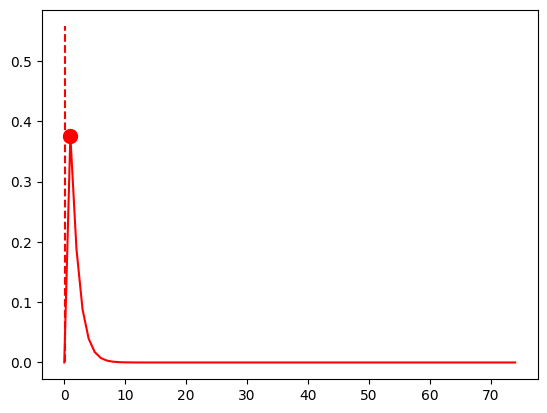

        T    E      alpha      beta  unit_number
179  19.0  1.0  43.607159  1.726669          180


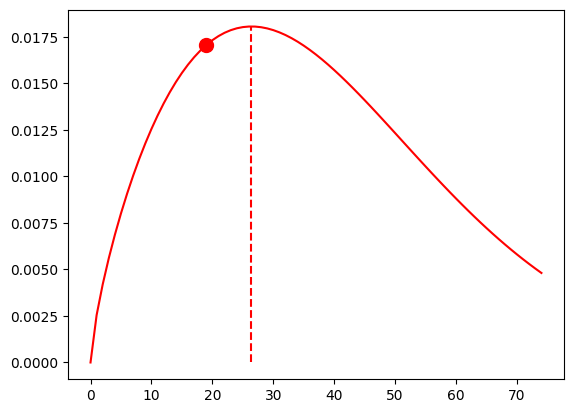

       T    E     alpha  beta  unit_number
180  3.0  1.0  3.004414   1.1          181


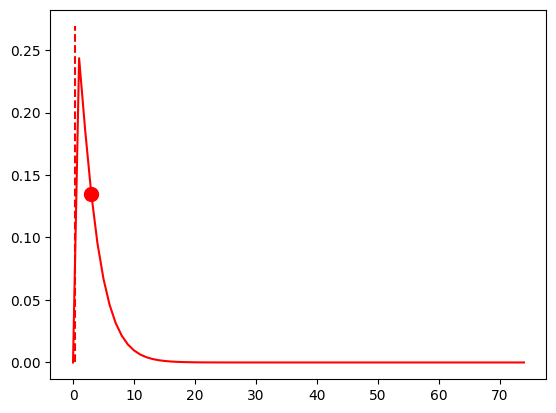

        T    E      alpha      beta  unit_number
181  16.0  1.0  43.974319  1.729035          182


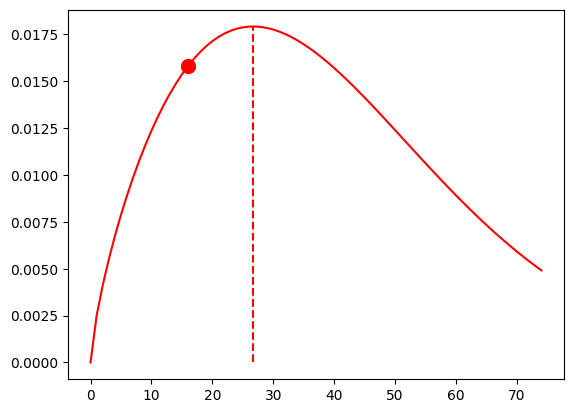

       T    E     alpha      beta  unit_number
182  4.0  1.0  6.048423  1.030973          183


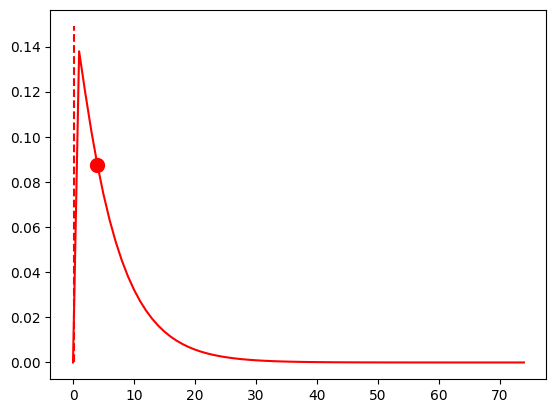

        T    E      alpha      beta  unit_number
183  28.0  1.0  43.641762  1.727126          184


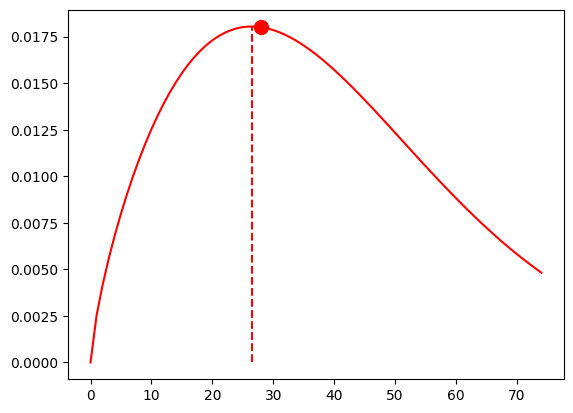

       T    E     alpha  beta  unit_number
184  1.0  1.0  1.448839   1.1          185


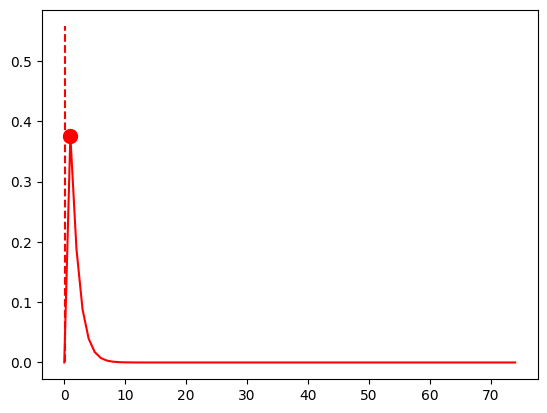

        T    E     alpha      beta  unit_number
185  22.0  1.0  43.58213  1.726854          186


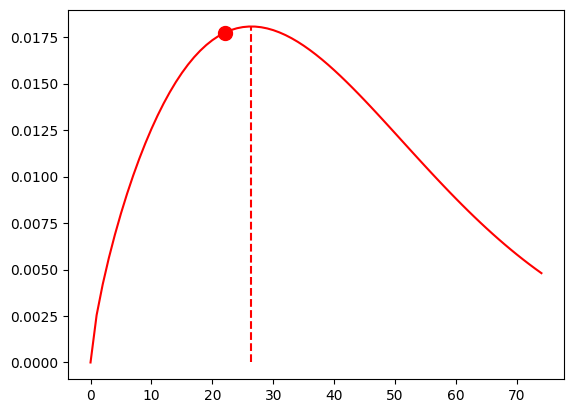

       T    E      alpha      beta  unit_number
186  9.0  1.0  43.686047  1.727525          187


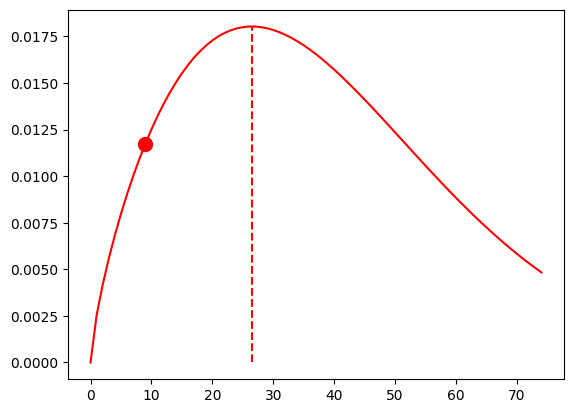

       T    E     alpha  beta  unit_number
187  1.0  1.0  1.448839   1.1          188


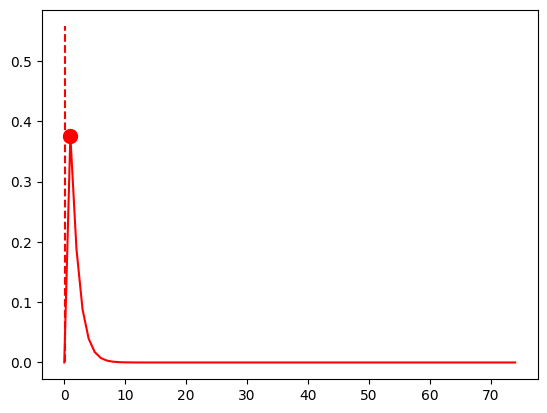

        T    E      alpha      beta  unit_number
188  15.0  1.0  43.474792  1.726404          189


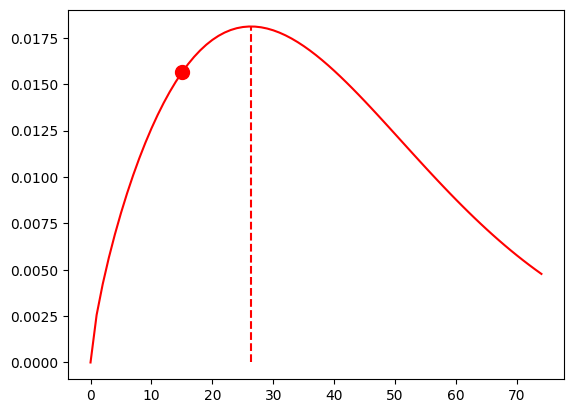

       T    E      alpha      beta  unit_number
189  6.0  1.0  43.726135  1.727753          190


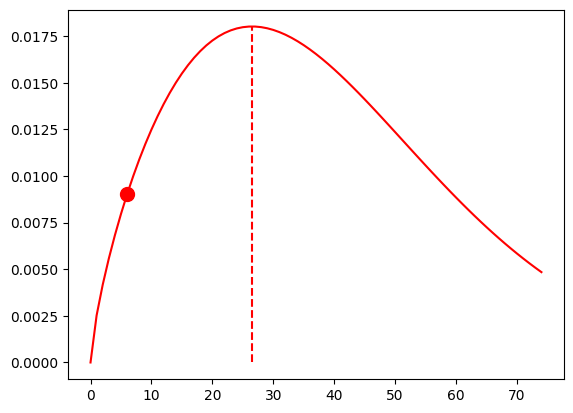

        T    E      alpha      beta  unit_number
190  17.0  1.0  44.234856  1.730321          191


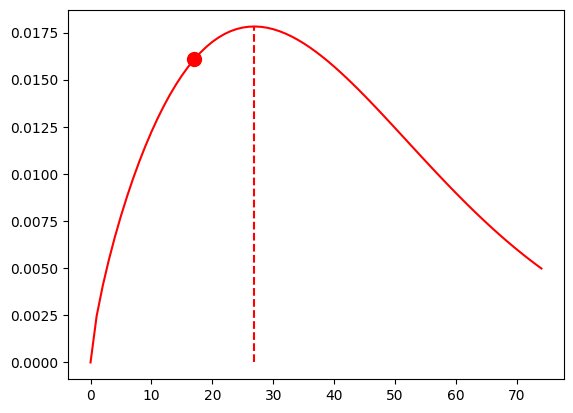

        T    E      alpha      beta  unit_number
191  14.0  1.0  43.790077  1.728141          192


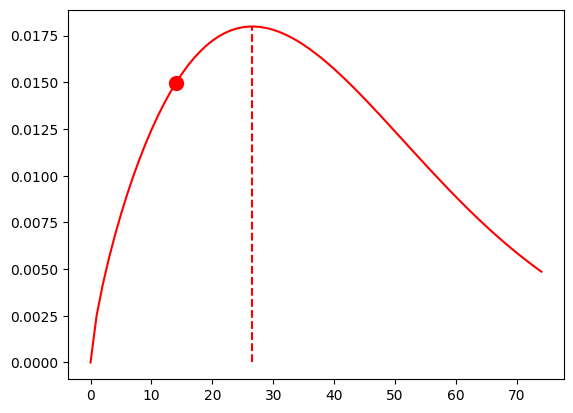

       T    E      alpha      beta  unit_number
192  7.0  1.0  43.868492  1.728707          193


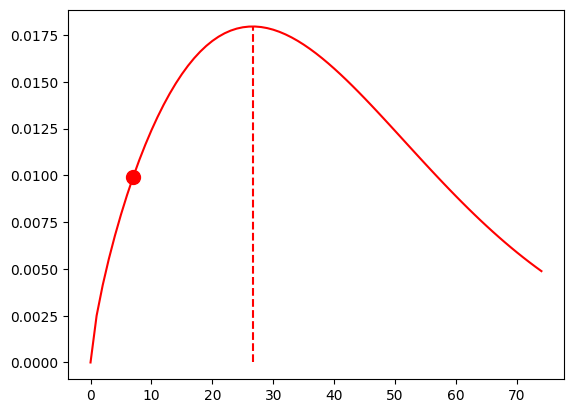

        T    E      alpha      beta  unit_number
193  15.0  1.0  43.593117  1.726794          194


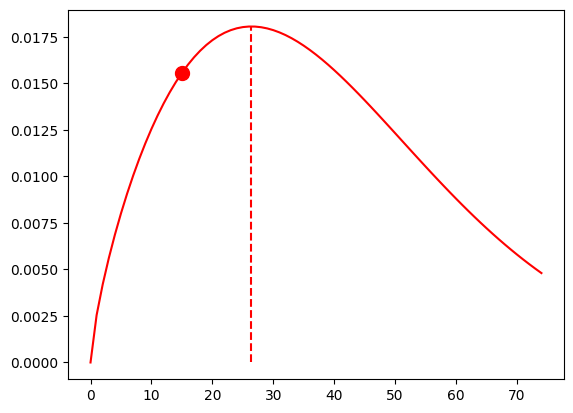

        T    E      alpha      beta  unit_number
194  14.0  1.0  45.707573  1.739075          195


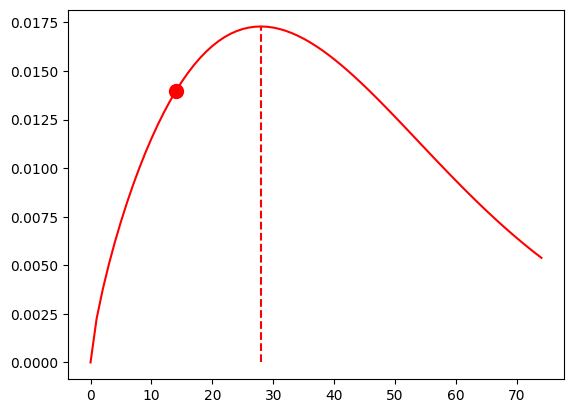

       T    E      alpha      beta  unit_number
195  8.0  1.0  43.635643  1.727062          196


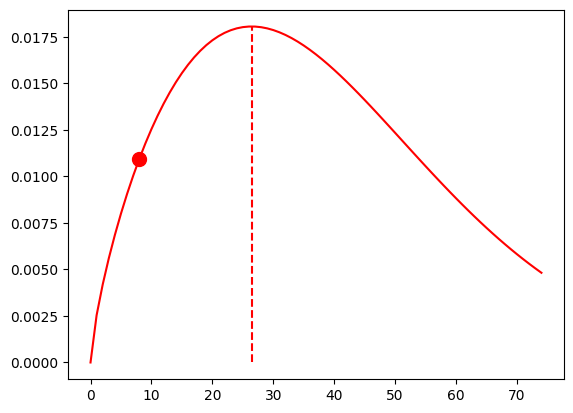

        T    E      alpha      beta  unit_number
196  21.0  1.0  43.712616  1.727574          197


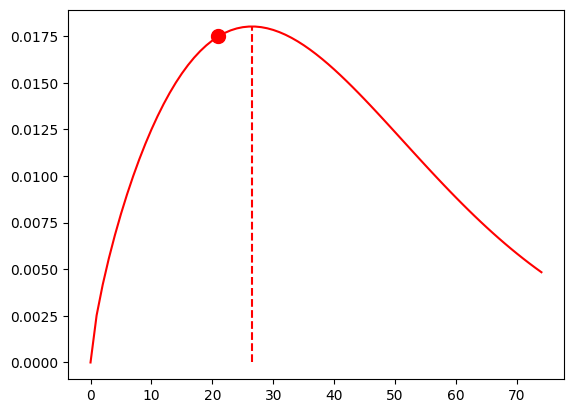

        T    E      alpha      beta  unit_number
197  20.0  1.0  44.326729  1.730883          198


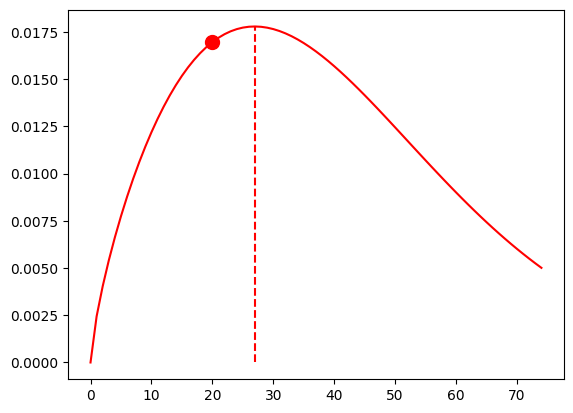

        T    E      alpha      beta  unit_number
198  13.0  1.0  43.837532  1.727842          199


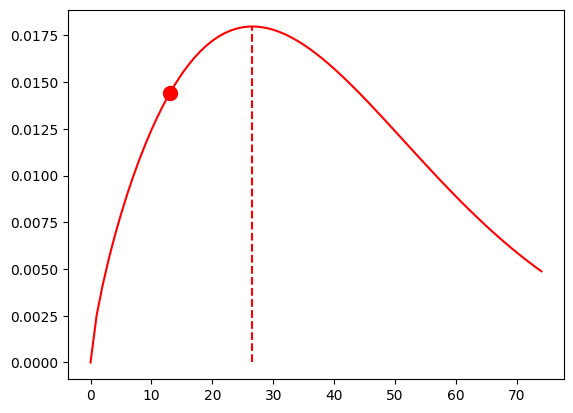

       T    E      alpha      beta  unit_number
199  5.0  1.0  15.557818  1.293873          200


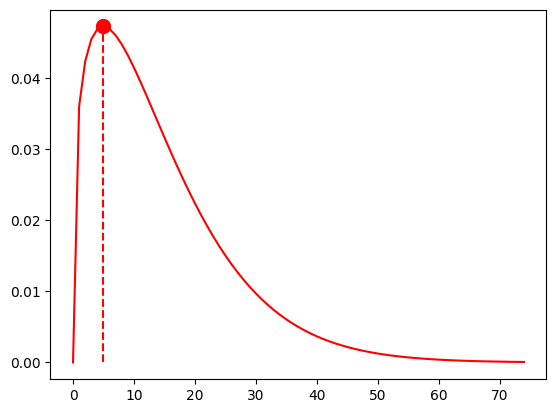

        T    E      alpha      beta  unit_number
200  15.0  1.0  43.634979  1.726876          201


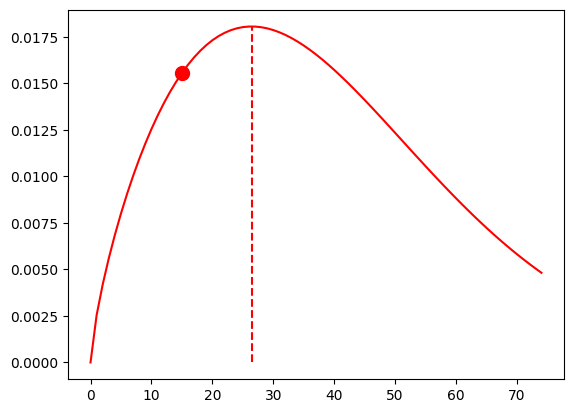

        T    E      alpha      beta  unit_number
201  17.0  1.0  43.817585  1.728748          202


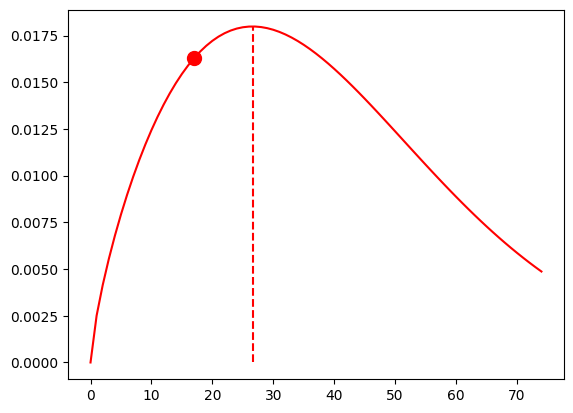

        T    E      alpha      beta  unit_number
202  30.0  1.0  43.654503  1.726609          203


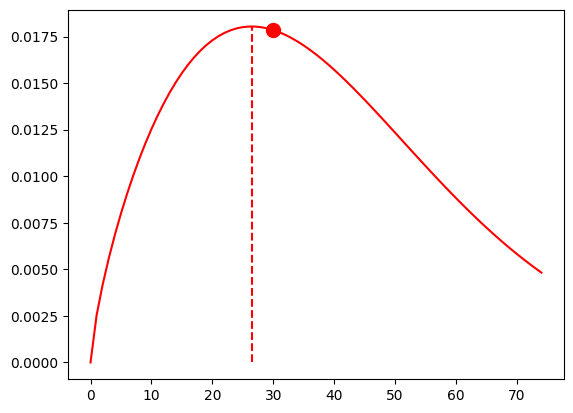

       T    E      alpha      beta  unit_number
203  9.0  1.0  43.674198  1.727292          204


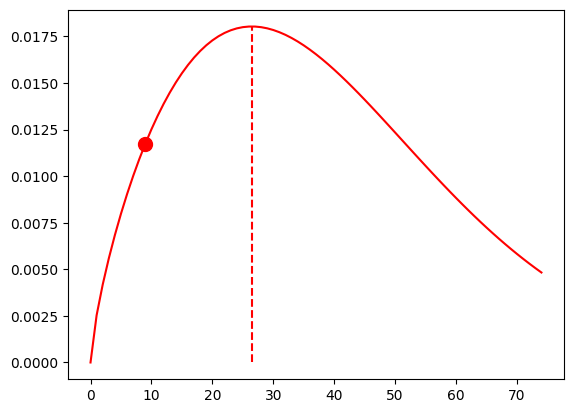

        T    E      alpha      beta  unit_number
204  36.0  1.0  43.091877  1.725039          205


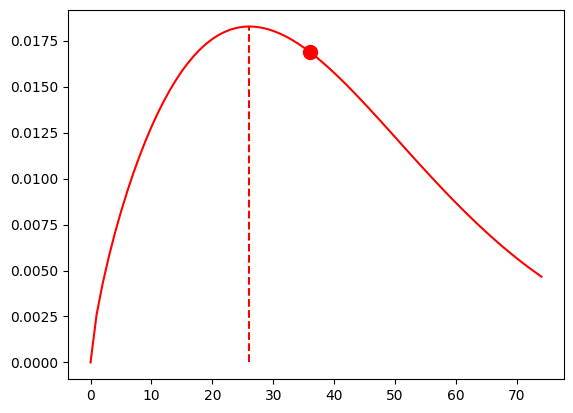

        T    E      alpha      beta  unit_number
205  23.0  1.0  45.508018  1.738367          206


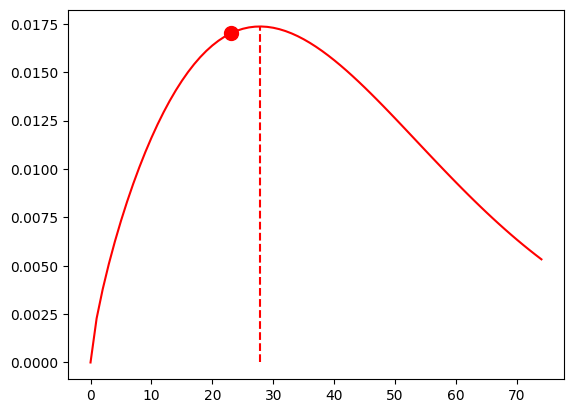

        T    E      alpha      beta  unit_number
206  19.0  1.0  43.537071  1.726529          207


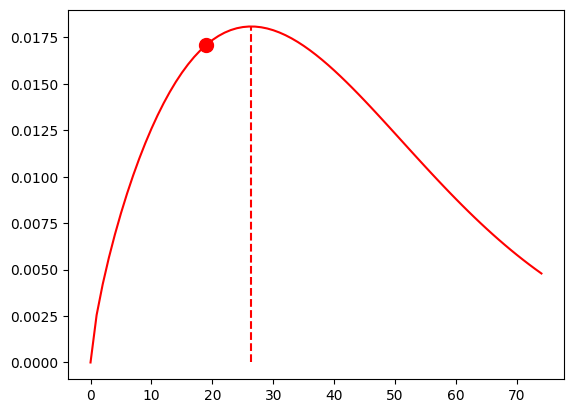

        T    E      alpha      beta  unit_number
207  10.0  1.0  43.654083  1.727243          208


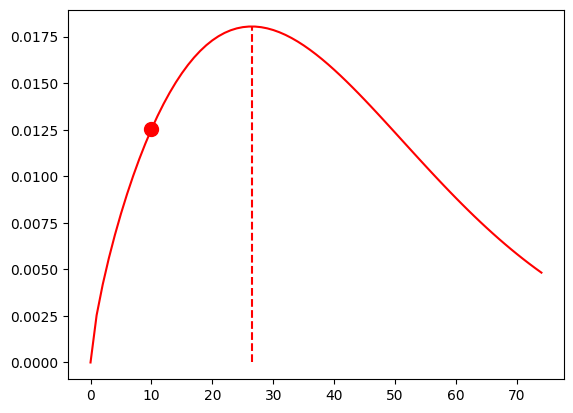

        T    E      alpha      beta  unit_number
208  33.0  1.0  43.618504  1.727307          209


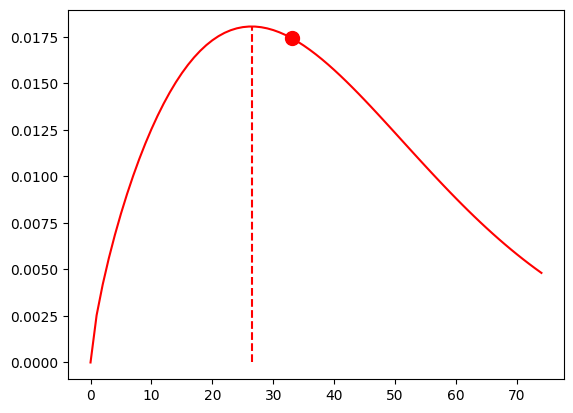

        T    E      alpha      beta  unit_number
209  29.0  1.0  43.673824  1.727274          210


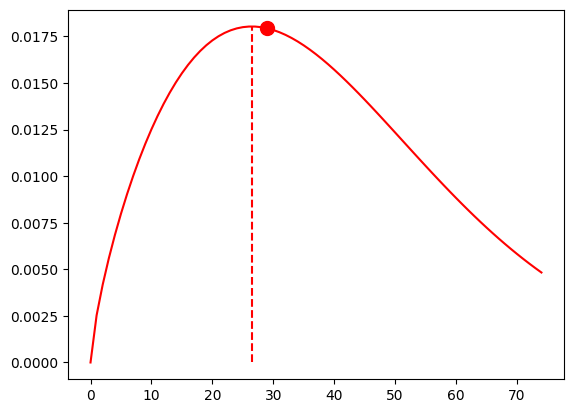

       T    E      alpha      beta  unit_number
210  7.0  1.0  43.642761  1.727652          211


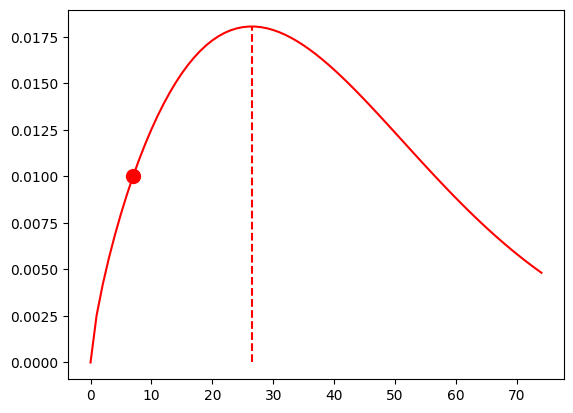

        T    E      alpha      beta  unit_number
211  13.0  1.0  44.326862  1.730875          212


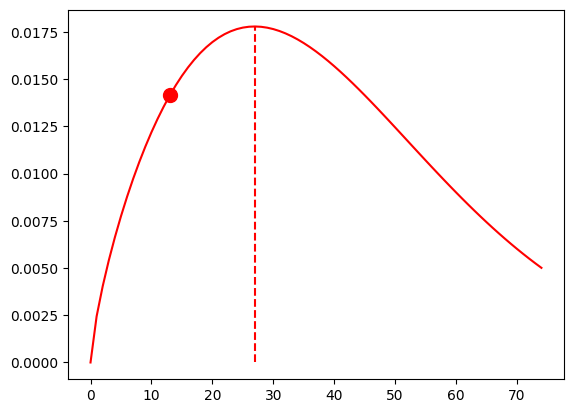

       T    E     alpha  beta  unit_number
212  3.0  1.0  3.001672   1.1          213


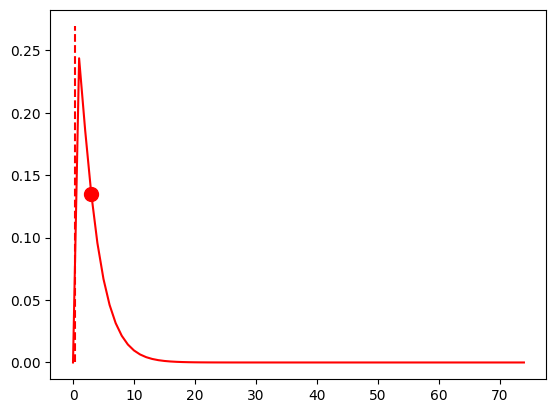

       T    E     alpha      beta  unit_number
213  4.0  1.0  6.050063  1.031129          214


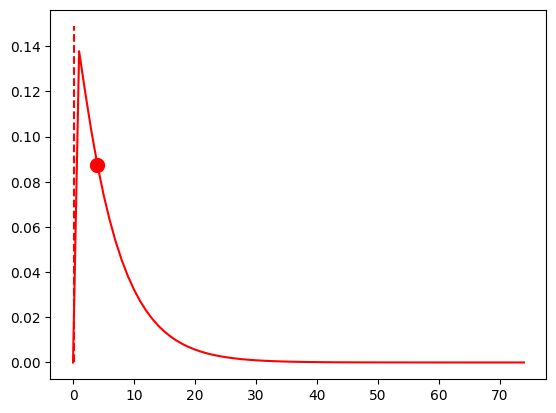

       T    E    alpha      beta  unit_number
214  4.0  1.0  6.04025  1.030883          215


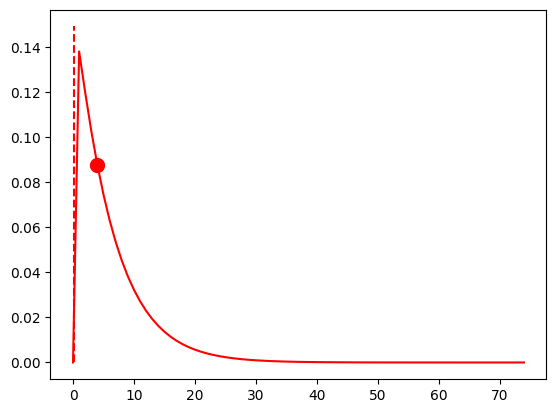

       T    E      alpha      beta  unit_number
215  7.0  1.0  43.640442  1.727142          216


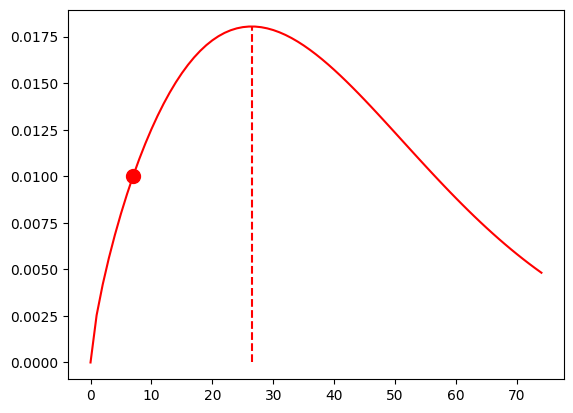

       T    E      alpha      beta  unit_number
216  6.0  1.0  43.773563  1.727725          217


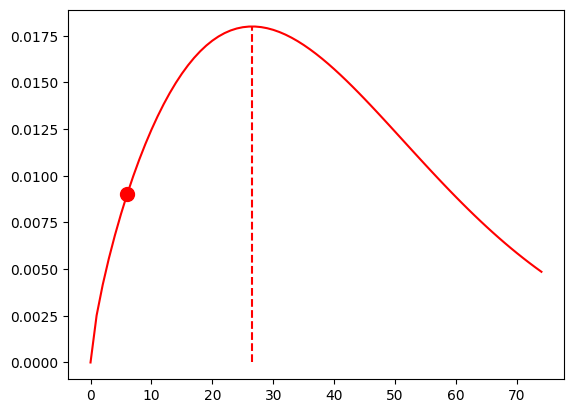

       T    E      alpha      beta  unit_number
217  5.0  1.0  15.534935  1.293879          218


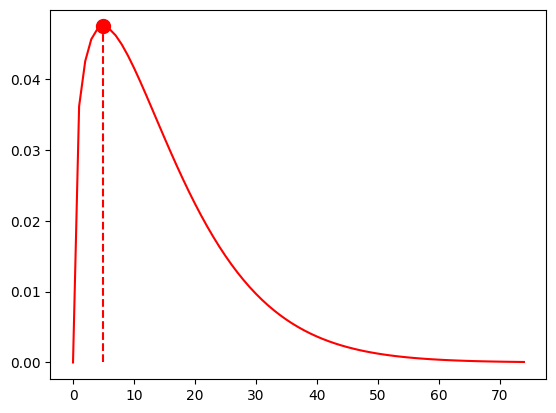

        T    E      alpha      beta  unit_number
218  24.0  1.0  43.540691  1.726585          219


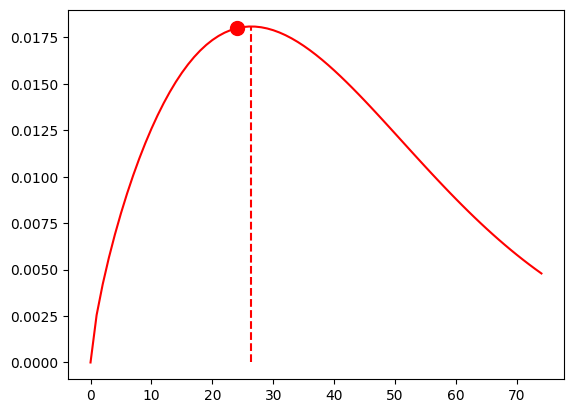

       T    E      alpha      beta  unit_number
219  9.0  1.0  43.695164  1.727877          220


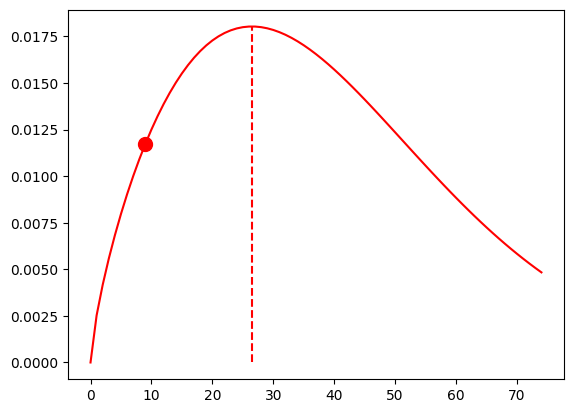

        T    E      alpha      beta  unit_number
220  17.0  1.0  43.710659  1.727405          221


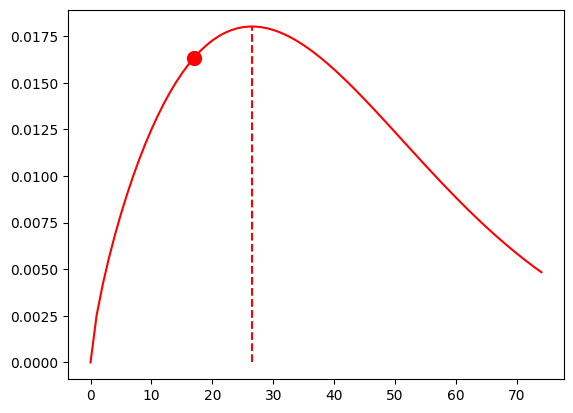

        T    E      alpha      beta  unit_number
221  12.0  1.0  45.537331  1.738615          222


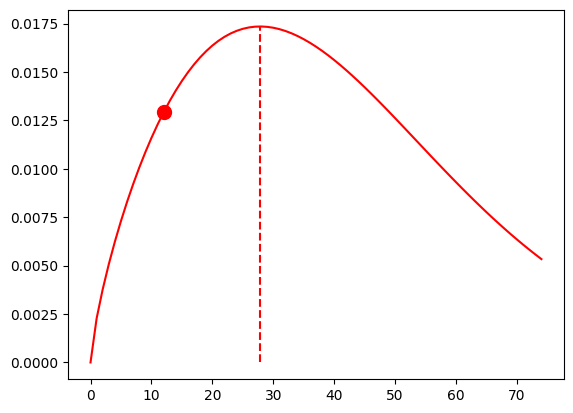

       T    E     alpha  beta  unit_number
222  2.0  1.0  1.899417   1.1          223


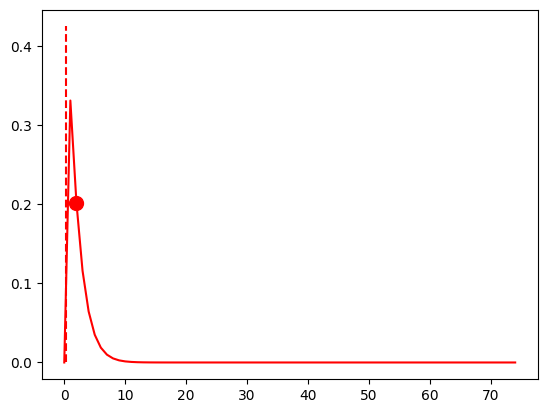

       T    E      alpha      beta  unit_number
223  9.0  1.0  43.840481  1.728483          224


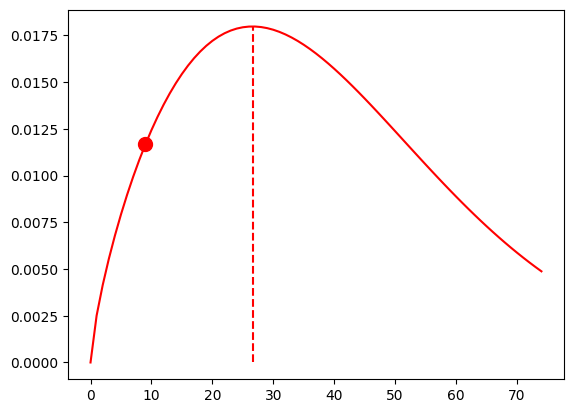

       T    E     alpha      beta  unit_number
224  4.0  1.0  6.062088  1.031064          225


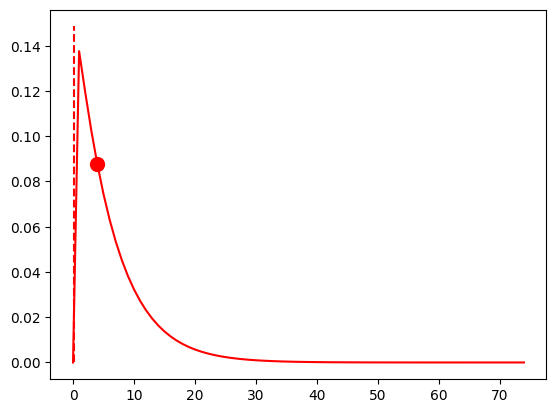

        T    E      alpha      beta  unit_number
225  13.0  1.0  43.704304  1.727504          226


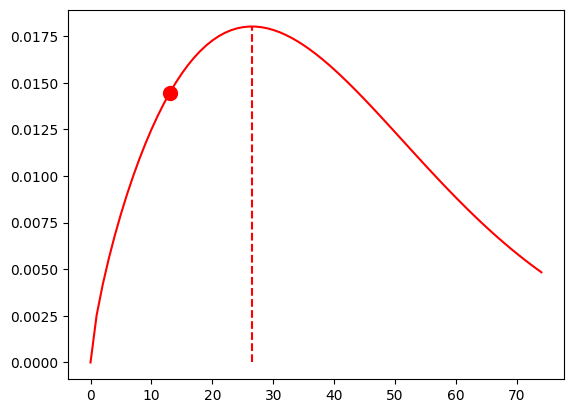

        T    E      alpha      beta  unit_number
226  10.0  1.0  43.647182  1.727353          227


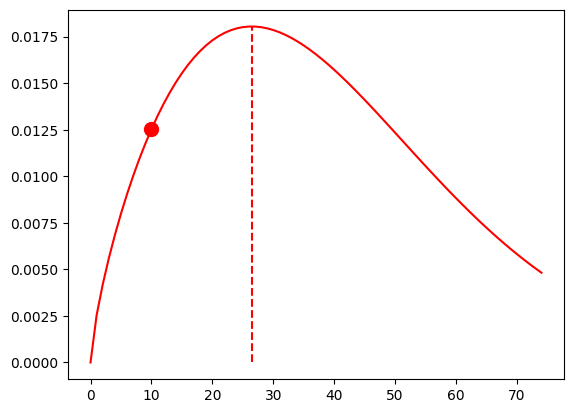

        T    E      alpha     beta  unit_number
227  40.0  1.0  43.855179  1.72832          228


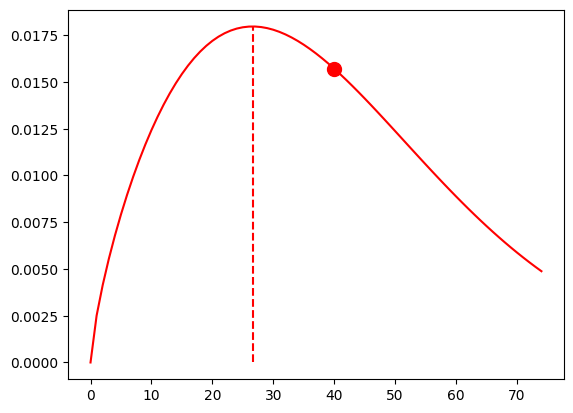

       T    E     alpha  beta  unit_number
228  3.0  1.0  2.998927   1.1          229


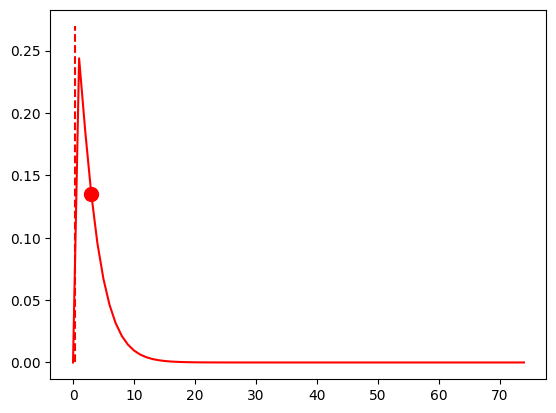

       T    E     alpha  beta  unit_number
229  3.0  1.0  2.998847   1.1          230


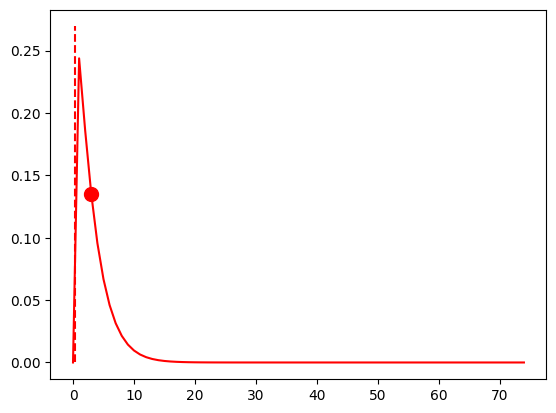

       T    E     alpha  beta  unit_number
230  1.0  1.0  1.448839   1.1          231


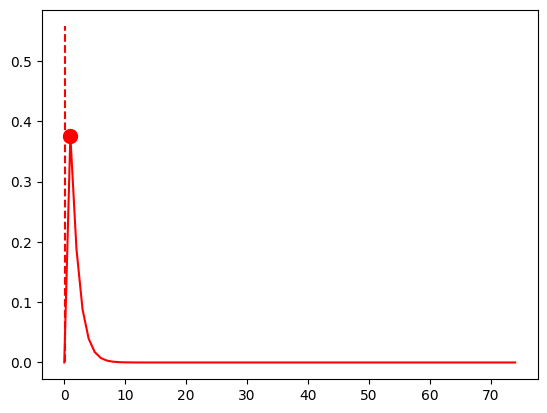

        T    E      alpha      beta  unit_number
231  16.0  1.0  43.868565  1.728526          232


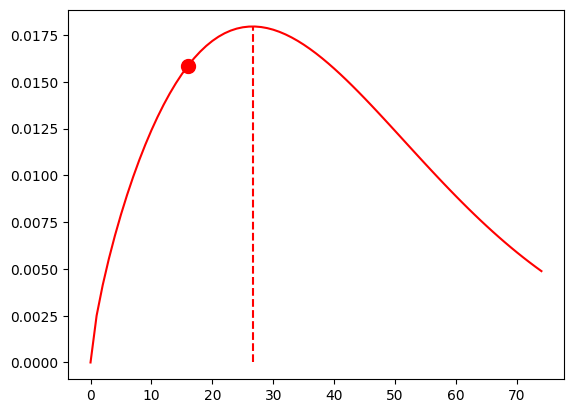

        T    E     alpha      beta  unit_number
232  16.0  1.0  43.85524  1.728397          233


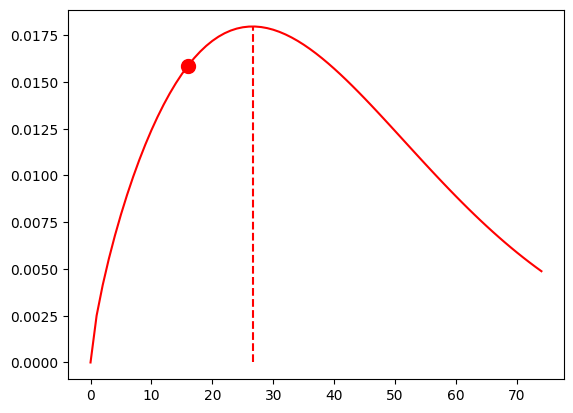

        T    E      alpha      beta  unit_number
233  14.0  1.0  43.754681  1.727888          234


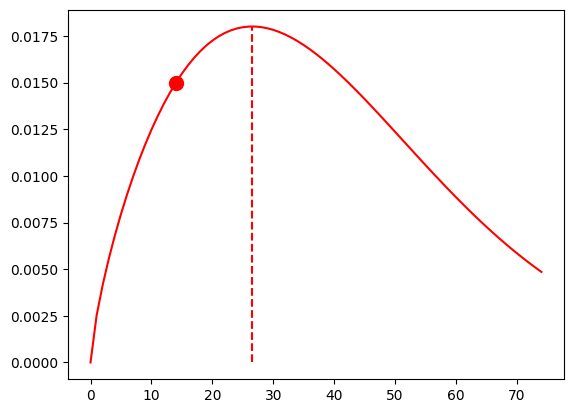

        T    E      alpha      beta  unit_number
234  16.0  1.0  43.558208  1.726725          235


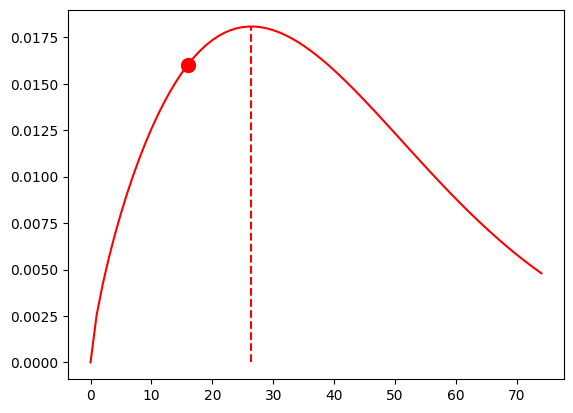

        T    E      alpha     beta  unit_number
235  10.0  1.0  43.632744  1.72727          236


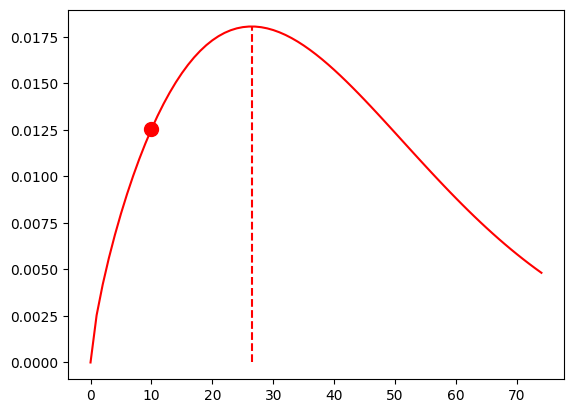

        T    E      alpha    beta  unit_number
236  34.0  1.0  43.410595  1.7258          237


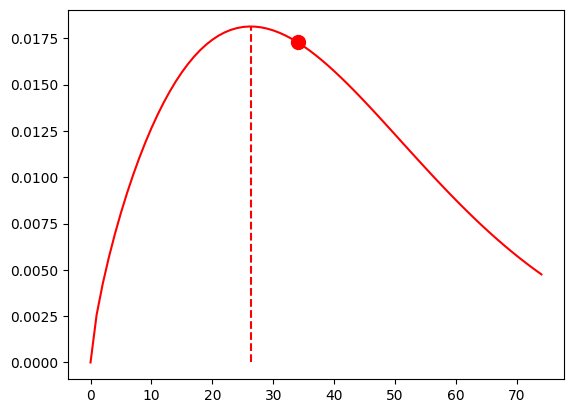

        T    E      alpha      beta  unit_number
237  14.0  1.0  44.241333  1.730334          238


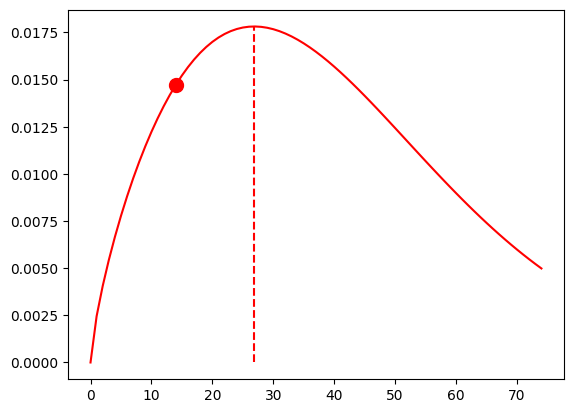

        T    E      alpha      beta  unit_number
238  13.0  1.0  43.903755  1.728714          239


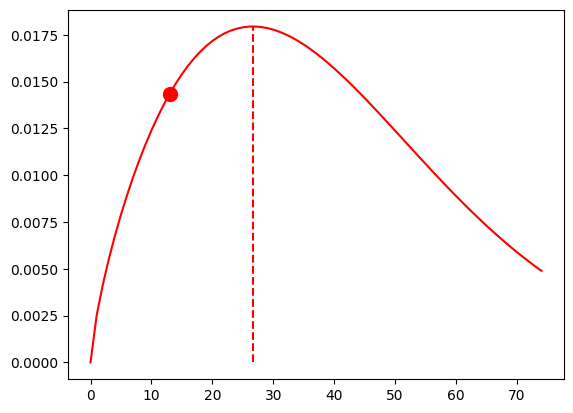

       T    E      alpha      beta  unit_number
239  7.0  1.0  43.640892  1.727062          240


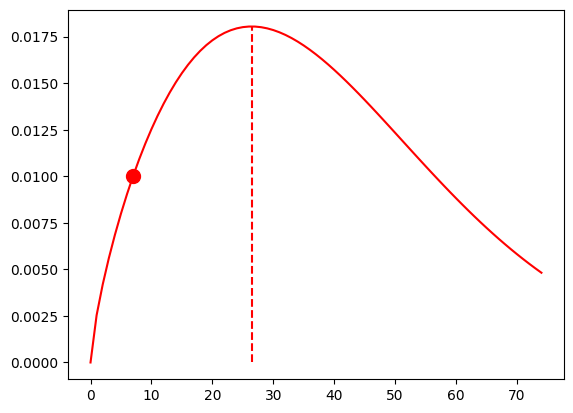

        T    E      alpha      beta  unit_number
240  17.0  1.0  43.618389  1.727418          241


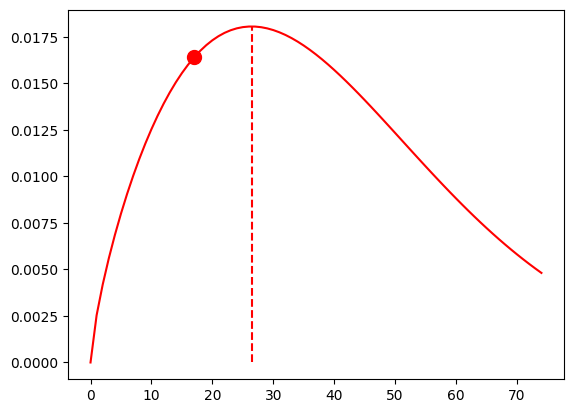

        T    E      alpha      beta  unit_number
241  10.0  1.0  43.803253  1.728168          242


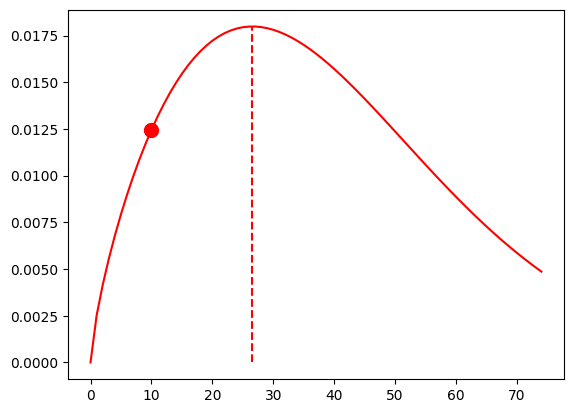

        T    E      alpha      beta  unit_number
242  19.0  1.0  43.751465  1.728215          243


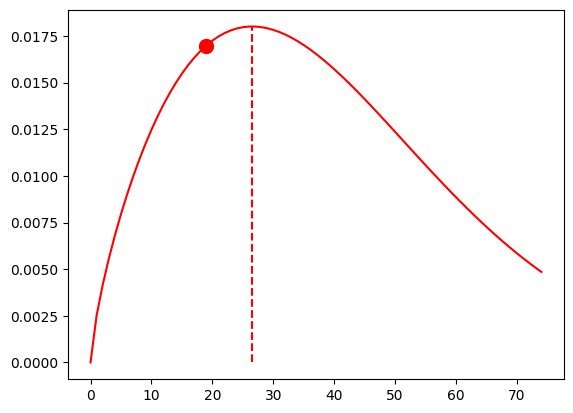

       T    E     alpha  beta  unit_number
243  2.0  1.0  1.900143   1.1          244


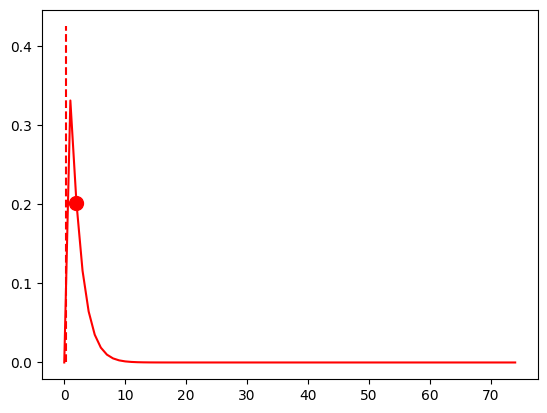

       T    E      alpha      beta  unit_number
244  9.0  1.0  43.891003  1.728902          245


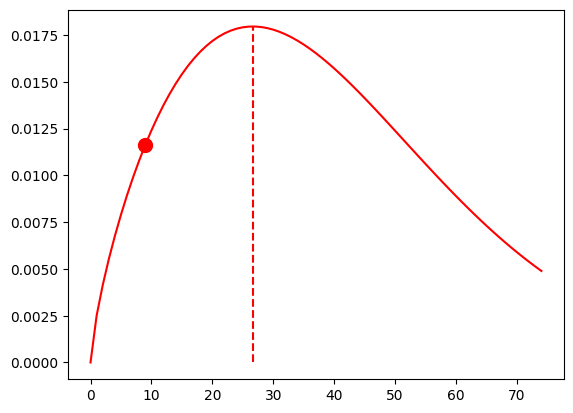

       T    E     alpha  beta  unit_number
245  1.0  1.0  1.448839   1.1          246


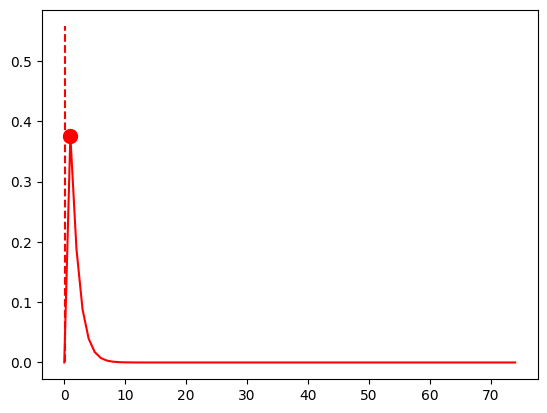

        T    E      alpha      beta  unit_number
246  23.0  1.0  43.736115  1.727887          247


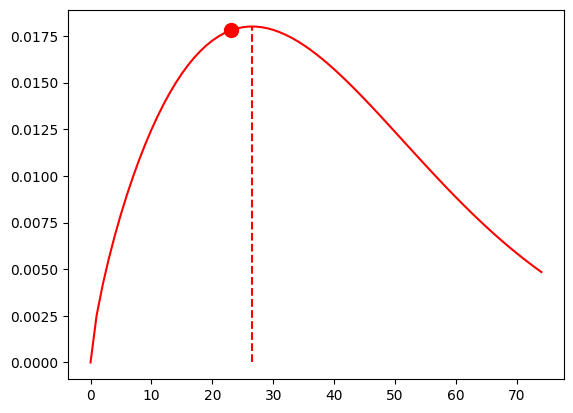

       T    E      alpha      beta  unit_number
247  9.0  1.0  43.793606  1.728153          248


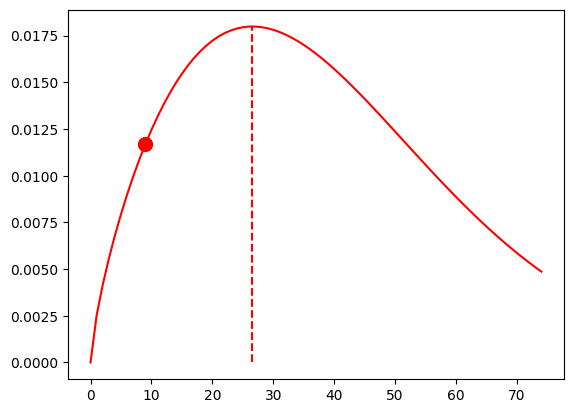

       T    E      alpha      beta  unit_number
248  6.0  1.0  44.060375  1.729515          249


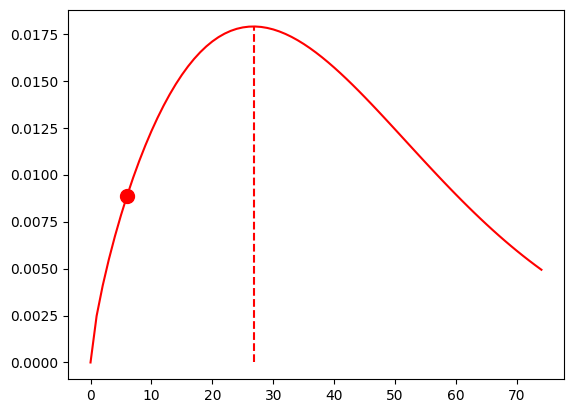

        T    E      alpha      beta  unit_number
249  19.0  1.0  43.958481  1.728983          250


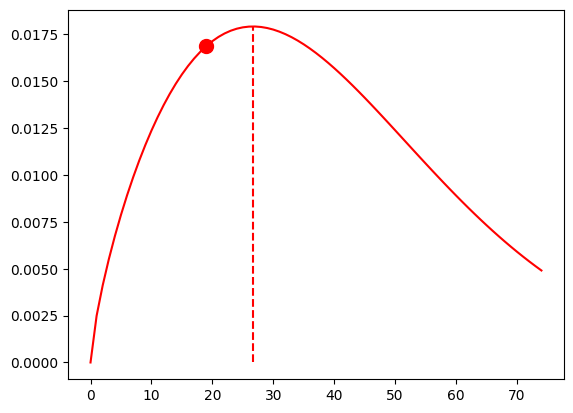

        T    E      alpha      beta  unit_number
250  32.0  1.0  43.440308  1.724787          251


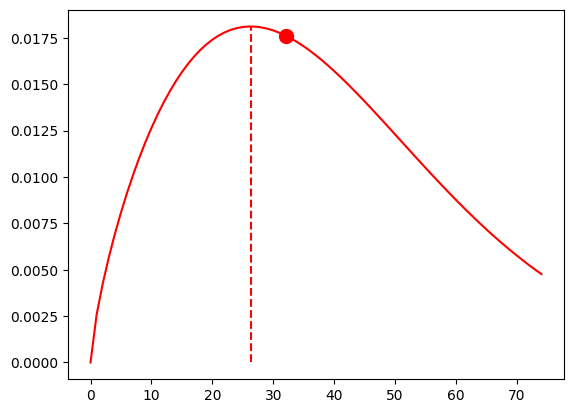

        T    E     alpha      beta  unit_number
251  14.0  1.0  43.49675  1.726477          252


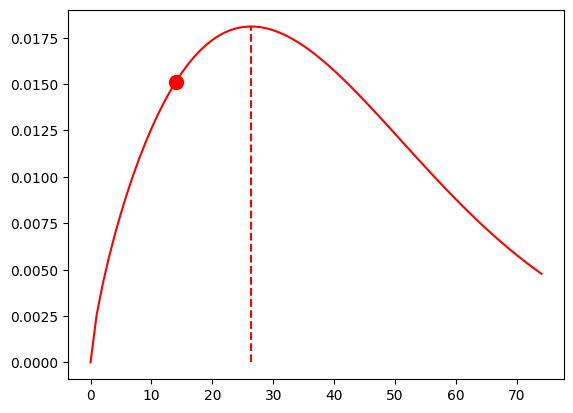

       T    E     alpha      beta  unit_number
252  4.0  1.0  6.033263  1.030757          253


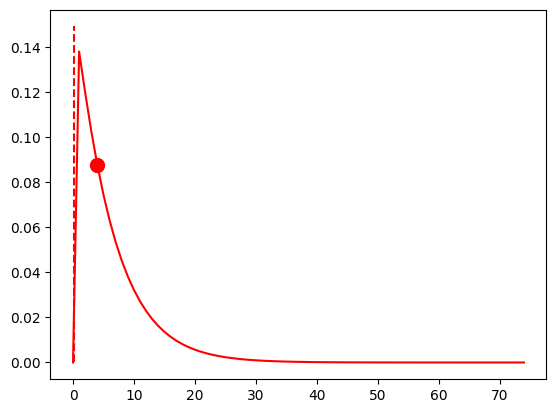

        T    E     alpha      beta  unit_number
253  15.0  1.0  43.51593  1.726402          254


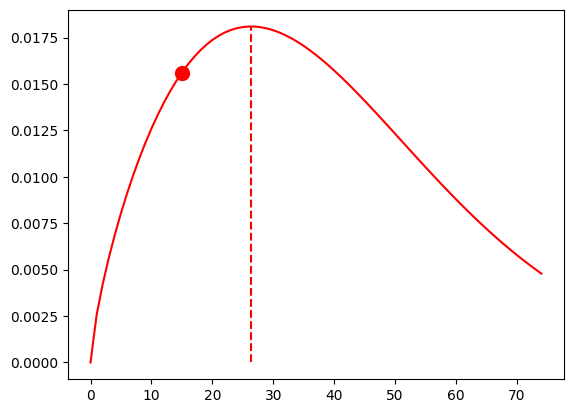

       T    E      alpha      beta  unit_number
254  6.0  1.0  43.758183  1.728371          255


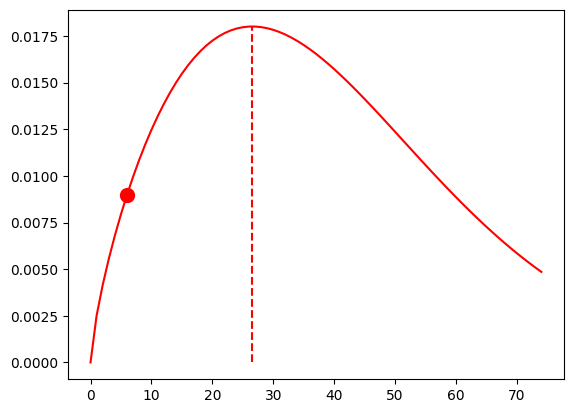

        T    E      alpha     beta  unit_number
255  21.0  1.0  45.015682  1.73508          256


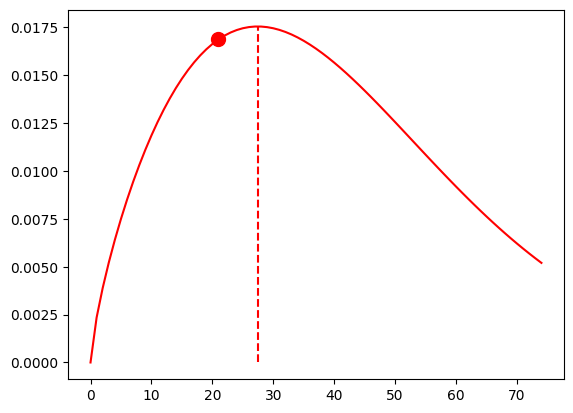

       T    E      alpha      beta  unit_number
256  8.0  1.0  43.616058  1.726873          257


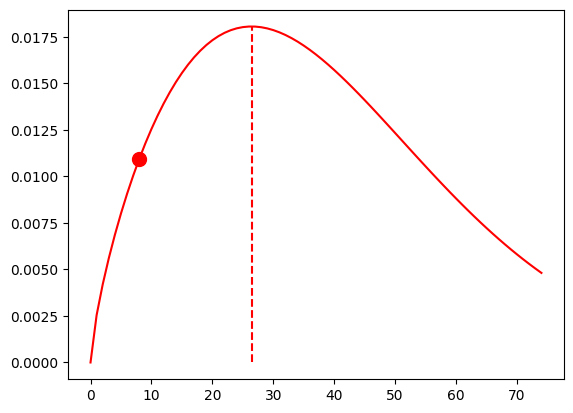

       T    E      alpha      beta  unit_number
257  6.0  1.0  43.890095  1.728855          258


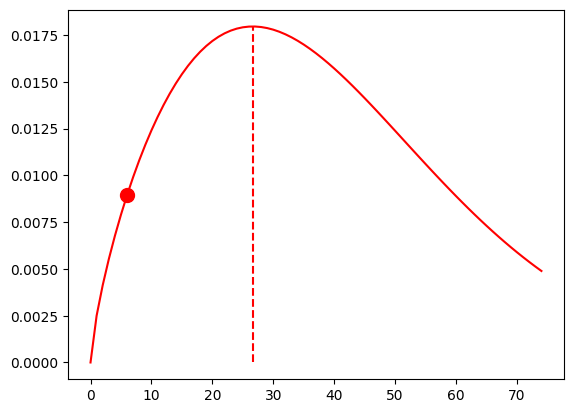

        T    E      alpha     beta  unit_number
258  12.0  1.0  43.567421  1.72672          259


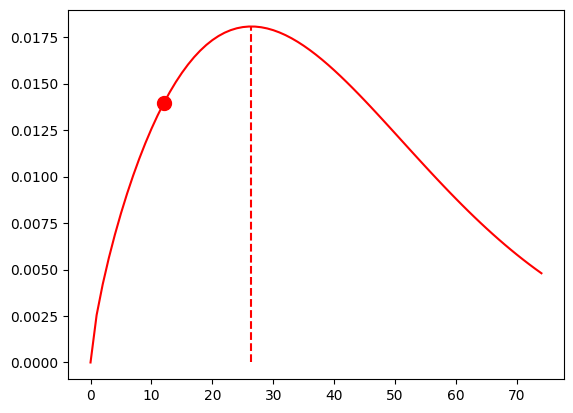

        T    E      alpha      beta  unit_number
259  10.0  1.0  43.590309  1.726782          260


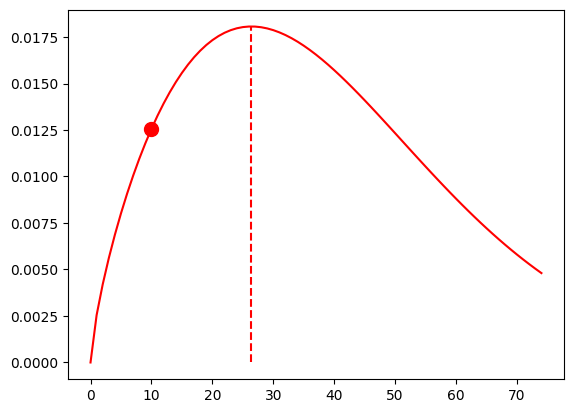

        T    E      alpha      beta  unit_number
260  30.0  1.0  43.638924  1.726839          261


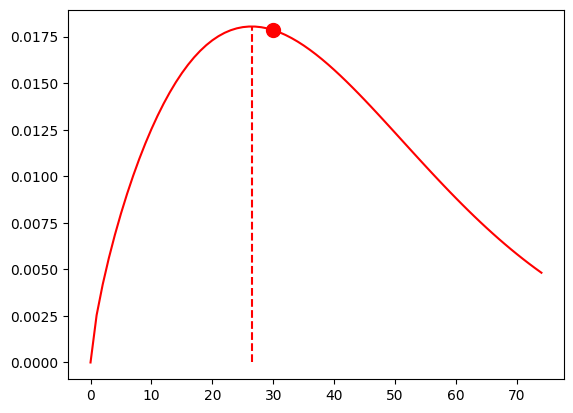

       T    E     alpha  beta  unit_number
261  2.0  1.0  1.899592   1.1          262


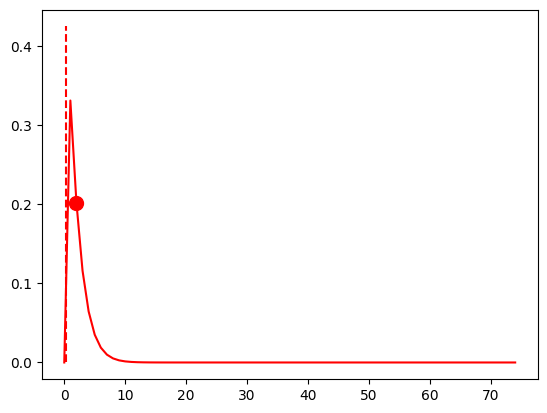

        T    E      alpha      beta  unit_number
262  64.0  1.0  43.576283  1.726474          263


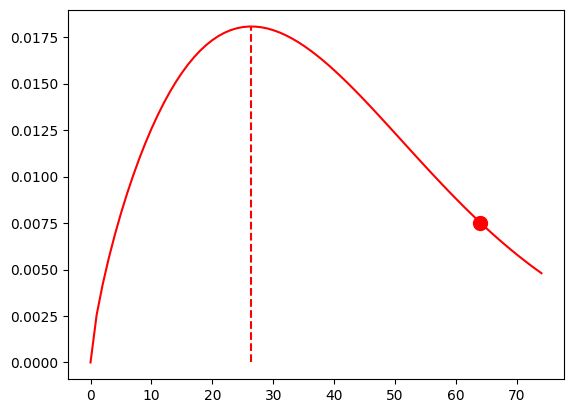

        T    E      alpha      beta  unit_number
263  11.0  1.0  43.589901  1.726842          264


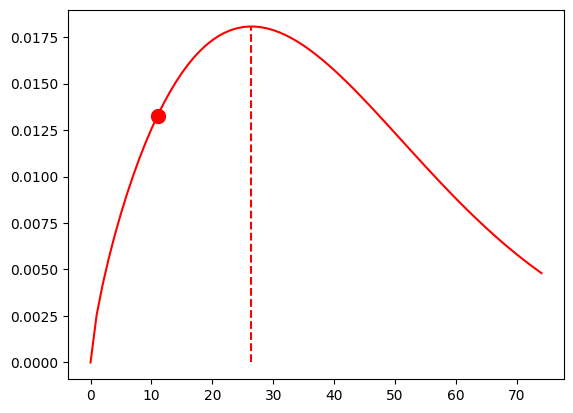

        T    E      alpha      beta  unit_number
264  20.0  1.0  43.768795  1.727883          265


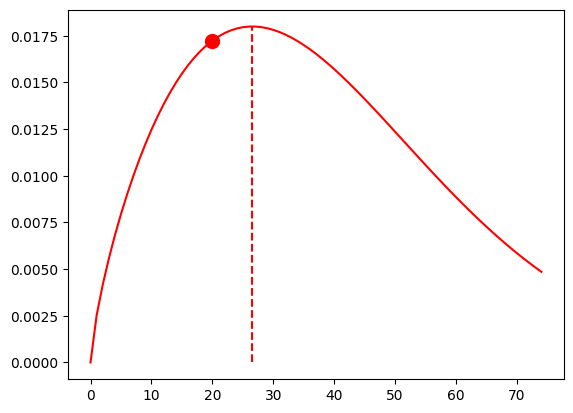

        T    E      alpha      beta  unit_number
265  21.0  1.0  44.903042  1.734684          266


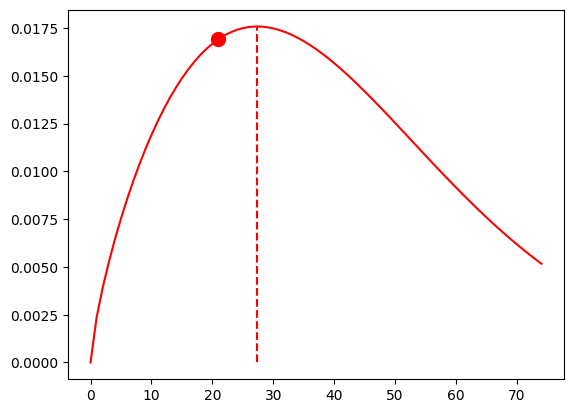

       T    E    alpha  beta  unit_number
266  2.0  1.0  1.90017   1.1          267


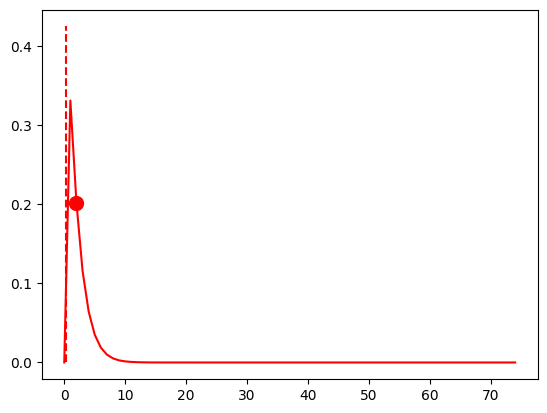

       T    E      alpha     beta  unit_number
267  5.0  1.0  15.508136  1.29339          268


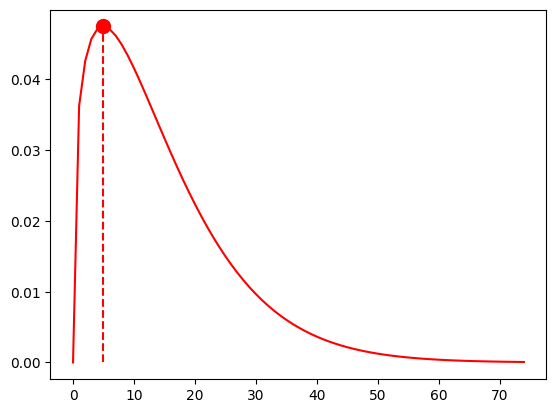

        T    E      alpha      beta  unit_number
268  18.0  1.0  44.489132  1.732257          269


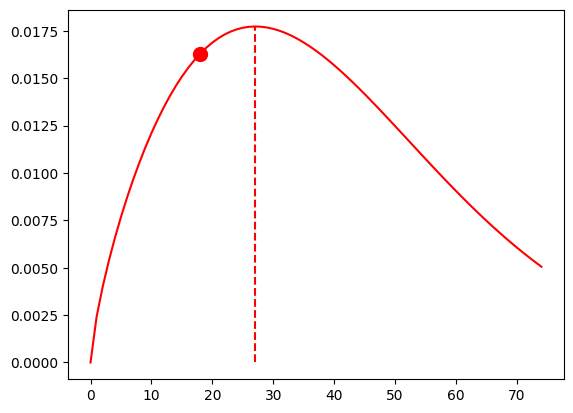

        T    E      alpha      beta  unit_number
269  20.0  1.0  43.904526  1.728866          270


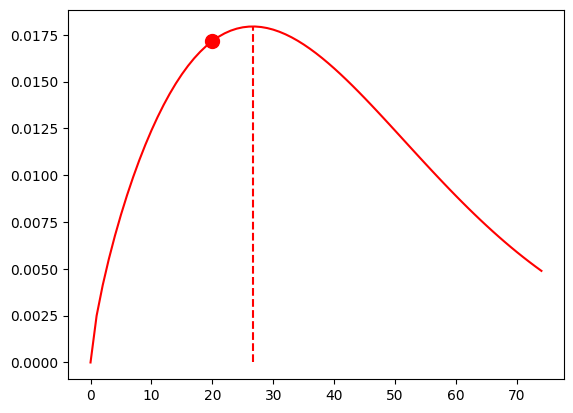

       T    E     alpha  beta  unit_number
270  2.0  1.0  1.899678   1.1          271


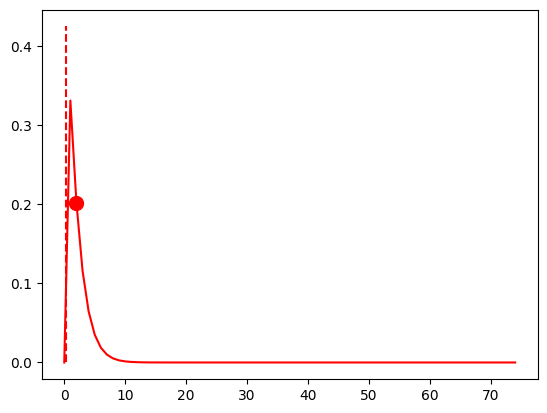

       T    E     alpha  beta  unit_number
271  1.0  1.0  1.448839   1.1          272


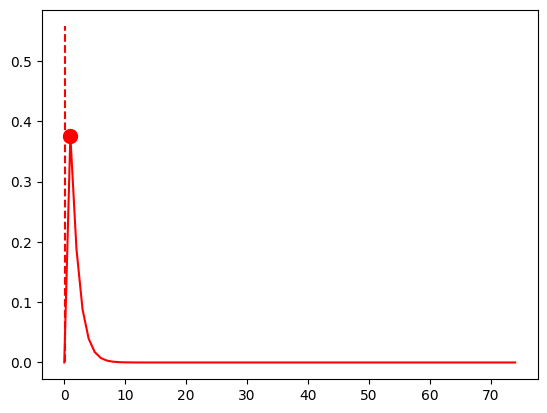

        T    E      alpha      beta  unit_number
272  13.0  1.0  43.760593  1.727873          273


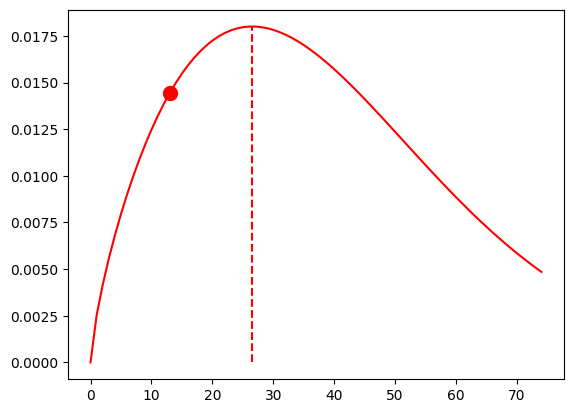

        T    E      alpha      beta  unit_number
273  45.0  1.0  43.636135  1.726906          274


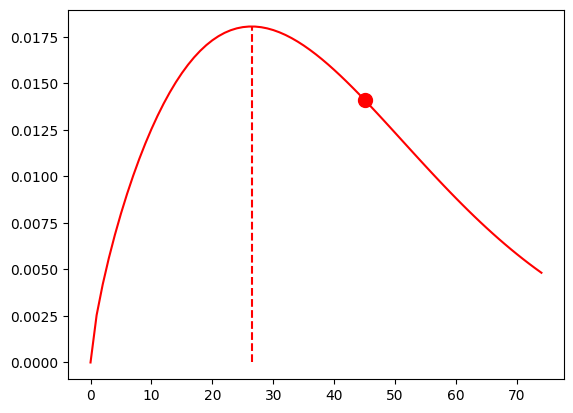

        T    E     alpha      beta  unit_number
274  11.0  1.0  43.90501  1.728711          275


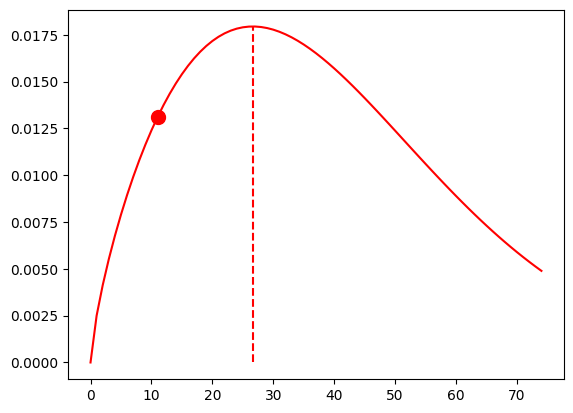

        T    E      alpha      beta  unit_number
275  16.0  1.0  44.569649  1.732562          276


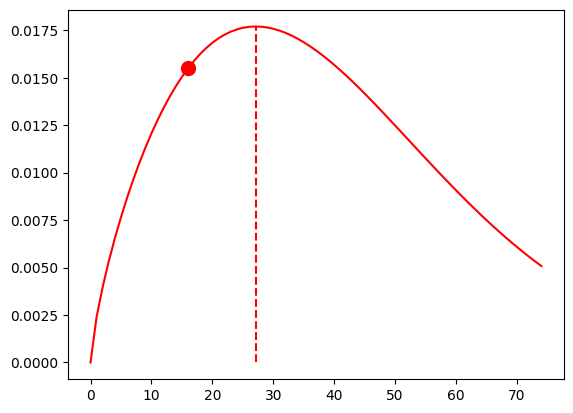

        T    E     alpha      beta  unit_number
276  19.0  1.0  43.61869  1.726842          277


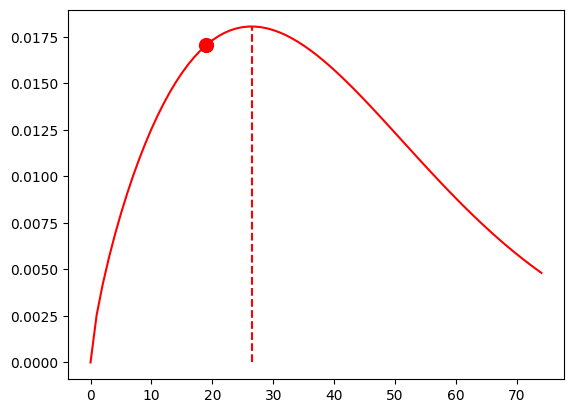

       T    E     alpha  beta  unit_number
277  3.0  1.0  2.999531   1.1          278


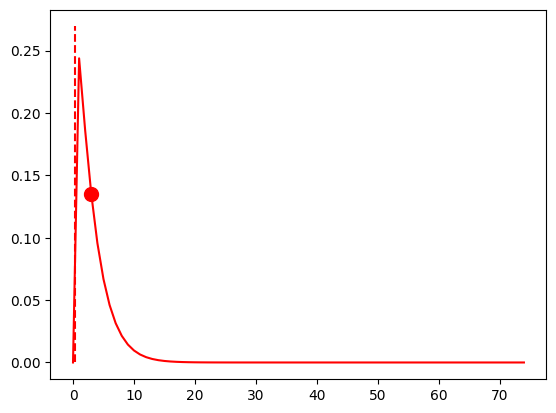

       T    E      alpha      beta  unit_number
278  6.0  1.0  44.059818  1.729881          279


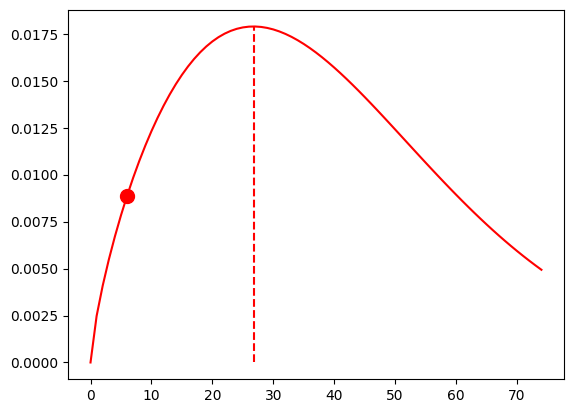

       T    E      alpha      beta  unit_number
279  9.0  1.0  43.843159  1.728912          280


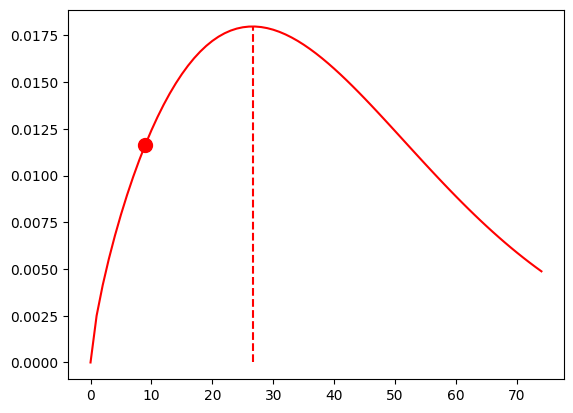

        T    E      alpha      beta  unit_number
280  41.0  1.0  43.588936  1.726707          281


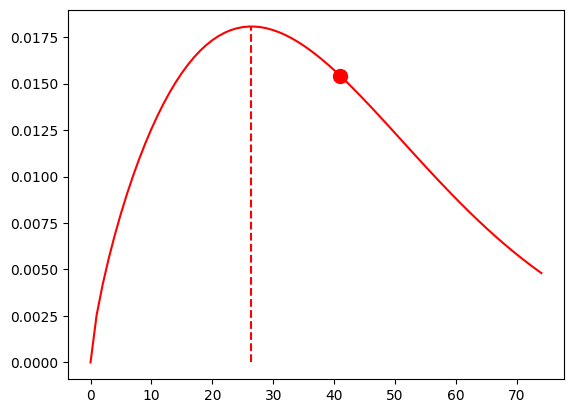

        T    E      alpha      beta  unit_number
281  32.0  1.0  43.445011  1.726326          282


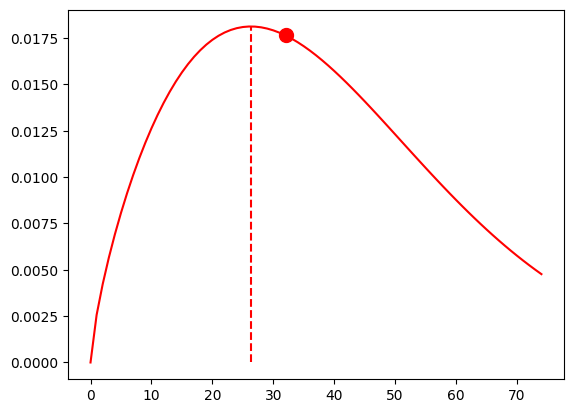

        T    E      alpha      beta  unit_number
282  15.0  1.0  43.658424  1.727312          283


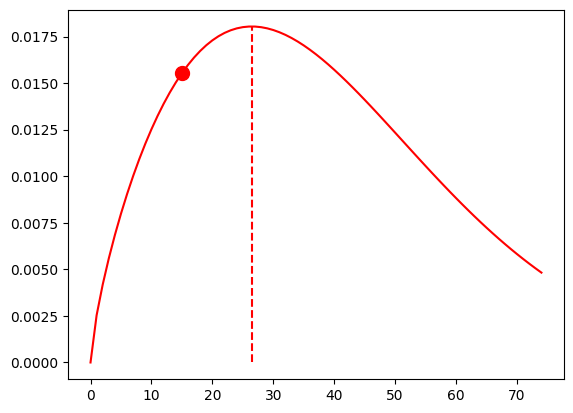

        T    E     alpha      beta  unit_number
283  15.0  1.0  43.53624  1.726492          284


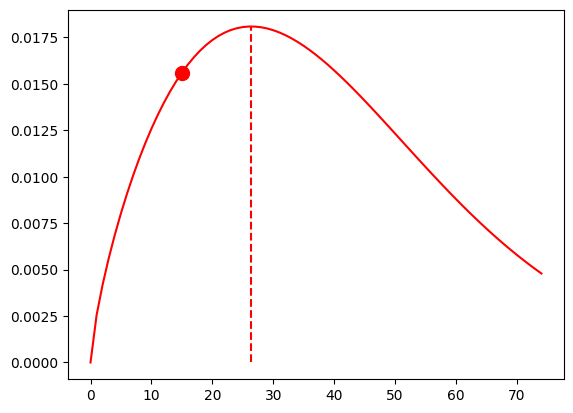

        T    E      alpha      beta  unit_number
284  26.0  1.0  43.760551  1.727869          285


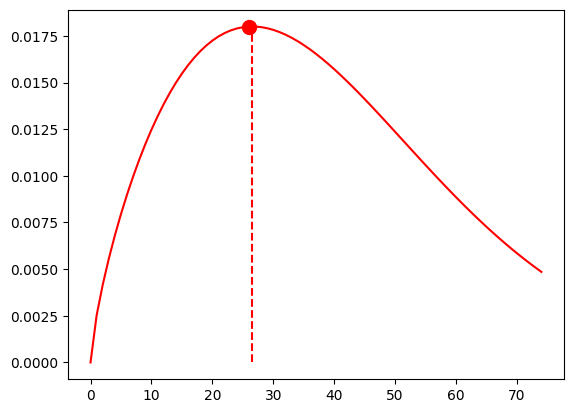

        T    E      alpha      beta  unit_number
285  20.0  1.0  43.702549  1.727631          286


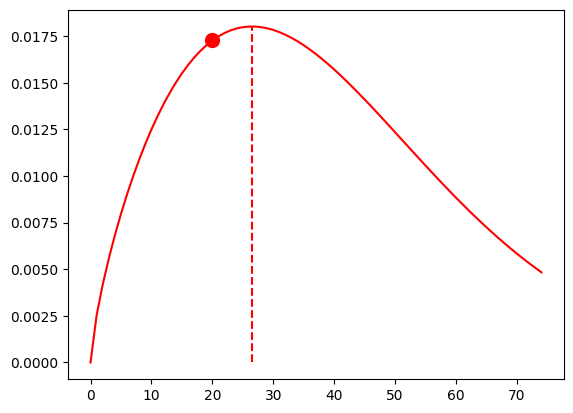

        T    E      alpha      beta  unit_number
286  44.0  1.0  43.644466  1.726758          287


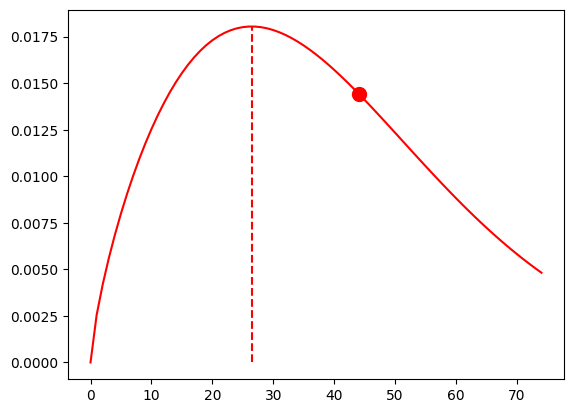

       T    E      alpha      beta  unit_number
287  6.0  1.0  43.884476  1.729097          288


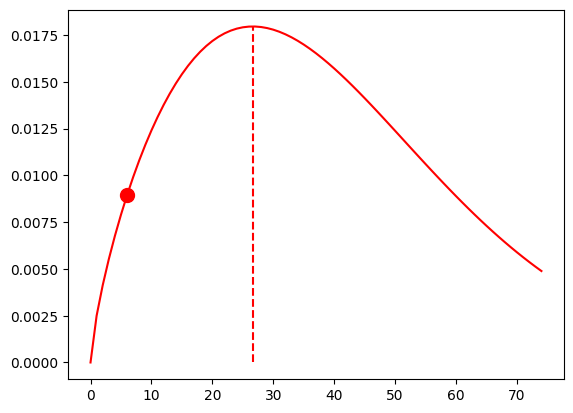

        T    E      alpha      beta  unit_number
288  24.0  1.0  43.908714  1.728729          289


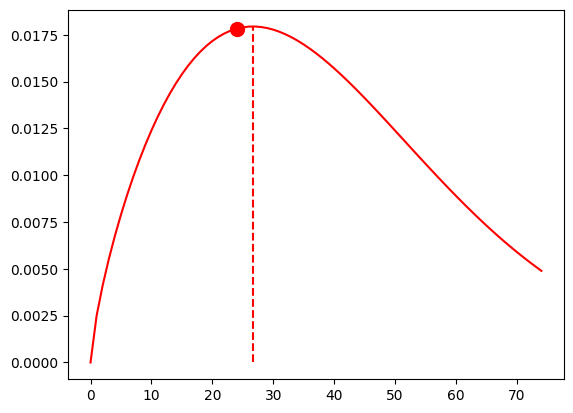

        T    E      alpha      beta  unit_number
289  11.0  1.0  43.721031  1.727479          290


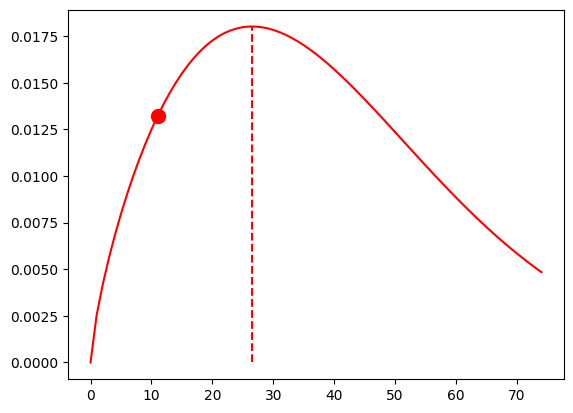

       T    E     alpha  beta  unit_number
290  1.0  1.0  1.448839   1.1          291


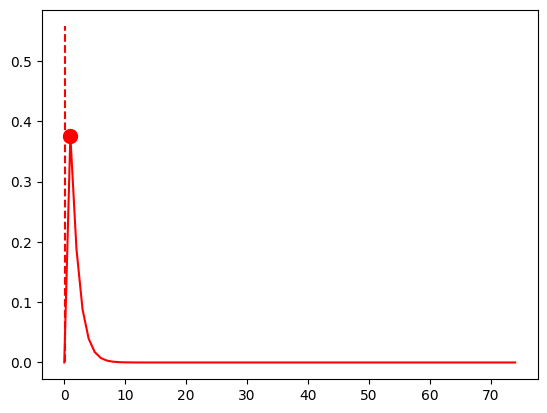

       T    E      alpha      beta  unit_number
291  7.0  1.0  43.676956  1.727445          292


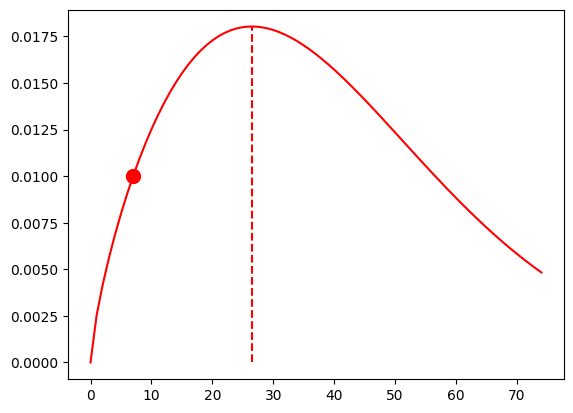

       T    E      alpha      beta  unit_number
292  7.0  1.0  43.634441  1.727193          293


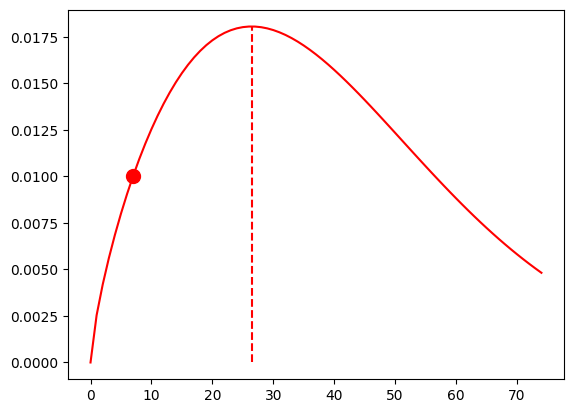

        T    E      alpha      beta  unit_number
293  11.0  1.0  43.586082  1.726756          294


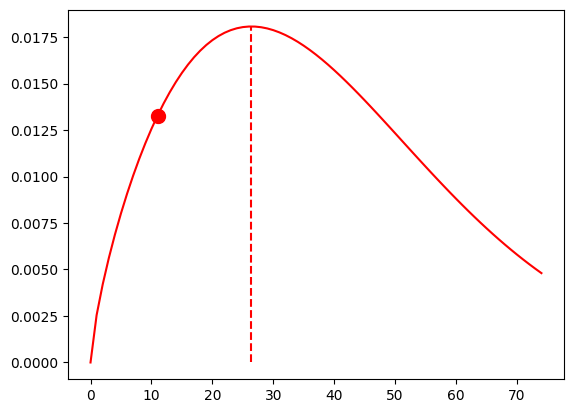

       T    E      alpha     beta  unit_number
294  5.0  1.0  15.567726  1.29399          295


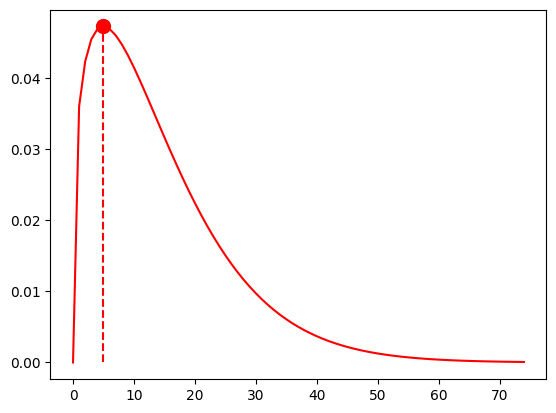

       T    E      alpha      beta  unit_number
295  8.0  1.0  43.691738  1.727596          296


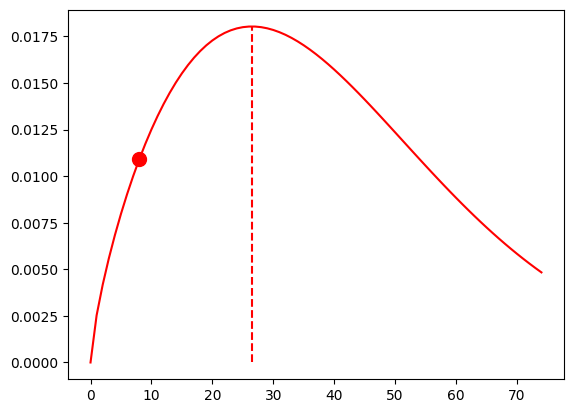

        T    E      alpha      beta  unit_number
296  25.0  1.0  43.610218  1.726784          297


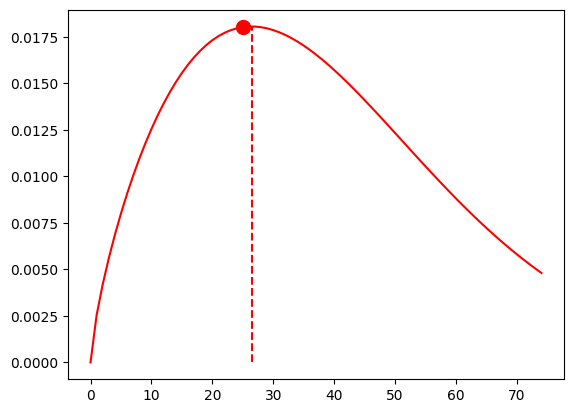

        T    E      alpha      beta  unit_number
297  14.0  1.0  46.329292  1.743569          298


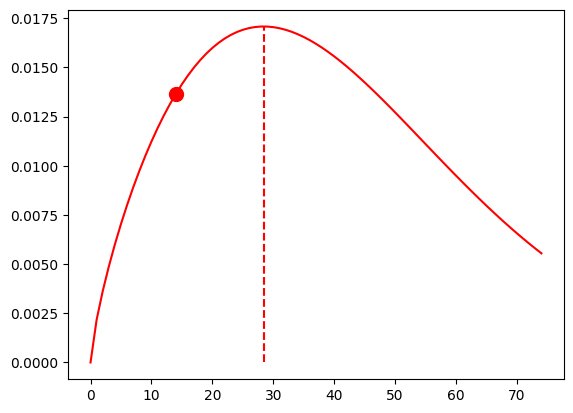

       T    E     alpha  beta  unit_number
298  1.0  1.0  1.448839   1.1          299


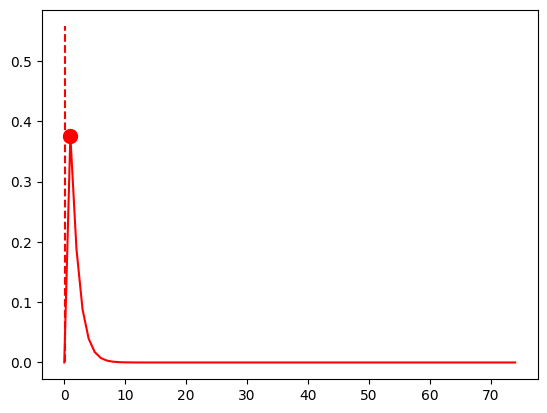

In [ ]:
#Вывод для среза пользователей
for u in range(100,300):
  plot_weibull_prediction(u,test_results_df)
  plt.show()

##Расчет вероятностей

###Расчет вероятности попадания в интервал

В этом блоке мы переводим распределение вероятностей в метку 0 или 1

![](https://sun9-26.userapi.com/impg/VrBCRqmSbTJU3JppNIu7ryckX7VT6C7ss3m2hA/eFcBoQjQAcY.jpg?size=1236x684&quality=96&sign=ae9d43d9659de3517e2afe9bd4a5a82a&type=album)

In [ ]:
# Вычисляем вероятность попадания в интервал [a, b]

def get_prop(id, test_results_df,a ,b):
    row=test_results_df[test_results_df['unit_number']==id]

    #for i, row in enumerate(results_df.iterrows()):
    alpha=row['alpha'].values[0]
    beta = row['beta'].values[0]
    T = row['T'].values[0]
    weibull_dist = weibull_min(beta, scale=alpha)
    probability = weibull_dist.cdf(b) - weibull_dist.cdf(a)

    return probability

    #print("Вероятность попадания в интервал от {} до {}: {:.4f}".format(a, b, probability))

In [ ]:
a=0
b=1

In [ ]:
get_prop(5, test_results_df,a ,b)

0.14495988342157712

считаем вероятности попадания в интервал для каждого пользователя

In [ ]:
prop_dict={}
for user_i in range(1,len(test_results_df)):
  prop_dict[user_i]=get_prop(user_i, test_results_df,a ,b)



In [ ]:
taken_ids=list(prop_dict.keys())
#check_users=  test_results_df[test_results_df['unit_number'].isin(taken_ids)]

In [ ]:
#check_users

###ROC-AUC

Ищем оптисмальный порог классификации с помощью ROC-AUC

In [ ]:
y_true_AUC=(test_y[:,0]>a) & (test_y[:,0]<=b)
y_true_AUC=y_true_AUC[:len(taken_ids)]

In [ ]:
#в вероятностях
y_pred_AUC = np.array(list(prop_dict.values()))


In [ ]:
from sklearn.metrics import precision_recall_curve

# Здесь pred_proba - это массив вероятностей принадлежности к положительному классу
# true_labels - истинные метки классов (0 или 1)

precision, recall, thresholds = precision_recall_curve(y_true_AUC, y_pred_AUC )

# Найдем индекс порога, при котором F1-мера максимальна
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)

best_threshold = thresholds[best_threshold_index]

print("Лучший порог:", best_threshold)


Лучший порог: 0.48577075307597284


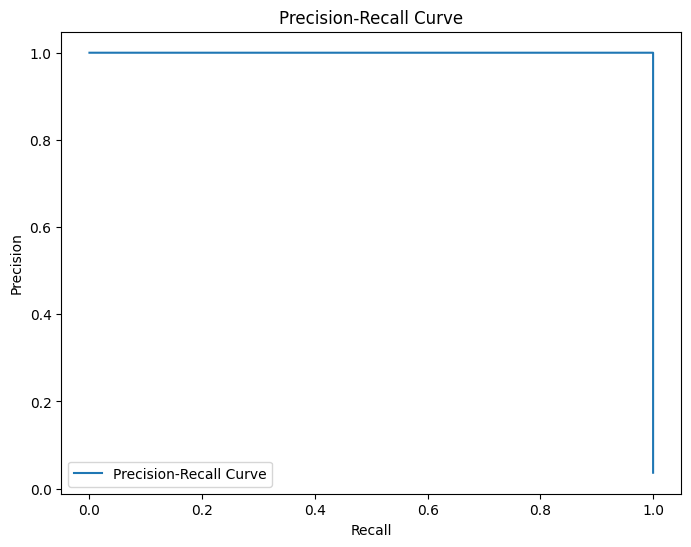

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# Переводим в метку 1 или 0
y_pred_AUC = y_pred_AUC>best_threshold

###Подсчет F1

In [ ]:
y_pred_AUC

array([False, False, False, ..., False, False, False])

In [ ]:
y_true_AUC

array([False, False, False, ...,  True, False, False])

In [ ]:
#for g, h in zip(y_pred_AUC,y_true_AUC):
#  print(g,h)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# Вычисляем F1-меру
f1 = f1_score(y_true_AUC, y_pred_AUC)

In [ ]:
# Вычисляем средний F1-скор для всех классов
f1_macro = f1_score(y_true_AUC, y_pred_AUC, average='macro')
print("средний F1-скор для всех классов = ",f1_macro)

# Вычисляем взвешенный F1-скор, учитывая дисбаланс классов
f1_weighted = f1_score(y_true_AUC, y_pred_AUC, average='weighted')
print("взвешенный F1-скор, учитывая дисбаланс классов = ",f1_weighted)

средний F1-скор для всех классов =  0.4907006369426752
взвешенный F1-скор, учитывая дисбаланс классов =  0.9455622078555203


##Преобразование предсказаний

Преобразование вывода алгоритму к типу sample_submission.csv

In [ ]:
output=pd.DataFrame([])

In [ ]:
output['customer_id']=label_encoder.inverse_transform(taken_ids)
output['label']=y_pred_AUC

In [ ]:
output

customer_id  label
0     0x0004ECA4895CDB4DADFF4A46F9BBC8EE  False
1     0x0007763F58DAD14E8576471C78973CEC  False
2     0x00080BDE942CFE449238E2C2F2A0C67D  False
3     0x000842A433587E4FA1C7D36487F7031B  False
4     0x0008C0811F770A4784DE75EF26648CD0  False
...                                  ...    ...
1994  0x0ABCC0FE7DC4BF409F91071C48DD18B2  False
1995  0x0ABFE6F702BD974B8EC5AB66D70652DB  False
1996  0x0AC1DD04883DED4A96327FA0FFCD8A44  False
1997  0x0AC4777CCCDDF44B99398AA7EA7614C9  False
1998  0x0AC78145E3E54042AED9D9585335F80B  False

[1999 rows x 2 columns]